# Import các thư viện cần thiết

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from dateutil import parser
from xgboost import XGBRegressor
from IPython.display import display, Markdown

In [2]:
import sys, importlib
sys.path.insert(0, os.path.abspath(".."))

import src.viz as viz
importlib.reload(viz)

import src.preprocess as preprocess
importlib.reload(preprocess)

from src.viz import (
    plot_diurnal_pattern, plot_weekly_pattern, plot_seasonal_pattern,
    plot_top10_episode_duration, plot_season_episode_duration,
    plot_topk_pearson_bar, plot_median_by_status_lines, plot_site_consistency_boxplot, plot_site_consistency_heatmap,
    plot_hexbin_wind_vs_aqi,
    plot_median_aqi_vs_wind_bin,
    plot_polar_median_aqi_by_wind_direction,
    plot_p_bad_by_wind_direction,
    plot_threshold_separation_curves,
    plot_aqi_yearly_trend,
    plot_aqi_monthly_trend,
    plot_aqi_year_month_heatmap,
    plot_monthly_cycle_overlay_by_year,
    plot_monthly_cycle_facet_by_year,
    plot_mae_by_horizon,
    plot_actual_vs_pred_scatter,
    
)
from src.preprocess import (month_to_season, identify_episodes)

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

PROJECT_ROOT = os.path.abspath(os.path.join(".."))
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "air_quality_processed.csv")
df = pd.read_csv(RAW_DATA_PATH)
print("Data shape:", df.shape)
df.head()

Data shape: (5530918, 23)


,date,sitename,county,aqi,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2016-11-25 13:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,37.0,35.0,14.0,4.0,3.0,4.7,1.7,2.4,79.0,0.28,3.0,9.0,2.0,121.760056,25.129167,1.0
1,2016-11-25 14:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,38.0,35.0,12.0,4.0,3.4,4.9,1.5,3.1,73.0,0.28,3.0,9.0,2.0,121.760056,25.129167,1.0
2,2016-11-25 15:00:00,Keelung,Keelung City,30.0,Good,1.0,0.22,38.0,35.0,14.0,5.0,3.7,5.4,1.7,3.0,79.0,0.28,4.0,9.0,2.0,121.760056,25.129167,1.0
3,2016-11-25 16:00:00,Keelung,Keelung City,30.0,Good,1.1,0.21,38.0,35.0,17.0,6.0,3.3,4.8,1.4,3.0,74.0,0.28,4.0,10.0,2.0,121.760056,25.129167,1.0
4,2016-11-25 17:00:00,Keelung,Keelung City,31.0,Good,1.0,0.23,38.0,36.0,17.0,6.0,3.2,4.7,1.5,3.3,81.0,0.28,4.0,10.0,2.0,121.760056,25.129167,1.0


# Câu hỏi 1: Phân tích biến động theo thời gian (Temporal Analysis)

### 1. The Question
Mô hình biến động của các chất ô nhiễm chính (**PM2.5, O3, NOx**) thay đổi như thế nào theo các khung thời gian: 
- **Giờ trong ngày (Diurnal)**  
- **Ngày trong tuần (Weekly)**  
- **Theo mùa (Seasonal)**  

Có sự khác biệt rõ rệt nào giữa hành vi của:  
- **Các chất gây ô nhiễm do giao thông:** NOx  
- **Các chất ô nhiễm thứ cấp:** O3  

vào **giờ cao điểm** không?

### 2. Motivation & Benefits

#### Tại sao cần nghiên cứu
- Hiểu được **chu kỳ ô nhiễm** giúp xác định **nguồn gốc phát thải**  
  - Ví dụ: đỉnh ô nhiễm vào 7–9h sáng gợi ý **nguồn gốc giao thông**

#### Lợi ích
- Cung cấp thông tin để **người dân biết thời điểm nào trong ngày nên hạn chế hoạt động ngoài trời**

#### Đối tượng quan tâm
- **Người dân**: để bảo vệ sức khỏe  
- **Chính quyền địa phương**: để điều tiết giao thông

#### Ứng dụng thực tế
- Giúp đưa ra **khuyến cáo sức khỏe** hoặc **chính sách hạn chế xe cộ vào giờ cao điểm**

## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation

Trước khi phân tích, cần chuẩn bị dữ liệu để đảm bảo **tính chính xác** và thuận tiện cho phân tích theo thời gian.

##### 1. Chuyển cột `date` sang dạng datetime
- **Mục đích:** dễ dàng trích xuất **giờ, ngày trong tuần, tháng, mùa**.

##### 2. Loại bỏ giá trị thiếu (NaN):
- Các giá trị thiếu trong dữ liệu đã được xử lý.

##### 3. Tạo các cột bổ sung
- `hour` → giờ trong ngày (0–23)  
- `weekday` → ngày trong tuần (0–6, từ thứ Hai đến Chủ nhật)  
- `month` → tháng  
- `season` → mùa (Ví dụ: Xuân: 3–5, Hạ: 6–8, Thu: 9–11, Đông: 12–2)

##### 4. Lọc các chất ô nhiễm chính
- Chỉ giữ lại **PM2.5, NOx, O3**.

### A.2 Code Implementation

In [4]:
# 1. Chuyển cột 'date' sang kiểu datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Tạo các cột dựa trên thời gian
df['hour'] = df['date'].dt.hour         # Giờ trong ngày
df['weekday'] = df['date'].dt.weekday   # Thứ trong tuần (0=Thứ Hai)
df['month'] = df['date'].dt.month       # Tháng


# Áp dụng cho cột month
df['season'] = df['month'].apply(month_to_season)
# 3. Lọc chỉ các chất ô nhiễm chính
pollutants = ['pm2.5', 'nox', 'o3']
df_pollutants = df[['date', 'hour', 'weekday', 'month', 'season'] + pollutants]

# Xem trước dữ liệu
df_pollutants.head()

,date,hour,weekday,month,season,pm2.5,nox,o3
0,2016-11-25 13:00:00,13,4,11,Autumn,4.0,4.7,37.0
1,2016-11-25 14:00:00,14,4,11,Autumn,4.0,4.9,38.0
2,2016-11-25 15:00:00,15,4,11,Autumn,5.0,5.4,38.0
3,2016-11-25 16:00:00,16,4,11,Autumn,6.0,4.8,38.0
4,2016-11-25 17:00:00,17,4,11,Autumn,6.0,4.7,38.0


## B. Analysis (Phân tích)

### B.1 Written Explanation

#### 1. Phân tích biến động theo giờ trong ngày (Diurnal Pattern)
- Tính **trung bình nồng độ** của **PM2.5, NOx, O3** theo từng giờ.  
- **Mục đích:** xác định **giờ cao điểm ô nhiễm**

#### 2. Phân tích biến động theo ngày trong tuần (Weekly Pattern)
- Trung bình nồng độ theo **weekday**  
- **Mục đích:** xem liệu **cuối tuần có giảm ô nhiễm** do giao thông hay không

#### 3. Phân tích theo mùa (Seasonal Pattern)
- Trung bình theo **season**.
- **Mục đích:** xem chất ô nhiễm tăng cao vào **mùa khô** hay **mùa lạnh**

#### 4. So sánh ô nhiễm giao thông vs thứ cấp
- **Ô nhiễm giao thông:** NOx  
- **Ô nhiễm thứ cấp:** O3  
- So sánh **peak hour patterns** để kiểm tra khác biệt

### 5. Visualization
- **Line plot:** cho diurnal pattern  
- **Bar plot:** cho weekly pattern, seasonal trend

### B.2 Code Implementation

In [5]:
# Tính trung bình theo giờ
hourly_avg = df_pollutants.groupby('hour')[pollutants].mean().reset_index()

# Tính trung bình theo ngày
weekly_avg = df_pollutants.groupby('weekday')[pollutants].mean().reset_index()

# Seasonal pattern (Biến động theo mùa)
# Tính trung bình theo mùa
season_avg = df_pollutants.groupby('season')[pollutants].mean().reset_index()

# Chuyển sang dạng dài để dùng hue
season_melted = season_avg.melt(id_vars='season', value_vars=pollutants,
                                var_name='Pollutant', value_name='Average_Concentration')

# C. Results & Interpretation

## C.1 Visualizations

Ba chất ô nhiễm chính (**PM2.5, NOx, O3**) được phân tích dựa trên ba biểu đồ:

- **Diurnal Pattern:** Biến động theo giờ trong ngày
- **Weekly Pattern:** Biến động theo ngày trong tuần  
- **Seasonal Pattern:** Biến động theo mùa  

### 1. Diurnal Pattern – Biến động theo giờ trong ngày 

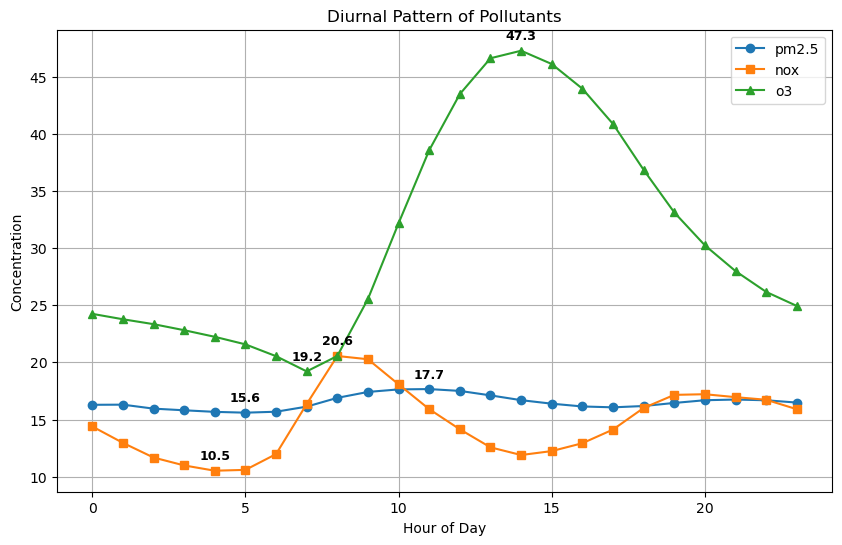

In [6]:
plot_diurnal_pattern(hourly_avg, pollutants)

### Nhận xét về biến động theo giờ trong ngày:

#### NOx (Màu Cam – Ô nhiễm sơ cấp, chủ yếu từ giao thông)
- Thể hiện **hai đỉnh rõ rệt**, đặc trưng cho các giờ cao điểm giao thông  
- **Đỉnh buổi sáng:** ~20.6 vào khoảng 8:00–9:00  
- **Đỉnh buổi tối:** ~17.0–17.3 vào khoảng 19:00–21:00  
- **Nồng độ thấp nhất:** ~10.5 vào rạng sáng (khoảng 4:00–5:00)  

**Nhận xét:** Mức NOx buổi sáng cao hơn buổi tối, phản ánh cường độ giao thông buổi sáng mạnh hơn.


#### O₃ (Màu Xanh Lá – Ô nhiễm thứ cấp)
- Có **một đỉnh duy nhất** vào giữa ngày  
- **Nồng độ cực đại:** ~47.3 tại khoảng 14:00  
- **Nồng độ thấp nhất:** ~19.2 vào rạng sáng (khoảng 6:00)  
- Sự hình thành O₃ gắn liền với **các phản ứng quang hóa dưới bức xạ mặt trời**, sử dụng các tiền chất NOx và VOCs  

**Giải thích:** O₃ thấp vào rạng sáng do thiếu bức xạ mặt trời và hiện tượng *NO titration* làm tiêu hao O₃.


#### PM2.5 (Màu Xanh Dương)
- Biến động trong **biên độ hẹp**, dao động khoảng 15.6–17.7  
- Xuất hiện **hai đỉnh nhẹ**:
  - **Buổi sáng:** ~17.7 vào khoảng 10:00–11:00  
  - **Buổi tối:** ~16.9–17.0 vào khoảng 20:00–22:00  
- Phản ánh **nguồn phát thải đa dạng**, bao gồm giao thông, sinh hoạt và nền khu vực


### Tổng hợp
- NOx đạt cực đại vào các **giờ cao điểm giao thông**, đặc biệt là buổi sáng  
- O₃ đạt đỉnh vào **giữa trưa – đầu giờ chiều** khi điều kiện bức xạ mặt trời thuận lợi  
- PM2.5 tương đối **ổn định**, cho thấy ảnh hưởng của cả nguồn phát thải tại chỗ và nền khu vực  

### Kết luận
Ô nhiễm sơ cấp (**NOx**) chịu chi phối mạnh bởi **hoạt động giao thông và hành vi con người**, trong khi ô nhiễm thứ cấp (**O₃**) phụ thuộc chủ yếu vào **điều kiện khí tượng và bức xạ mặt trời**.

### 2. Weekly Pattern – Biến động theo ngày trong tuần 

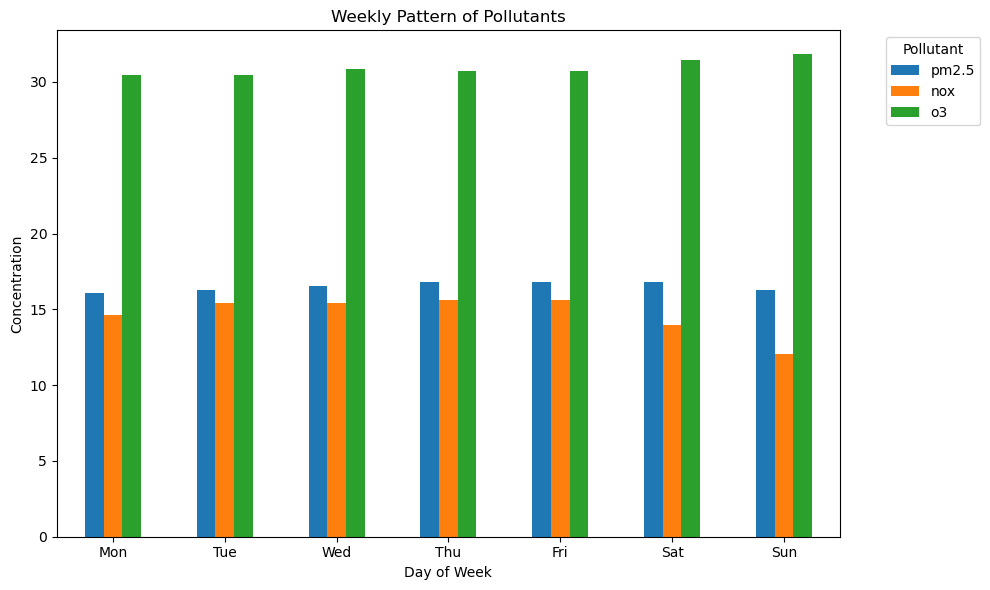

In [7]:
plot_weekly_pattern(weekly_avg, pollutants)

### Nhận xét về biến động theo ngày trong tuần:
Biểu đồ thể hiện sự biến động trung bình theo **ngày trong tuần** của ba chất ô nhiễm: **PM2.5, NOx và O₃**.  

#### NOx – Ô nhiễm giao thông (màu cam)

- Cao và ổn định trong các ngày làm việc (**Thứ 2–Thứ 6**), dao động quanh **~15–16**
- Giảm rõ rệt vào cuối tuần, đặc biệt **Chủ Nhật (~12)**

Điều này phản ánh rất rõ **nguồn phát thải giao thông và hoạt động công nghiệp**, vốn giảm mạnh vào cuối tuần.

#### PM2.5 – Bụi mịn (màu xanh dương)

- Biến động nhỏ, tương đối ổn định suốt tuần (**~16–17**)
- Không có sự sụt giảm mạnh vào cuối tuần như NOx

Cho thấy **PM2.5 có nguồn phát thải đa dạng**: không chỉ từ giao thông mà còn từ công nghiệp nền, đốt nhiên liệu, bụi thứ cấp và điều kiện khí tượng.


#### O₃ – Ô nhiễm thứ cấp (màu xanh lá)

- Có xu hướng **tăng nhẹ về cuối tuần**, cao nhất vào **Thứ 7–Chủ Nhật (~31–32)**

Đây là **hiệu ứng cuối tuần (Weekend Effect)**:
- NOx giảm -> giảm hiện tượng *NO titration* (NO tiêu thụ O₃) ($\text{NO} + \text{O}_3 \rightarrow \text{NO}_2 + \text{O}_2$.)
- O₃ tồn tại lâu hơn và tích tụ nhiều hơn

#### 4. Tổng hợp & Diễn giải

- **Ngày làm việc**:  
  - NOx cao -> chi phối bởi giao thông
- **Cuối tuần**:
  - NOx giảm mạnh  
  - PM2.5 gần như không đổi  
  - O₃ tăng nhẹ  
-> **Không khí cuối tuần không đồng nghĩa là sạch hơn**, đặc biệt khi xét theo O₃.

#### Kết luận

- **NOx** phản ánh rõ chu kỳ hoạt động của con người  
- **O₃** chịu ảnh hưởng mạnh bởi cơ chế hóa học khí quyển, không giảm theo giao thông  
- **PM2.5** mang tính nền và tích tụ, ít nhạy với chu kỳ tuần

### 3. Seasonal Pattern – Biến động theo mùa

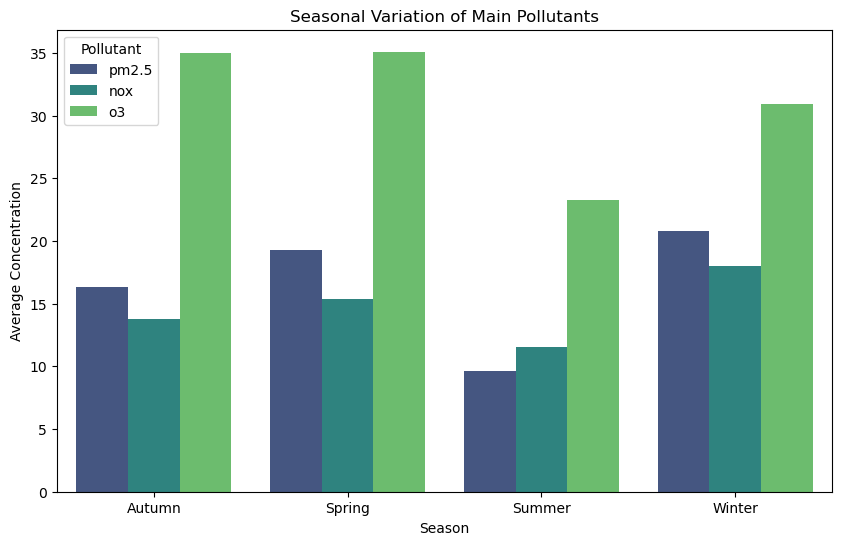

In [8]:
plot_seasonal_pattern(season_melted)

### Nhận xét về biến động theo mùa:

#### PM2.5 (Màu Xanh Đậm)

- **Nồng độ trung bình theo mùa:**
  - Mùa Đông: ~20.8 (cao nhất)
  - Mùa Hè: ~9.6 (thấp nhất)
  - Mùa Thu & Xuân: khoảng 16–19

- **Nhận xét:**
  - PM2.5 tăng vào mùa Đông do điều kiện khí tượng bất lợi (ít gió, nghịch nhiệt, tán phát thấp) và gia tăng sưởi ấm, hoạt động sinh hoạt.
  - Mùa Hè thấp nhất nhờ khí hậu nóng, gió và mưa làm loãng và rửa trôi bụi.

#### NOx (Màu Xanh Lơ)

- **Nồng độ trung bình theo mùa:**
  - Mùa Đông: ~18 (cao nhất)
  - Mùa Hè: ~11-12(thấp nhất)
  - Trung bình: Mùa Thu ~14 và Mùa Xuân ~15.

- **Nhận xét:**
  - NOx chịu chi phối bởi hoạt động giao thông và phát thải từ nhiên liệu.
  - Mùa Đông tăng do khí tượng hạn chế khuếch tán và có thể do sưởi ấm, đốt nhiên liệu.
  - Mùa Hè: Nồng độ thấp nhất nhờ bức xạ nhiệt mạnh và đối lưu không khí tốt giúp pha loãng khí thải nhanh chóng.

#### O₃ (Màu Xanh Lá)

- **Nồng độ trung bình theo mùa:**
  - Mùa Thu & Xuân: ~35 (cao nhất)
  - Mùa Hè: ~23 (thấp nhất)

- **Nhận xét:**
  - O₃ là ô nhiễm thứ cấp, phụ thuộc quang hóa dưới ánh sáng mặt trời và tiền chất NOx/VOCs.
  - Mùa Hè tuy nhiều nắng nhưng NOx thấp, quá trình titration mạnh vào ban đêm → O₃ trung bình giảm.
  - Mùa Thu và Xuân: điều kiện ánh sáng + tiền chất thuận lợi → O₃ tăng cao.
  - Mùa Đông: O₃ trung bình ~31, thấp hơn Thu/Xuân do thiếu bức xạ và titration mạnh từ NOx.

#### Kết luận

- **PM2.5 và NOx:** cao vào mùa Đông → ô nhiễm sơ cấp bị chi phối bởi nguồn phát thải và khí tượng mùa lạnh.
- **O₃:** cao vào mùa Xuân và Thu → ô nhiễm thứ cấp bị chi phối bởi bức xạ mặt trời và tiền chất hóa học.
- **Mùa Hè:** PM2.5 và NOx thấp, O₃ thấp do khuếch tán tốt nhưng titration ban đêm mạnh.

### 4. Tổng kết

#### Thời điểm nguy hiểm nhất trong ngày

- **8:00–9:00 sáng:** NOx đạt cực đại buổi sáng do giao thông giờ cao điểm; PM2.5 bắt đầu tăng → rủi ro cao với ô nhiễm sơ cấp.

- **19:00–21:00 tối:** NOx đạt đỉnh buổi tối; PM2.5 tăng nhẹ do giao thông và sinh hoạt.

- **Khoảng 14:00:** O₃ đạt cực đại trong ngày do các phản ứng quang hóa dưới bức xạ mặt trời.

#### Biến động theo tuần
- **Ngày làm việc (Thứ 2–Thứ 6):** NOx cao, PM2.5 ổn định, O₃ trung bình.  
- **Cuối tuần:** NOx giảm mạnh, PM2.5 gần như không đổi, O₃ tăng nhẹ (**Weekend Effect**).  
-> Không khí cuối tuần không đồng nghĩa là “sạch” hơn, đặc biệt khi xét O₃.

#### Biến động theo mùa
- **Mùa Đông:** PM2.5 và NOx cao → cảnh giác đặc biệt với ô nhiễm sơ cấp.  
- **Mùa Xuân & Thu:** O₃ cao → cần lưu ý ô nhiễm thứ cấp, đặc biệt với người nhạy cảm.  
- **Mùa Hè:** PM2.5 và NOx thấp, O₃ trung bình thấp do khuếch tán tốt nhưng titration ban đêm vẫn ảnh hưởng.

#### Kết luận tổng thể
- **Ô nhiễm sơ cấp (NOx, PM2.5):** chủ yếu chịu chi phối bởi nguồn phát thải và khí tượng, phản ánh rõ hoạt động con người và mùa lạnh.  
- **Ô nhiễm thứ cấp (O₃):** phụ thuộc vào cơ chế quang hóa và tiền chất hóa học, tăng cao khi NOx giảm hoặc điều kiện ánh sáng thuận lợi.  
- **Khuyến nghị:** Cần điều chỉnh chính sách kiểm soát phát thải theo giờ, ngày trong tuần và mùa, đồng thời cung cấp khuyến nghị chi tiết cho người dân để giảm thiểu tác động sức khỏe.


# Câu hỏi 2: Phân tích các đợt ô nhiễm kéo dài (Pollution Episodes)

### 1. Câu hỏi
- Thay vì chỉ đếm số ngày ô nhiễm riêng lẻ, ta xác định các **"đợt ô nhiễm"**
  - Định nghĩa: khoảng thời gian mà **AQI vượt ngưỡng nguy hại** (> 100) liên tục **ít nhất 48 giờ**  
- Trạm nào thường xuyên phải chịu các **đợt ô nhiễm kéo dài nhất**?  
- Có **quy luật mùa vụ** nào cho độ dài của các đợt này không?  
  - Ví dụ: Mùa đông các đợt ô nhiễm thường kéo dài hơn mùa hè do nghịch nhiệt.

### 2. Động lực và lợi ích

#### Tại sao nghiên cứu
- Một ngày ô nhiễm cao có thể do sự cố cục bộ, nhưng **đợt ô nhiễm kéo dài 3–5 ngày** thường liên quan đến **điều kiện khí tượng vĩ mô** hoặc **tích tụ ô nhiễm nghiêm trọng**  
- **Tác hại sức khỏe** khi hít thở không khí bẩn liên tục nguy hiểm hơn nhiều so với ngắt quãng

#### Lợi ích
- Giúp **cơ quan y tế chuẩn bị nguồn lực** cho các đợt bùng phát bệnh hô hấp kéo dài

#### Đối tượng quan tâm
- **Bệnh viện**  
- **Cơ quan quản lý khẩn cấp**

#### Ứng dụng thực tế
- Cung cấp thông tin để **phát cảnh báo**:  

## A. Preprocessing

### A.1 Written Explanation

Để xác định các đợt ô nhiễm (**AQI > 100 liên tục ≥ 48 giờ**), chúng tôi thực hiện các bước tiền xử lý sau:

#### 1. Đánh dấu thời điểm ô nhiễm
- Tạo cột boolean **polluted = True** nếu **AQI > 100**

#### 2. Nhóm các đợt liên tục
- Đánh dấu sự thay đổi trạng thái bằng **cumsum** để gom các khoảng thời gian liên tục cùng trạng thái  
- Tính **duration_hours** cho từng nhóm

#### 3. Lọc đợt ô nhiễm
- Chỉ giữ các nhóm **polluted=True** có thời gian **≥ 48 giờ**

#### 4. Thêm thông tin mùa vụ
- Chuyển tháng từ cột **start** sang mùa (**Winter, Spring, Summer, Autumn**) để phân tích mùa vụ
### A.2 Code Implementation

In [9]:
# 1. Đánh dấu giờ ô nhiễm
THRESHOLD_AQI = 100
df['polluted'] = df['aqi'] > THRESHOLD_AQI  # Giờ nào AQI vượt ngưỡng 100 được coi là ô nhiễm

# 2. Xác định các đợt ô nhiễm liên tục theo trạm quan trắc
#def identify_episodes

episodes_by_station = df.groupby('sitename').apply(identify_episodes).reset_index(level=1, drop=True).reset_index()

episodes_by_station['season'] = episodes_by_station['start'].dt.month.apply(month_to_season)

# Xem mẫu kết quả
episodes_by_station.head()

,sitename,start,end,duration_hours,season
0,Annan,2016-12-17 21:00:00,2016-12-21 14:00:00,89.0,Winter
1,Annan,2017-02-10 02:00:00,2017-02-12 15:00:00,61.0,Winter
2,Annan,2017-02-18 06:00:00,2017-02-20 13:00:00,55.0,Winter
3,Annan,2017-03-03 08:00:00,2017-03-05 14:00:00,54.0,Spring
4,Annan,2017-03-28 16:00:00,2017-03-31 13:00:00,69.0,Spring


## B. Analysis

### B.1 Written Explanation

**Mục tiêu:** Xác định trạm nào thường xuyên chịu các đợt ô nhiễm kéo dài và quy luật mùa vụ.

#### Phân tích

##### Theo trạm (sitename)
- Tính:
  - **num_episodes** – số đợt ô nhiễm ≥ 48 giờ
  - **avg_duration** – thời gian trung bình mỗi đợt
  - **max_duration** – đợt dài nhất
- **Mục tiêu:** xác định trạm “nguy cơ cao” (các trạm có trên 10 đợt ô nhiễm)

##### Theo mùa
- Gom các đợt theo **season**
- Tính:
  - Số đợt
  - Thời gian trung bình
  - Thời gian dài nhất
- **Mục tiêu:** phát hiện mùa nào thường xảy ra đợt ô nhiễm dài (ví dụ: mùa đông do nghịch nhiệt)

#### Kết quả dự kiến
- Bảng thống kê **số lượng, thời lượng trung bình và tối đa** theo trạm và mùa
- Biểu đồ **cột** thể hiện **thời lượng trung bình theo trạm/mùa**

### B.2 Code Implementation

In [10]:
# 1. Summary theo trạm
station_summary = episodes_by_station.groupby('sitename').agg(
    num_episodes=('duration_hours', 'count'),
    avg_duration=('duration_hours', 'mean'),
    max_duration=('duration_hours', 'max')
).sort_values('avg_duration', ascending=False)

# Chỉ giữ các trạm có trên 10 đợt ô nhiễm
station_summary_filtered = station_summary[station_summary['num_episodes'] > 10]

# Sắp xếp và lấy top 10
top10 = station_summary_filtered.sort_values(
    'avg_duration', ascending=False
).head(10)

# 2. Summary theo mùa
season_summary = episodes_by_station.groupby('season').agg(
    num_episodes=('duration_hours', 'count'),
    avg_duration=('duration_hours', 'mean'),
    max_duration=('duration_hours', 'max')
).sort_index()

# Display summaries
print("Summary by Station:\n", top10)
print("\nSummary by Season:\n", season_summary)

Summary by Station:
           num_episodes  avg_duration  max_duration
sitename                                          
Qiaotou             59     92.661017         345.0
Xiaogang            32     82.875000         196.0
Nanzi               45     82.222222         200.0
Kinmen              29     81.379310         167.0
Zuoying             36     78.666667         228.0
Qianzhen            34     78.529412         148.0
Lunbei              32     77.500000         390.0
Chaozhou            27     77.481481         202.0
Meinong             11     76.454545         117.0
Linyuan             20     76.300000         183.0

Summary by Season:
         num_episodes  avg_duration  max_duration
season                                          
Autumn           148     69.675676         390.0
Spring           260     67.630769         155.0
Summer             2     52.500000          56.0
Winter           643     75.483670         345.0


## C. Results & Interpretation

### C.1 Visualizations:
#### 1. Trạm có nguy cơ cao

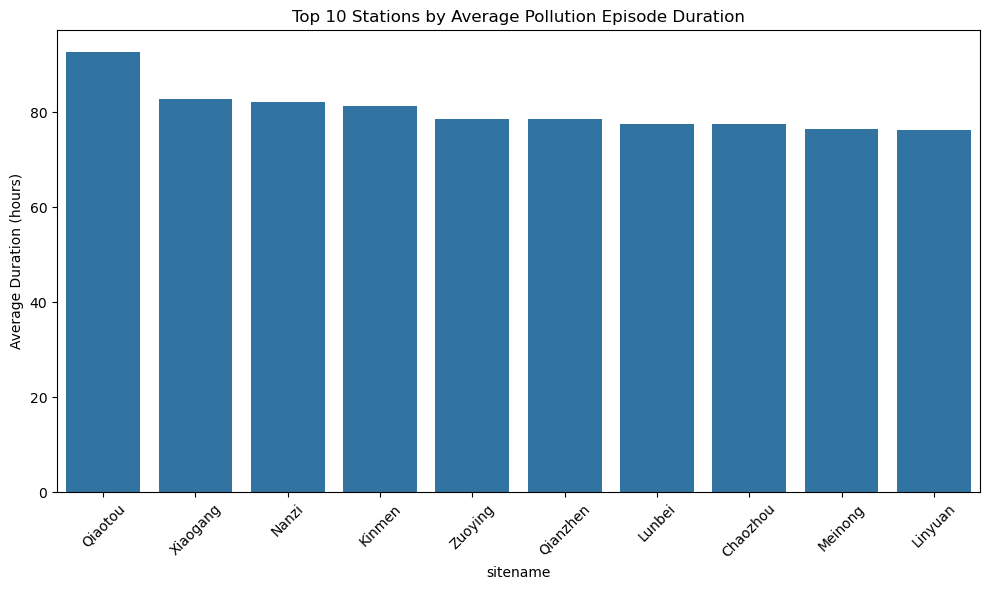

In [11]:
plot_top10_episode_duration(top10)   

##### Nhận xét về các trạm có nguy cơ cao  (Đợt ô nhiễm kéo dài)

- **Qiaotou** có thời lượng ô nhiễm trung bình cao nhất (~93 giờ) và số đợt lớn (59 đợt), cho thấy ô nhiễm xảy ra **thường xuyên và kéo dài**.

- **Xiaogang, Nanzi, Kinmen** theo sau với thời lượng trung bình khoảng **81–83 giờ**, tương đương hơn **3 ngày liên tục**.

- Các trạm còn lại trong **top 10** có thời lượng trung bình **~75–79 giờ**, vẫn là mức ô nhiễm kéo dài đáng kể.

**Kết luận:** Tất cả các trạm nguy cơ cao đều ghi nhận các đợt ô nhiễm kéo dài nhiều ngày, cho thấy ô nhiễm mang tính **liên tục**, có thể liên quan đến các nguồn phát thải **ổn định**, làm gia tăng rủi ro phơi nhiễm cho khu vực xung quanh. Việc xác định nguyên nhân cụ thể cần bổ sung thêm thông tin về **nguồn phát thải** và **điều kiện khí tượng**.

#### 2. Quy luật mùa vụ 

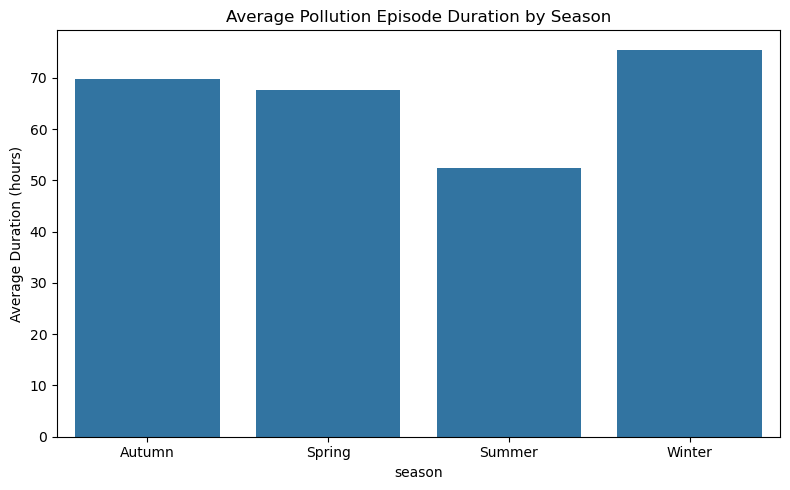

In [12]:
# 2. Thời lượng trung bình theo mùa
plot_season_episode_duration(season_summary)

#### Nhận xét về quy luật mùa vụ
##### Mùa Đông (Winter)

- **Thời lượng**: Các đợt ô nhiễm có thời lượng dài nhất, trung bình khoảng **~75.5 giờ** (hơn 3 ngày liên tục), đồng thời có **số đợt ô nhiễm cao nhất**.

- **Giải thích**: Điều kiện khí tượng mùa đông thường kém thuận lợi cho khuếch tán (ví dụ: nghịch nhiệt, gió yếu), khiến các chất ô nhiễm dễ tích tụ và kéo dài thời gian tồn tại.

##### Mùa Hè (Summer)

- **Thời lượng**: Thời lượng ô nhiễm trung bình **ngắn nhất (~52.5 giờ)**.

- **Lưu ý**: Số đợt ô nhiễm ghi nhận trong mùa hè **rất ít (2 đợt)**, do đó kết quả chỉ mang tính tham khảo.

- **Giải thích**: Xu hướng thời lượng ngắn có thể liên quan đến các điều kiện khí tượng thuận lợi như đối lưu mạnh, mưa và gió, giúp làm sạch không khí nhanh hơn.

##### Mùa Xuân (Spring) và Mùa Thu (Autumn)

- **Thời lượng**: Hai mùa này có thời lượng ô nhiễm trung bình tương đối cao và gần nhau, khoảng **~66–70 giờ**.

- **Giải thích**: Đây là các giai đoạn chuyển tiếp khí tượng, với điều kiện phân tán ô nhiễm ở mức trung gian giữa mùa hè và mùa đông.


#### 3. Ứng dụng thực tiễn

- **Cảnh báo y tế**: Tăng cường phát cảnh báo sức khỏe cho cư dân tại các khu vực nguy cơ cao, đặc biệt trong **mùa đông**.

- **Điều phối y tế**: Chủ động tăng cường nhân lực và giường bệnh hô hấp tại các khu vực có trạm thuộc **top nguy cơ trong mùa đông**.

- **Chiến lược giảm phát thải**: Ưu tiên kiểm soát các nguồn phát thải liên tục (khu công nghiệp, khu chế xuất), đặc biệt trong các giai đoạn ô nhiễm kéo dài.

#### 4. Hạn chế

- Dữ liệu có thể bị **thiếu giờ quan trắc**, ảnh hưởng đến việc xác định chính xác thời lượng các đợt ô nhiễm.
- **Mạng lưới trạm đo chưa bao phủ toàn bộ khu vực**, do đó mức độ ô nhiễm tại các vị trí không có trạm có thể khác với kết quả phân tích.


# Câu hỏi 3: Nếu nguồn lực quan trắc hạn chế, nên ưu tiên giám sát chất ô nhiễm nào (2–3 chất) để phản ánh rủi ro AQI hiệu quả nhất?

## 1. The Question
Trong điều kiện chỉ có thể triển khai **2–3 cảm biến** vì hạn chế ngân sách/vận hành, **những chất ô nhiễm nào** nên được ưu tiên giám sát để **phản ánh rủi ro AQI** hiệu quả và ổn định nhất trên dữ liệu quan trắc (2016–2024)?
Chúng tôi đánh giá từng chất theo 3 tiêu chí đo lường được:

- **(T1) Correlation với AQI:** chất nào có tương quan mạnh với `aqi` (Pearson + Spearman)?
- **(T2) Status separation:** nồng độ chất đó có tăng/giảm có trật tự theo các mức `status` (Good → … → Hazardous) hay không?
- **(T3) Across-site consistency:** mối liên hệ với `aqi` có ổn định trên nhiều `siteid` hay chỉ mạnh ở một vài trạm?

> Lưu ý: các biến dạng `*_avg` hoặc `*_8hr` là biến tổng hợp theo chuẩn AQI (đại diện tín hiệu theo cửa sổ thời gian). Khuyến nghị cuối cùng sẽ quy về **chất cần lắp cảm biến** (PM2.5/PM10/CO/…).

## 2. Motivation & Benefits
Nhiều địa phương không thể lắp đủ cảm biến cho tất cả chất ô nhiễm. Việc chọn đúng 2–3 chất ưu tiên sẽ:
- **tối ưu chi phí quan trắc** và công bảo trì,
- **nâng hiệu quả cảnh báo sức khỏe cộng đồng**,
- và biến kết quả EDA thành **đề xuất vận hành thực tiễn** (triển khai cảm biến “đúng chỗ, đúng chất”).

> Phân tích trong câu hỏi này nhằm chọn **chất phản ánh rủi ro AQI tốt** (proxy). Đây là phân tích theo quan sát dữ liệu, **không suy diễn quan hệ nhân quả**.

## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation

Trước khi phân tích Câu 3, cần chuẩn bị dữ liệu để đảm bảo các phép đo “độ liên hệ” giữa **AQI** và các **chất ô nhiễm** là đáng tin cậy và chạy được ổn định trên dữ liệu lớn.

1) **Xác định biến mục tiêu (target)**
- Chọn `aqi` làm biến mục tiêu vì đây là chỉ số tổng hợp phản ánh mức rủi ro chất lượng không khí.

2) **Chuẩn hoá danh sách biến ứng viên (candidate pollutants)**
- Dữ liệu có thể chứa nhiều phiên bản của cùng một chất (ví dụ: cột **raw** theo giờ và cột **aggregate** như `*_avg` hoặc `*_8hr`).
- Vì vậy, tạo `candidate_cols` gồm cả **aggregate + raw** để không bỏ sót tín hiệu quan trọng (PM2.5, PM10, O3, CO, SO2, NO2/NO/NOx,…).

3) **Lọc chỉ các cột thực sự tồn tại trong dataset**
- Không phải dataset nào cũng có đủ tất cả cột trong danh sách ứng viên.
- Do đó dùng bước: `candidate_cols = [c for c in candidate_cols if c in df.columns]`
  để tránh lỗi thiếu cột và đảm bảo pipeline có thể chạy trên mọi phiên bản dữ liệu.

Kết quả của bước tiền xử lý này là một danh sách `candidate_cols` “sạch” gồm các chất ô nhiễm sẵn có,
dùng trực tiếp cho phần tính toán tương quan / xếp hạng ưu tiên ở các bước tiếp theo.

### A.2 Code Implementation

In [13]:
# Chọn danh sách biến ứng viên (giữ cả aggregate + raw nếu có)
target = "aqi"
candidate_cols = [
    "pm2.5_avg", "pm10_avg", "o3_8hr", "co_8hr", "so2_avg",
    "pm2.5", "pm10", "o3", "co", "so2", "no2", "nox", "no",
]
candidate_cols = [c for c in candidate_cols if c in df.columns]

## B. Data Analysis
### B.1 Written Explanation
**Mục tiêu:** Với nguồn lực giám sát hạn chế, xác định 2-3 chất gây ô nhiễm phản ánh tốt nhất **rủi ro AQI** trong tập dữ liệu này.

Chúng tôi đánh giá từng chất gây ô nhiễm tiềm năng bằng cách sử dụng **ba tiêu chí bổ sung**:

1) **Mối tương quan với AQI (cường độ tín hiệu toàn cầu)**
- **Phương pháp:** tính toán hệ số tương quan Pearson và Spearman giữa mỗi chất gây ô nhiễm và `aqi`.

- **Lý do:** Pearson thể hiện mối liên hệ tuyến tính; Spearman thể hiện mối liên hệ đơn điệu và mạnh mẽ hơn đối với độ lệch/giá trị ngoại lệ.

- **Kết quả dự kiến:** Bảng xếp hạng các chất gây ô nhiễm theo hệ số tương quan (Pearson + Spearman).

- **Biểu đồ 1:** biểu đồ cột của k hệ số tương quan Pearson hàng đầu.

2) **Phân loại mức độ rủi ro theo trạng thái AQI (khả năng diễn giải thực tiễn)**
- **Phương pháp:** so sánh mức độ ô nhiễm giữa các nhóm `trạng thái` được sắp xếp theo thứ tự bằng cách sử dụng:

- trung vị/trung bình cho mỗi trạng thái (trung vị là yếu tố chính),

- hệ số tương quan Spearman giữa chất ô nhiễm và `status_rank`.

- **Lý do:** các trạng thái rủi ro cao rất hiếm; **trung vị** ổn định hơn trung bình khi có sự mất cân bằng/ngoại lệ.

- **Kết quả mong đợi:**  Bảng tóm tắt số lượng/trung vị/trung bình theo trạng thái; Bảng xếp hạng theo hệ số tương quan Spearman so với `status_rank`.

- **Biểu đồ 2:** biểu đồ đường trung vị theo trạng thái cho các chất ô nhiễm có tương quan cao nhất.

3) **Tính ổn định giữa các địa điểm (độ bền vững khi triển khai)**
- **Phương pháp:** tính toán hệ số tương quan Pearson giữa mỗi chất ô nhiễm và AQI **trong mỗi địa điểm** (`siteid`) đối với các địa điểm có đủ mẫu.
Tổng hợp trên các địa điểm bằng cách sử dụng:

- `median_r` (cường độ điển hình),

- `iqr_r` (biến thiên giữa các địa điểm),

- `% (r > 0,5)` (tần suất tương quan mạnh).

- **Lý do:** Một chất gây ô nhiễm chỉ hữu ích về mặt vận hành nếu mối quan hệ của nó với AQI **nhất quán giữa các trạm**, không bị chi phối bởi một vài địa điểm.

- **Kết quả mong đợi:** Bảng tóm tắt độ ổn định tại địa điểm cho mỗi chất gây ô nhiễm.

- **Biểu đồ 3:** phân bố các tương quan trên mỗi địa điểm (biểu đồ hộp) cho các ứng viên hàng đầu.

Cuối cùng, chúng tôi kết hợp bằng chứng từ (1)–(3) để đề xuất **2–3 chất gây ô nhiễm hàng đầu** cần ưu tiên.
### B.2 Code Implementation
## Tiêu chí 1 - Tương quan với AQI (Pearson + Spearman)

,variable,n,pearson_r,spearman_r
0,pm2.5_avg,5530918,0.950863,0.941724
5,pm2.5,5530918,0.856837,0.864165
1,pm10_avg,5530918,0.850972,0.855481
6,pm10,5530918,0.769217,0.790087
3,co_8hr,5530918,0.399550,0.537796
2,o3_8hr,5530918,0.353077,0.374042
10,no2,5530918,0.347314,0.382789
8,co,5530918,0.344179,0.513321
4,so2_avg,5530918,0.315435,0.334469
7,o3,5530918,0.290678,0.301118


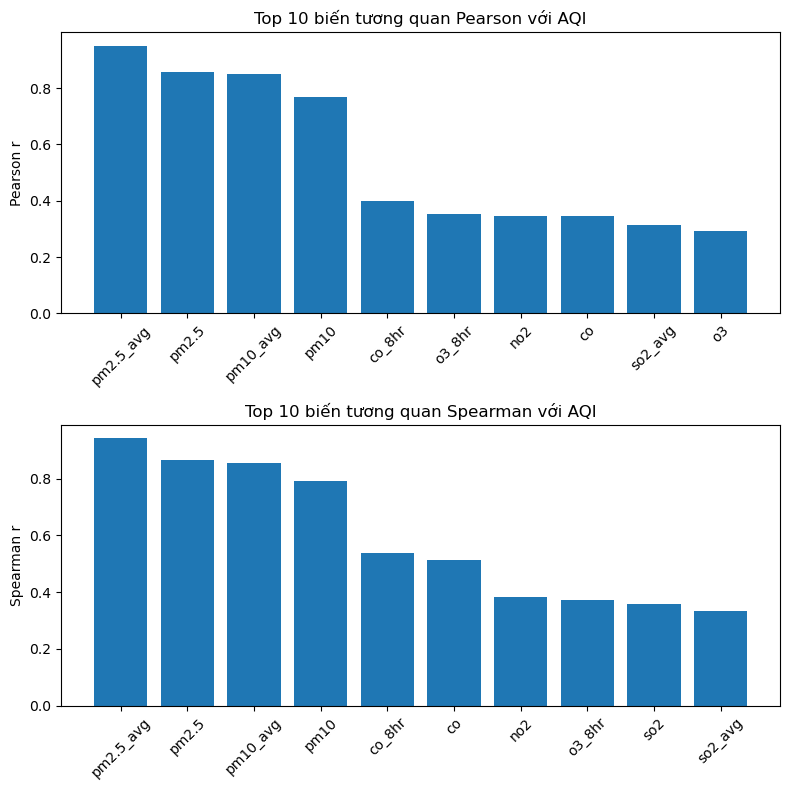

In [14]:
corr_rows = []
for col in candidate_cols:
    tmp = df[[target, col]].dropna()
    if len(tmp) < 1000:
        continue
    pearson = tmp[target].corr(tmp[col], method="pearson")
    spearman = tmp[target].corr(tmp[col], method="spearman")
    corr_rows.append({
        "variable": col,
        "n": len(tmp),
        "pearson_r": pearson,
        "spearman_r": spearman
    })

corr_df = pd.DataFrame(corr_rows).sort_values("pearson_r", ascending=False)

top_k = 10
top_pearson  = corr_df.sort_values("pearson_r", ascending=False).head(top_k)
top_spearman = corr_df.sort_values("spearman_r", ascending=False).head(top_k)

display(corr_df)  # bảng vẫn hiện bình thường trên GitHub

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

axes[0].bar(top_pearson["variable"], top_pearson["pearson_r"])
axes[0].set_title(f"Top {top_k} biến tương quan Pearson với AQI")
axes[0].set_ylabel("Pearson r")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(top_spearman["variable"], top_spearman["spearman_r"])
axes[1].set_title(f"Top {top_k} biến tương quan Spearman với AQI")
axes[1].set_ylabel("Spearman r")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Kết luận từ Tương quan với AQI (Pearson + Spearman)

#### Kết quả chính (từ `corr_df`)
Trên toàn bộ tập dữ liệu sau tiền xử lý (**n = 5,530,918** dòng cho mỗi biến), thứ hạng tương quan Pearson với `aqi` như sau:
#### Diễn giải ý nghĩa
>**(1) PM2.5 là biến “tín hiệu mạnh nhất” của rủi ro AQI**  
`pm2.5_avg` có tương quan gần như cực đại với `aqi` (r ≈ 0.95), cho thấy nếu chỉ được chọn **1 cảm biến**, PM2.5 (đặc biệt dạng average theo chuẩn AQI) là lựa chọn “đáng tiền” nhất để phản ánh mức rủi ro.

>**(2) Các biến “avg/8hr” thường mạnh hơn biến raw**  
Ví dụ: `pm2.5_avg` > `pm2.5`, `pm10_avg` > `pm10`, `co_8hr` > `co` (theo Pearson).  
Điều này hợp lý vì các biến `*_avg` / `_8hr` là dạng đã “làm mượt theo chuẩn AQI”, nên bám sát cơ chế phản ánh mức độ rủi ro hơn.

>**(3) CO có dấu hiệu quan hệ không tuyến tính / chịu ảnh hưởng ngoại lai**  
Với CO: Pearson chỉ ≈0.34 nhưng Spearman cao hơn (≈0.51)  
→ gợi ý CO có quan hệ dạng **đơn điệu nhưng không tuyến tính** (hoặc bị kéo bởi outliers/đuôi dài). Nếu xét vai trò “bổ sung” ngoài PM, CO (đặc biệt `co_8hr`) là ứng viên hợp lý để xem tiếp ở tiêu chí 2–3.

>**(4) NO gần như không giúp phản ánh AQI tổng**  
`no` có r ≈ 0.028, Spearman ≈ 0.0064 → trong dataset này, NO không phải lựa chọn tốt nếu mục tiêu là “phản ánh rủi ro AQI”.

#### Kết luận tạm thời từ Tiêu chí 1 
Nếu chỉ dựa trên tương quan với AQI, top ứng viên để ưu tiên giám sát sẽ là:

- **Ưu tiên chắc chắn:** PM2.5 (đặc biệt `pm2.5_avg`)
- **Ưu tiên tiếp theo:** PM10 (đặc biệt `pm10_avg`)
- **Nhóm cân nhắc làm cảm biến thứ 3:** `co_8hr` / `o3_8hr` / `no2`  
  (trong đó `co_8hr` nổi bật vì Spearman cao → có thể phản ánh rủi ro tốt theo hướng “tăng/giảm theo mức AQI” dù không tuyến tính)

## Tiêu chí 2 - Khả năng phân biệt theo mức rủi ro
Trong tiêu chí 2, mục tiêu là kiểm tra: **khi AQI chuyển từ Good → Hazardous thì nồng độ từng chất có thay đổi “có trật tự” và đủ rõ để phân biệt mức rủi ro hay không**. Vì các nhóm rủi ro cao thường hiếm, chúng tôi dùng **median** (ổn định hơn mean) và bổ sung **cỡ mẫu theo status** để tránh kết luận sai do nhóm hiếm.
### 2.1. Median theo `status` + biểu đồ median  

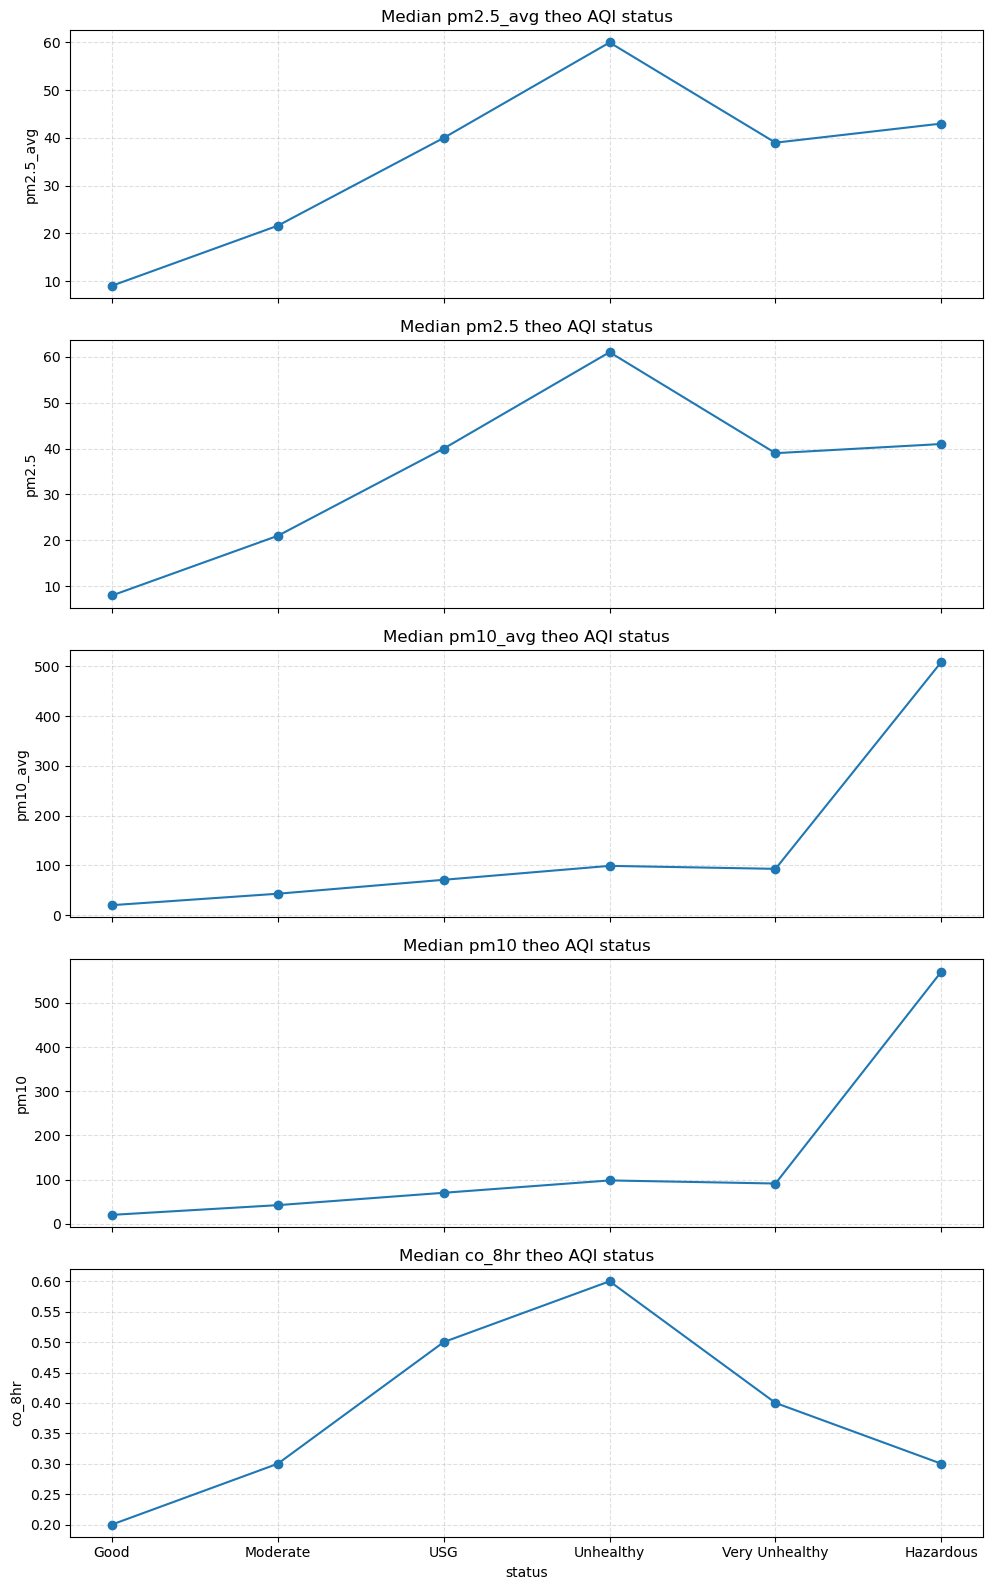

In [15]:
# 1) Thứ tự status (giữ đúng thứ tự AQI)
status_order = [
    "Good",
    "Moderate",
    "Unhealthy for sensitive groups",
    "Unhealthy",
    "Very Unhealthy",
    "Hazardous",
]
short_labels = {
    "Good": "Good",
    "Moderate": "Moderate",
    "Unhealthy for sensitive groups": "USG",
    "Unhealthy": "Unhealthy",
    "Very Unhealthy": "Very Unhealthy",
    "Hazardous": "Hazardous",
}
x_labels = [short_labels[s] for s in status_order]

# 2) Chọn 5 biến để vẽ (bạn có thể dùng corr_df.head(5) như cũ)
top_vars = ["pm2.5_avg", "pm2.5", "pm10_avg", "pm10", "co_8hr"]
top_vars = [c for c in top_vars if c in df.columns]

# 3) Ép status thành categorical ordered để groupby đúng thứ tự
df["status"] = pd.Categorical(df["status"], categories=status_order, ordered=True)

# 4) Tính median theo status cho tất cả biến một lần (rất gọn)
# Fix FutureWarning: set observed=False để giữ hành vi hiện tại của pandas
med = (
    df.groupby("status", observed=False)[top_vars]
      .median()
      .reindex(status_order)
)
plot_median_by_status_lines(med, status_order=status_order, x_labels=x_labels)

Quan sát median theo từng mức `status` (và plot median):

- **PM2.5 (pm2.5_avg / pm2.5)** tăng rõ rệt theo mức rủi ro từ Good → Moderate → USG → Unhealthy.  
    Điều này cho thấy **PM2.5 tách mức rủi ro tốt** ở các mức phổ biến (đến Unhealthy).
    Ở **Very Unhealthy/Hazardous** đường bị “gãy/không tăng tiếp”, khả năng cao do nhóm cực cao rất hiếm nên median kém ổn định.
- **PM10 (pm10_avg / pm10)** cũng tăng dần từ **Good → Unhealthy**, và đặc biệt bùng lên rất mạnh ở Hazardous.
    Điều này gợi ý **PM10 rất nhạy với các “episode bụi cực đoan” (dust events)**, nên hữu ích để bắt các đợt rủi ro rất cao.
    Tương tự, đoạn **Very Unhealthy/Hazardous** có thể dao động do hiếm mẫu.

- **CO (co_8hr)**: tăng dần đến khoảng **Unhealthy**, nhưng sau đó giảm ở **Very Unhealthy** và **Hazardous**.
  Nghĩa là **CO (8hr) không tăng đơn điệu theo status** trong toàn dải; nó phù hợp hơn như tín hiệu bổ sung (đặc biệt ở vùng rủi ro trung bình), chứ không phải “trục chính” để phân biệt toàn bộ mức AQI.

> Kết luận **Tiêu chí 2 (theo plot)**:
>- **PM2.5** là biến tách mức rủi ro **ổn định nhất** ở dải status phổ biến (Good → Unhealthy).
>- **PM10** bổ trợ mạnh cho việc bắt **rủi ro cực đoan** (Hazardous).
>- **CO_8hr** mang tính **bổ sung**, vì trend không giữ được đơn điệu ở mức rất cao.

## Tiêu chí 3: Tính ổn định theo không gian (Across-site consistency)

Trong thực tế, nếu một chất “phản ánh AQI tốt” thì mối liên hệ đó nên **ổn định ở nhiều trạm đo (siteid)**, không chỉ mạnh ở một vài nơi.  
Vì vậy, ở tiêu chí 3 chúng ta:

- Tính **Pearson correlation giữa từng chất và `aqi` riêng cho từng `siteid`** (chỉ giữ các site có đủ mẫu, `n >= 2000`).
- Sau đó tổng hợp theo từng chất bằng:
  - `median_r`: trung vị tương quan (đại diện mức liên hệ điển hình trên các site)
  - `iqr_r`: IQR của tương quan (độ dao động theo site, càng nhỏ càng ổn định)
  - `% r > 0.5`: tỷ lệ site có tương quan mạnh (thước đo “phổ quát”)

> Lưu ý: Chúng ta dùng **median + IQR** vì tương quan theo site có thể bị lệch bởi một vài trạm đặc biệt/outlier.

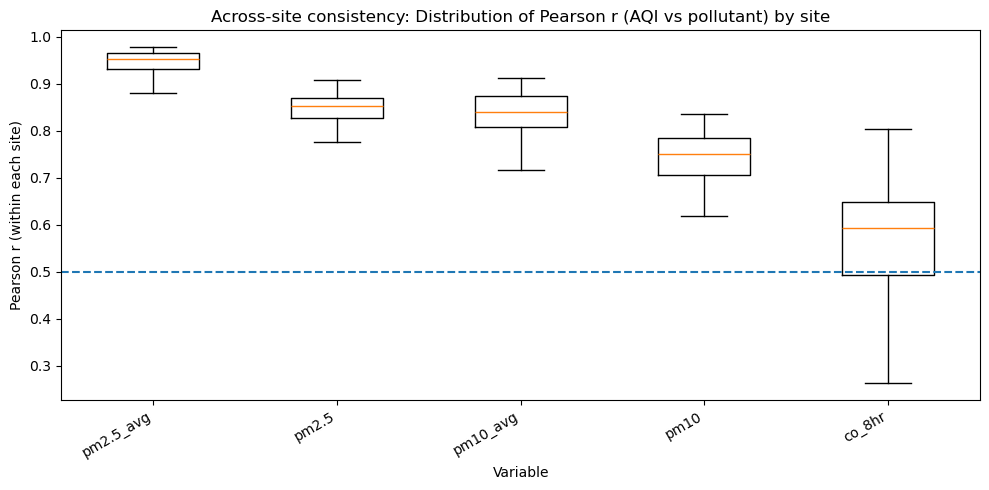

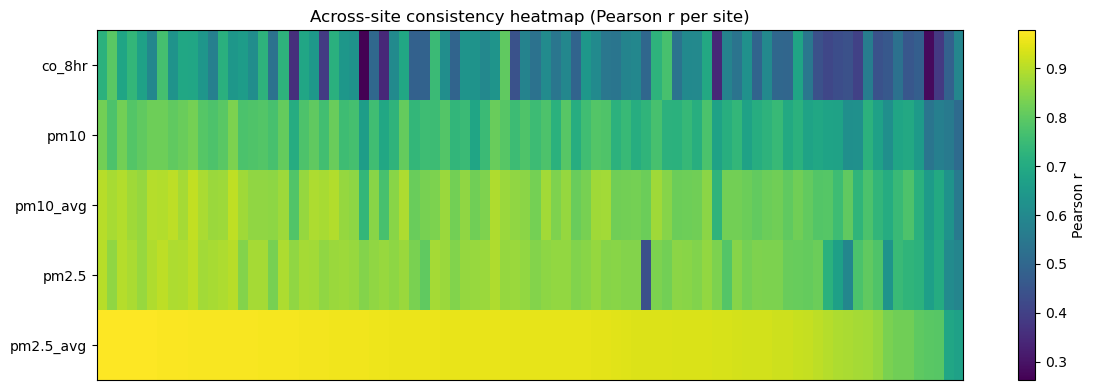

In [16]:
site_col = "siteid"
MIN_N_PER_SITE = 2000

# Chọn vài biến tiêu biểu để vẽ (gợi ý: top 5 của corr_df hoặc tự chọn)
top_vars = ["pm2.5_avg", "pm2.5", "pm10_avg", "pm10", "co_8hr"]
top_vars = [c for c in top_vars if c in df.columns]

# ===== 1) Tính Pearson r theo từng site cho từng biến (không in ra) =====
site_scores = []

# Chỉ lấy những cột cần thiết để dropna nhanh hơn
need_cols = [site_col, target] + top_vars
tmp_df = df[need_cols].dropna(subset=[site_col, target])

for col in top_vars:
    d = tmp_df[[site_col, target, col]].dropna()
    for site_id, g in d.groupby(site_col):
        if len(g) < MIN_N_PER_SITE:
            continue
        r = g[target].corr(g[col], method="pearson")
        site_scores.append({"variable": col, "siteid": site_id, "pearson_r": r})

site_scores_df = pd.DataFrame(site_scores)

# Nếu dataset có site quá ít sau lọc
if site_scores_df.empty:
    raise ValueError("Khong co site nao du mau (n>=2000) sau khi loc. Hay giam MIN_N_PER_SITE hoac kiem tra du lieu.")

plot_site_consistency_boxplot(site_scores_df, top_vars=top_vars)

pivot = site_scores_df.pivot(index="variable", columns="siteid", values="pearson_r")

# Sắp xếp site cho heatmap 
sort_ref = "pm2.5_avg" if "pm2.5_avg" in pivot.index else pivot.index[0]
site_order = pivot.loc[sort_ref].sort_values(ascending=False).index
pivot = pivot[site_order]

plot_site_consistency_heatmap(pivot)


### Nhận xét Boxplot phân bố Pearson r theo từng site
Plot A cho thấy “độ bền theo không gian” của mối liên hệ giữa AQI và từng chất (mỗi hộp là phân bố hệ số tương quan theo các trạm đo):

- **pm2.5_avg nổi bật nhất về tính ổn định**: Hộp **nằm rất cao** và **rất hẹp** (IQR nhỏ), whisker cũng ngắn → nghĩa là gần như mọi site đều cho tương quan mạnh và khá đồng nhất. Đây là dấu hiệu “đúng chất – đúng mọi nơi”: hiệu quả không phụ thuộc một vài trạm đặc biệt.

- **pm2.5 và pm10_avg cũng rất tốt, nhưng biến thiên lớn hơn pm2.5_avg**: Hai hộp vẫn **nằm cao** (đa số site mạnh), nhưng **rộng hơn** → có sự khác biệt giữa các địa điểm (vẫn ổn, nhưng không “đồng đều tuyệt đối” như pm2.5_avg). Điều này hợp lý: dữ liệu theo site khác nhau về nguồn phát thải/địa hình/khí tượng nên mức độ bám AQI có dao động.

- **pm10 yếu hơn nhóm trên về độ bền**: Median thấp hơn và hộp rộng hơn pm2.5/pm10_avg → **mối liên hệ với AQI kém “đồng nhất” hơn**. Tuy vậy, phần lớn phân bố vẫn nằm ở vùng tương quan khá tốt → PM10 vẫn là ứng viên mạnh, nhưng tính ổn định “kém hơn PM2.5”.

- **co_8hr biến thiên mạnh nhất và có site rất yếu**: Hộp **rộng**, whisker dài và có phần rơi xuống thấp hơn rõ rệt → nghĩa là **CO có nơi liên hệ với AQI khá tốt, nhưng cũng có nơi rất kém**. Nói cách khác, **CO không “phổ quát”** như PM: dùng tốt trong một số ngữ cảnh (đô thị/giao thông/đốt), nhưng không đảm bảo hiệu quả đồng đều trên mọi trạm.

- **Đường gạch (ngưỡng tham khảo)** cho thấy nhanh mức “tương quan đủ mạnh”: Nhóm PM gần như luôn vượt ngưỡng này; **co_8hr** thì có một phần đáng kể “chạm/tiệm cận/đi xuống” → củng cố kết luận CO chỉ nên là **cảm biến bổ sung**.

> Tóm lại : **PM2.5 (đặc biệt dạng avg) là ổn định nhất**, kế đến **PM10/PM10_avg**, còn **CO_8hr có tính phụ thuộc địa điểm cao**.

---

### Nhận xét Heatmap Pearson r (biến × site)
Heatmap giúp nhìn “tính phổ quát” trực quan hơn: nếu một biến mạnh và ổn định, hàng của nó sẽ **sáng đều** trên nhiều cột (nhiều site).

- **Hàng pm2.5_avg gần như sáng đồng đều trên toàn bộ các site**: Đây là dấu hiệu rõ nhất của “across-site consistency”: **không chỉ mạnh**, mà còn **đồng đều**.

- **pm2.5 và pm10_avg: phần lớn vẫn sáng, nhưng xuất hiện một vài dải tối hơn**: Điều này cho thấy đa số trạm vẫn có tương quan mạnh, tuy nhiên có **một số site/nhóm site** mà mối liên hệ giảm (có thể do đặc thù địa phương, sai khác điều kiện khuếch tán, cấu trúc nguồn thải hoặc chất lượng đo).

- **pm10 có gradient tối hơn rõ rệt so với pm10_avg**: Hàng pm10 nhìn chung “xanh hơn” (kém sáng hơn) → mức bám AQI **kém ổn định hơn** so với biến tổng hợp (avg). Đây cũng là lý do trong triển khai thực tế, PM10 có thể tốt để bắt “episode bụi”, nhưng độ đồng đều theo site không bằng PM2.5.

- **co_8hr là hàng “loang lổ” nhất**: Xen kẽ vùng sáng–tối theo site → khẳng định mạnh rằng CO **không ổn định theo không gian**: có nơi đóng vai trò mạnh, có nơi gần như không phản ánh AQI tốt.

- **Vì các site được sắp theo mức mạnh của biến tham chiếu**, nên ở phía cuối heatmap (một nhóm site) các hàng có xu hướng tối hơn: Điều này cho thấy **có những cụm trạm mà tất cả biến đều “bám AQI kém hơn”**, nhưng mức suy giảm của CO rõ nhất, còn PM2.5_avg vẫn giữ được độ sáng tương đối tốt.

---

### Kết luận từ 2 plot
- **PM2.5 là lựa chọn “an toàn và phổ quát” nhất** vì vừa mạnh vừa ổn định trên gần như mọi site.  
- **PM10 (hoặc PM10_avg)** là lựa chọn thứ hai hợp lý để bổ sung, nhất là để bắt các tình huống bụi mạnh.  
- **CO_8hr** nên được xem là **cảm biến thứ ba tùy bối cảnh** (đặc thù giao thông/đốt cháy), vì tính ổn định theo site kém hơn rõ rệt so với nhóm PM.


## C. Results & Interpretation 

Mục tiêu của Câu hỏi 3 là đưa ra một khuyến nghị **có thể triển khai được trong thực tế**: nếu chỉ có thể lắp **2–3 cảm biến**, thì nên chọn chất nào để phản ánh rủi ro AQI **mạnh – dễ diễn giải – và bền vững giữa các trạm**. Ba tiêu chí (T1–T3) đã cung cấp ba “lớp bằng chứng” khác nhau và kết quả cuối cùng **hội tụ nhất quán** về cùng một nhóm biến.

---

### (1) Tín hiệu toàn cục: PM2.5 là “proxy” mạnh nhất của AQI (Tiêu chí 1)
Trong toàn bộ tập dữ liệu sau tiền xử lý (hơn **5.5 triệu** quan sát), **pm2.5_avg** có tương quan với AQI gần như cực đại (**Pearson ≈ 0.95, Spearman ≈ 0.94**). Đây là dấu hiệu rất mạnh cho thấy: **nếu buộc phải chọn 1 cảm biến duy nhất để đại diện rủi ro AQI, PM2.5 là lựa chọn “đáng tiền” nhất**.

Ngoài ra, **PM10 (đặc biệt pm10_avg)** cũng nằm trong nhóm tương quan cao (xếp ngay sau PM2.5), trong khi các khí như **CO, NO2, O3** chỉ đạt mức tương quan trung bình hoặc yếu hơn đáng kể. Đặc biệt, **NO gần như không liên hệ với AQI** trong tập dữ liệu này, nên không phù hợp làm biến “đại diện rủi ro”.

> Diễn giải: **PM2.5 và PM10 là hai tín hiệu bám sát AQI nhất khi nhìn ở quy mô toàn bộ dữ liệu**.

---

### (2) Khả năng “tách mức rủi ro”: PM2.5 ổn định nhất trong dải status; PM10 nhạy với cực trị (Tiêu chí 2)
Các biểu đồ median theo **status** cho thấy:

- **PM2.5 (avg và raw)** tăng rõ rệt và “có trật tự” từ **Good → Moderate → USG → Unhealthy**.  
  Điều này quan trọng vì đây là những mức xuất hiện thường xuyên nhất trong dữ liệu: PM2.5 giúp **phân biệt rủi ro một cách ổn định ở vùng mà hệ thống cảnh báo hoạt động nhiều nhất**.

- **PM10 (avg và raw)** cũng tăng dần theo status và có xu hướng **bùng mạnh ở Hazardous**, gợi ý PM10 đặc biệt hữu ích để **bắt các “episode bụi cực đoan”** (dust events) – đúng với vai trò thực tế của PM10.

- **CO_8hr** tăng đến khoảng Unhealthy nhưng không giữ được xu hướng tăng đơn điệu ở các mức rất cao (Very Unhealthy/Hazardous). Điều này cho thấy CO **không phải trục chính để phân tách toàn bộ dải rủi ro**, nhưng vẫn có giá trị như **tín hiệu bổ sung** trong một số bối cảnh.

> Diễn giải: **PM2.5 là biến “tách rủi ro” tốt và ổn định nhất ở dải phổ biến; PM10 bổ sung mạnh cho các đợt cực trị. CO phù hợp hơn ở vai trò phụ trợ.**

---

### (3) Tính bền vững khi triển khai: PM2.5_avg “đúng ở mọi nơi”, CO phụ thuộc địa điểm (Tiêu chí 3)
Hai plot across-site (boxplot + heatmap) cung cấp bằng chứng mang tính “triển khai thực tế”:

- **pm2.5_avg** không chỉ mạnh mà còn **đồng đều giữa các trạm**: boxplot cao và hẹp, heatmap sáng gần như toàn hàng → nghĩa là **mối liên hệ với AQI bền vững và không bị chi phối bởi một vài site đặc biệt**.
- **pm2.5 và pm10_avg** vẫn rất tốt nhưng có dao động theo site nhiều hơn pm2.5_avg → vẫn triển khai ổn, nhưng “độ đồng đều” kém hơn một chút.
- **co_8hr** thể hiện tính “loang lổ”: có nơi tốt, có nơi rất yếu → nghĩa là **nếu chọn CO làm cảm biến chính, hiệu quả sẽ phụ thuộc mạnh vào địa điểm**.

> Diễn giải: **PM2.5 (đặc biệt dạng avg) là lựa chọn an toàn nhất khi mở rộng triển khai nhiều trạm; CO chỉ nên chọn khi mục tiêu/địa bàn thật sự phù hợp.**

---

## Khuyến nghị cuối cùng (tổng hợp T1–T3)
### Nếu chỉ lắp 2 cảm biến (khuyến nghị cốt lõi)
1) **PM2.5** (ưu tiên **pm2.5_avg** nếu cần dạng đại diện theo chuẩn)  
2) **PM10** (ưu tiên **pm10_avg**)

→ Đây là cặp **mạnh nhất – ổn định nhất – có ý nghĩa vận hành rõ ràng**: PM2.5 phản ánh rủi ro “nền” ổn định, PM10 hỗ trợ bắt các đợt bụi mạnh/cực đoan.

### Nếu lắp được cảm biến thứ 3 (tùy ngữ cảnh)
3) **CO (ưu tiên co_8hr)** như **tín hiệu bổ sung**: Hữu ích ở những khu vực thiên về giao thông/đốt cháy, nhưng không phải lựa chọn “phổ quát” như PM vì độ ổn định theo site kém hơn.

---

### Lưu ý diễn giải
Kết quả trên là **phân tích dựa trên quan sát và tương quan** nhằm chọn biến “proxy” phản ánh rủi ro AQI hiệu quả trong dataset này; **không khẳng định quan hệ nhân quả**. Tuy nhiên, việc ba tiêu chí độc lập cùng hội tụ vào PM2.5/PM10 cho thấy khuyến nghị này **rất vững** và có tính ứng dụng cao khi nguồn lực quan trắc bị giới hạn.

---
# Câu 4: “Gió có ‘giúp sạch không khí’ không? Tốc độ gió và hướng gió ảnh hưởng thế nào đến AQI, và có ngưỡng windspeed làm AQI giảm rõ rệt không?”
### 1. The Question
Trong dữ liệu quan trắc theo giờ (2016–2024) tại Đài Loan, **gió** có thực sự “giúp làm sạch không khí” hay đôi khi có thể **làm AQI xấu đi**?

Cụ thể, chúng ta trả lời 3 ý chính:

1) **Tốc độ gió (windspeed) và AQI**
- Khi windspeed tăng, AQI có xu hướng **giảm** (gió mạnh → khuếch tán ô nhiễm) hay **không rõ ràng**?
- Có tồn tại một **ngưỡng windspeed \(t\) (m/s)** mà khi vượt qua thì AQI **giảm rõ rệt** (ví dụ: giảm median/mean AQI, hoặc giảm xác suất rơi vào các mức status xấu)?

2) **Hướng gió (winddirec) và AQI**
- AQI có khác biệt đáng kể giữa các **nhóm hướng gió** (ví dụ 8 hoặc 16 hướng) không?
- Có “**hướng gió rủi ro**” (thường gắn với AQI cao hơn) và “**hướng gió thuận lợi**” (AQI thấp hơn) không?

3) **Tính ổn định theo không gian**: Các kết luận trên (xu hướng theo windspeed, ngưỡng \(t\), và nhóm hướng gió rủi ro) có **ổn định theo county/site** hay chỉ đúng ở một số khu vực?

---

### 2. Motivation & Benefits
**Động cơ thực tiễn:** Trong quản lý chất lượng không khí, gió được xem là cơ chế “khuếch tán tự nhiên”: gió yếu dễ gây tích tụ ô nhiễm, còn gió mạnh có thể giúp phân tán. Tuy nhiên, **hướng gió** có thể mang ô nhiễm từ nơi khác vào, nên cùng một tốc độ gió nhưng tác động lên AQI có thể khác nhau theo hướng.

**Lợi ích kỳ vọng:**
- **Cảnh báo sớm rủi ro:** đưa ra kết luận dạng “khi **windspeed < x m/s** thì rủi ro AQI xấu **cao hơn rõ**”, hỗ trợ nhận diện các “low-wind episodes”.
- **Insight theo hướng gió:** xác định các **hướng gió rủi ro/thuận lợi** để hỗ trợ truyền thông rủi ro và điều hành giám sát theo điều kiện khí tượng.
- **Độ tin cậy cho vận hành:** kiểm tra tính **ổn định theo county/site** để biết kết luận có thể áp dụng rộng rãi hay chỉ mang tính cục bộ.
- **Giá trị cho đồ án:** không chỉ mô tả tương quan mà còn tìm **ngưỡng/breakpoint** và kiểm chứng theo không gian, giúp kết luận “có thể hành động” (actionable).
## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation
Trước khi phân tích mối liên hệ giữa **gió** và **AQI/rủi ro status xấu**, ta cần chuẩn hoá dữ liệu để các bước vẽ biểu đồ và tính toán sau đó nhất quán và không bị lỗi do thiếu cột/kiểu dữ liệu.

1) **Xác định biến mục tiêu (target)**: Dùng `aqi` làm biến mục tiêu vì đây là chỉ số tổng hợp phản ánh mức độ rủi ro chất lượng không khí.

2) **Tự động nhận diện cột gió**
- Dataset có thể đặt tên cột gió khác nhau (ví dụ `windspeed`, `ws`, `winddirec`, `wd`…).
- Ta dò theo danh sách tên ứng viên để tìm:
  - `wind_speed_col`: cột tốc độ gió (bắt buộc phải có)
  - `wind_dir_col`: cột hướng gió (nếu có thì dùng, không có thì bỏ qua các phân tích theo hướng)

3) **Chuẩn hoá thông tin status**
- Cột `status`, chuẩn hoá theo đúng thứ tự mức độ xấu (`Good → Hazardous`) để:
  - tạo `status_rank` (mức độ tăng dần)
  - tạo `is_bad` (1 nếu status thuộc nhóm USG+ trở lên, 0 nếu Good/Moderate)
- Các biến này giúp đo “rủi ro” bằng xác suất `P(status xấu)` trong các tiêu giải tiếp theo.

4) **Chọn các cột vùng/địa điểm nếu tồn tại**: Nếu có `county`, `sitename`, `siteid` thì giữ lại để hỗ trợ phân tầng hoặc mô tả theo khu vực.

5) **Làm sạch kiểu dữ liệu và lọc giá trị không hợp lệ**
- Ép `aqi`, `windspeed`, `wind direction` về dạng số (numeric); các giá trị lỗi sẽ thành NaN.
- Loại các dòng thiếu dữ liệu ở những cột bắt buộc (AQI, windspeed, và wind direction nếu dùng).
- Loại gió âm (không hợp lệ).
- Chuẩn hoá hướng gió về miền **[0, 360)** để chia sector và vẽ polar plot ổn định.
### A.2 Code Implementation

In [17]:
target = "aqi"
# Thứ tự status  
status_order = ["Good", "Moderate", "Unhealthy for sensitive groups", "Unhealthy", "Very Unhealthy", "Hazardous",]
# 1) Tìm cột windspeed =====
wind_speed_candidates = ["windspeed", "wind_speed", "windSpeed", "ws", "WS", "wind"]
wind_speed_col = next((c for c in wind_speed_candidates if c in df.columns), None)

# 2) Tìm cột wind direction  =====
wind_dir_candidates = ["winddirec", "wind_dir", "windDirection", "winddirection", "wd", "WD", "wind_direc"]
wind_dir_col = next((c for c in wind_dir_candidates if c in df.columns), None)
if wind_speed_col is None:
    raise ValueError("Không tìm thấy cột windspeed. Hãy kiểm tra df.columns.")
    
# 3) Chuẩn hoá status + status_rank + is_bad =====
has_status = "status" in df.columns
if has_status:
    df["status"] = pd.Categorical(df["status"], categories=status_order, ordered=True)
    status_to_rank = {s: i for i, s in enumerate(status_order, start=1)}
    df["status_rank"] = df["status"].map(status_to_rank)
    bad_set = {"Unhealthy for sensitive groups", "Unhealthy", "Very Unhealthy", "Hazardous"}
    df["is_bad"] = df["status"].isin(bad_set).astype(int)

# 4) Chọn cột vùng nếu có =====
region_cols = []
for c in ["county", "sitename", "siteid"]:
    if c in df.columns: region_cols.append(c)

# 5) Cắt dataframe phân tích =====
cols_need = [target, wind_speed_col]
if wind_dir_col is not None: cols_need.append(wind_dir_col)
if has_status: cols_need += ["status", "status_rank", "is_bad"]
cols_need += region_cols

d = df[cols_need].copy()

# Numeric an toàn
d[target] = pd.to_numeric(d[target], errors="coerce")
d[wind_speed_col] = pd.to_numeric(d[wind_speed_col], errors="coerce")
if wind_dir_col is not None: d[wind_dir_col] = pd.to_numeric(d[wind_dir_col], errors="coerce")
# Drop NA
drop_cols = [target, wind_speed_col] + ([wind_dir_col] if wind_dir_col is not None else [])
d = d.dropna(subset=drop_cols)
# Loại gió âm  
d = d[d[wind_speed_col] >= 0]
# Chuẩn hoá hướng gió về [0, 360)
if wind_dir_col is not None: d[wind_dir_col] = d[wind_dir_col] % 360

## Tiêu chí 1: windspeed ↔ AQI (tương quan + hexbin + theo bin)
### 1.1 — Data preparation: Phân nhóm tốc độ gió để trích xuất xu hướng trung vị

In [18]:
tmp = d[[target, wind_speed_col]].dropna().copy()
tmp = tmp[tmp[wind_speed_col] >= 0]  

w = tmp[wind_speed_col].to_numpy()
a = tmp[target].to_numpy()

# Cap để tránh đuôi cực trị làm plot "bóp" lại  
w_cap = float(np.nanquantile(w, 0.995))
a_cap = float(np.nanquantile(a, 0.995))
w_plot = np.clip(w, 0, w_cap)
a_plot = np.clip(a, 0, a_cap)

# Bin để vẽ trend median  ---
bin_width = 0.5
bins = np.arange(0, w_cap + bin_width, bin_width)
# dùng w_plot để trend khớp đúng vùng hiển thị
wind_bin = pd.cut(w_plot, bins=bins, include_lowest=True)
bin_median_aqi = (pd.DataFrame({"wind": w_plot, "aqi": a_plot, "bin": wind_bin}).groupby("bin", observed=True)
      .agg(n=("aqi", "size"), wind_mid=("wind", "median"), aqi_median=("aqi", "median"),).reset_index(drop=True))
# lọc bin đủ dày để trend ổn định  
min_n_bin = 5000
bin_median_aqi = bin_median_aqi[bin_median_aqi["n"] >= min_n_bin].sort_values("wind_mid")

### 1.2 — Trực quan mật độ (hexbin)

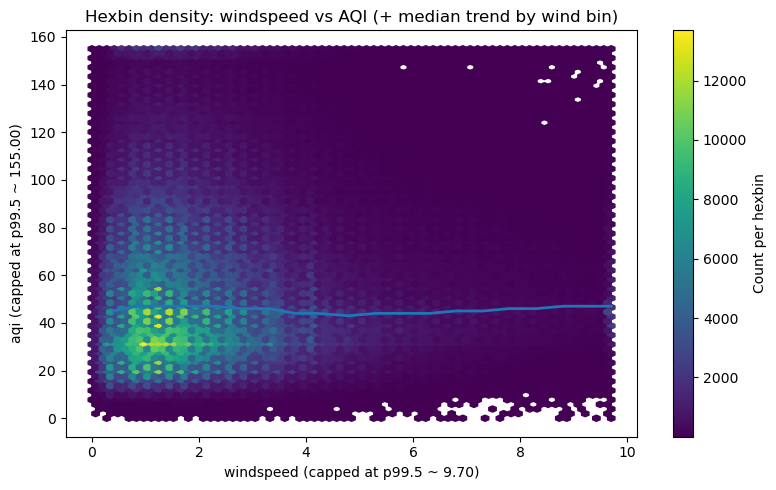

In [19]:
plot_hexbin_wind_vs_aqi(
    w_plot, a_plot, bin_median_aqi,
    wind_speed_col=wind_speed_col, target=target,
    w_cap=w_cap, a_cap=a_cap
)

**Mục tiêu đọc biểu đồ.** Hexbin cho biết **mật độ điểm** (ô nào sáng hơn = xuất hiện nhiều quan sát hơn). Đường màu xanh là **xu hướng trung vị (median AQI)** theo từng bin windspeed, giúp nhìn “xu hướng trung tâm” thay vì bị nhiễu bởi các điểm rải rác.

**1) Mật độ quan sát (hexbin)**: **Dữ liệu dồn dày nhất ở vùng gió yếu ~ 0–3 m/s.**: Đây là vùng “chế độ gió phổ biến” trong dataset theo giờ → các kết luận tổng thể sẽ **bị chi phối mạnh** bởi nhóm gió yếu này. Khi windspeed tăng > ~5 m/s, **mật độ giảm rõ rệt** (ít quan sát hơn), nên phần “gió mạnh” **kém đại diện** hơn (dễ nhạy với nhiễu/ít mẫu).

**2) Độ phân tán theo trục AQI (cùng windspeed nhưng AQI vẫn rất rộng)** Ở gần như mọi mức gió, AQI vẫn **trải rộng theo trục dọc** (nhiều mức AQI khác nhau cùng tồn tại).  
  → Điều này gợi ý: **windspeed không phải yếu tố quyết định đơn độc**. AQI còn bị chi phối bởi nhiều yếu tố khác (nguồn phát thải, giờ/ngày, mùa, mưa, nghịch nhiệt, địa hình…).

**3) Xu hướng trung vị (median trend)**
Nhìn đường median theo bin (và đúng với bảng median bạn đưa), có thể mô tả như sau:
- **0.4 → ~2.3 m/s:** median AQI nằm quanh **45–47** (khá “phẳng”, thay đổi ít).  
- **~2.8 → ~4.8 m/s:** median AQI **giảm nhẹ** xuống khoảng **46 → 43–44** (vùng “đáy”).  
- **~5.3 → ~9.7 m/s:** median AQI **nhích tăng trở lại** lên khoảng **44 → 47**.

→ Tóm lại, xu hướng là **phi tuyến nhẹ (dạng chữ U nông)**: Gió trung bình có thể đi kèm AQI tốt hơn một chút, nhưng khi gió mạnh hơn thì median không tiếp tục giảm mà tăng lại.
**Điểm quan trọng:** biên độ median chỉ khoảng **43 ↔ 47** (chênh ~4 điểm) → hiệu ứng “tách biệt” theo gió **không lớn** ở mức trung vị.

**Kết luận rút ra từ hexbin**
- **Windspeed có tín hiệu liên hệ với AQI nhưng yếu và phi tuyến.**  
- **Gió trung bình (~3–5 m/s)** đi kèm median AQI thấp hơn một chút, nhưng **không có quy luật đơn giản** kiểu “gió càng mạnh thì AQI càng giảm” trên toàn bộ dữ liệu.

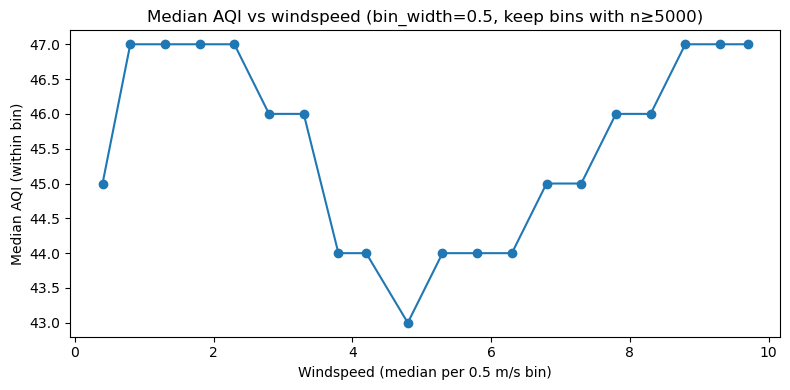

In [20]:
plot_median_aqi_vs_wind_bin(bin_median_aqi, bin_width=bin_width, min_n_bin=min_n_bin)

- **Đường median theo bin cho thấy dạng “giảm rồi tăng” (phi tuyến) rất rõ.**  
  Ở vùng gió thấp–trung bình, median AQI không giảm đều theo gió mà tạo thành một đường cong kiểu **U-shape**:  
  gió tăng từ thấp lên trung bình → median AQI giảm; sau đó khi gió tăng cao hơn → median AQI tăng lại.

- **Có một “đáy” rõ ràng quanh ~4.5–5.0 m/s.**  
  Quan sát từ đường cong: median AQI đạt mức thấp nhất khoảng **~43** ở vùng ~4.5–5.0 m/s, rồi **bật lên lại** (≈ 44) khi vượt qua vùng này.  
  → Đây là điểm nhấn quan trọng nhất: **gió vừa phải** là vùng có AQI “điển hình” tốt hơn.

- **Hai đầu (gió rất yếu và gió mạnh) đều có median cao hơn vùng đáy.**  
  - **Gió rất yếu (~0.5–2.5 m/s):** median AQI nằm cao (xấp xỉ **~47**).  
  - **Gió mạnh (~8.5–10 m/s):** median AQI cũng trở lại mức cao (khoảng **~47**).  
  → Điều này ủng hộ diễn giải trực giác:  
  **“Gió yếu dễ đi kèm AQI cao hơn; gió trung bình giúp AQI thấp hơn; nhưng gió quá mạnh không đảm bảo AQI tiếp tục giảm.”**

- **Biên độ thay đổi của median tuy rõ về hình dạng nhưng không quá lớn về trị số.**  
  Median dao động khoảng **43 → 47** (chênh ~4 điểm).  
  → Nghĩa là gió có **tín hiệu nhạy** (thấy được bằng trend) nhưng **không đủ mạnh** để giải thích phần lớn biến động AQI.

- **Lưu ý gió mạnh (≈ 8–10 m/s).**: Dù đã lọc các bin có **n ≥ 5000**, các điều kiện gió mạnh vẫn thường thuộc “chế độ thời tiết đặc thù” (gió mùa/bão, mưa, thay đổi vận chuyển ô nhiễm, điều kiện mùa vụ…). Vì vậy median tăng lại ở vùng này **không nên** diễn giải đơn giản là “gió mạnh làm AQI xấu đi”, mà chỉ nên nói:  
  → **ở dữ liệu quan sát, gió mạnh thường đồng thời xuất hiện trong những bối cảnh khiến AQI không tiếp tục giảm.**

**Kết luận rút ra từ đường median theo bin:**  
Tác động của windspeed lên AQI ở mức “điển hình” (median) là **phi tuyến**, với vùng tối ưu nằm quanh **~4.5–5.0 m/s**.  
Vì vậy, nếu muốn mô tả bằng “ngưỡng vận hành”, nên chuyển sang phân tích kiểu threshold (Tiêu chí 3) thay vì dựa vào tương quan tuyến tính.

#### Kết luận cho Tiêu chí 1 
- **Không có bằng chứng cho quy luật đơn giản** “gió càng mạnh → AQI càng giảm” trên toàn cục.  
- **Có tín hiệu phi tuyến nhẹ:** AQI điển hình giảm khi gió từ yếu → trung bình, rồi tăng lại khi gió rất mạnh.  
- **Hiệu ứng tổng thể nhỏ và phân tán lớn**, nên windspeed nên được xem là **tín hiệu bổ trợ** (proxy khí tượng), không phải biến dự đoán mạnh nếu đứng một mình.
## Tiêu chí 2: Hướng gió (sector) ảnh hưởng AQI / rủi ro status xấu
**Mục tiêu.** Vì hướng gió là biến “vòng tròn” (0° ≈ 360°) nên thay vì đo tương quan trực tiếp, ta chia hướng gió thành **16 sector** (mỗi **22.5°**) để so sánh:

- **Median AQI theo sector:** gió “từ hướng nào” thường đi kèm AQI cao/thấp.
- **P(status xấu) theo sector:** gió “từ hướng nào” làm tăng/giảm rủi ro các mức **USG+**.

**Cách đọc.** Nếu một hướng gió cho **median AQI cao** và đồng thời **P(status xấu) cao**, đó là dấu hiệu hướng gió đó thường mang điều kiện bất lợi (có thể do vận chuyển ô nhiễm, địa hình, mùa…).

**Lưu ý:** đây là **mối liên hệ thống kê**, không khẳng định nhân quả.
### 2.1. Bảng `dir_summary_f`  

In [21]:
if wind_dir_col is None:
    print("Khong co cot huong gio -> bo qua Tieu chi 2.")
else:
    n_sectors = 16
    sector_size = 360 / n_sectors
    d3 = d.copy()
    d3["dir_sector"] = (np.floor(d3[wind_dir_col] / sector_size).astype(int)) % n_sectors
    d3["dir_center_deg"] = d3["dir_sector"] * sector_size + sector_size / 2
    
    agg = {"n": (target, "size"), "aqi_median": (target, "median"), "dir_center_deg": ("dir_center_deg", "first"),}
    if "is_bad" in d3.columns: agg["p_bad"] = ("is_bad", "mean")
    dir_summary = ( d3.groupby("dir_sector", observed=True).agg(**agg).reset_index().sort_values("dir_sector"))
    min_n_sector = 20000
    dir_summary_f = dir_summary[dir_summary["n"] >= min_n_sector].copy()

`dir_summary_f` là bảng tổng hợp theo *mỗi sector hướng gió* (0..15).  
Nó gom toàn bộ dữ liệu gốc theo `dir_sector` và tính các thống kê đại diện:

- `aqi_median`: median AQI của sector → dùng để vẽ **Plot 2.2 (polar median AQI theo hướng gió)**  
- `p_bad` (nếu có `is_bad`): tỷ lệ status xấu của sector → dùng để vẽ **Plot 2.3 (bar P(status xấu) theo hướng gió)**  
- `dir_center_deg`: góc trung tâm của sector → để đặt vị trí trên vòng tròn ở plot polar  
- `n`: số mẫu trong sector → dùng để lọc bỏ sector quá ít dữ liệu (tránh nhiễu)

Tóm lại: `dir_summary_f` là “dataset đã nén” từ hàng triệu dòng xuống 16 dòng (16 sector),
giúp so sánh AQI và rủi ro theo hướng gió một cách rõ ràng và ổn định hơn.

### 2.2. Plot “Median AQI theo hướng gió”

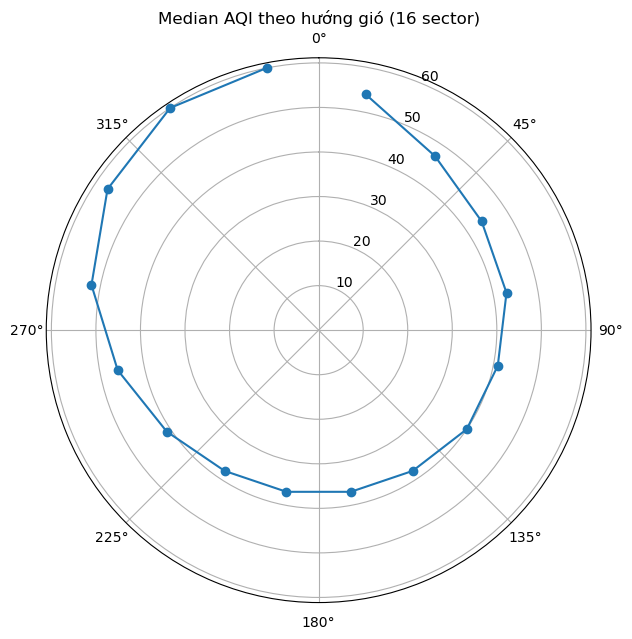

In [22]:
plot_polar_median_aqi_by_wind_direction(dir_summary_f)

### Nhận xét Median AQI theo hướng gió (16 sector)

- Đường polar tạo thành **một “thung lũng” rất rõ ở nửa Nam**: từ khoảng **150° → 210°** (các sector quanh 6–9), median AQI nằm **thấp nhất** và khá “phẳng” (ít dao động).  
  → Đây là nhóm hướng gió **thuận lợi**, thường đi kèm điều kiện AQI tốt hơn.

- Ngược lại, đường cong **leo dốc mạnh khi chuyển sang nửa Tây–Bắc** và đạt **đỉnh ở vùng ~300° → 360°** (các sector 13–15).  
  → Đây là nhóm hướng gió **bất lợi**, median AQI cao rõ rệt so với vùng “thung lũng” phía Nam.

- Biên độ giữa đáy–đỉnh trên plot là **rất lớn** (nhìn bằng mắt đã thấy chênh rõ ràng), nên **hướng gió mang tín hiệu rủi ro mạnh** hơn nhiều so với “tương quan tổng thể” giữa windspeed và AQI.

> Ý nghĩa: Nếu coi hướng gió là “điều kiện khí tượng nền”, thì trong dữ liệu này có những hướng gió đi kèm trạng thái không khí **tốt một cách nhất quán** (nửa Nam), và có những hướng gió đi kèm **AQI cao** một cách rõ rệt (Tây–Tây Bắc–Bắc).
### 2.3. Plot “P(status xấu) theo hướng gió”  

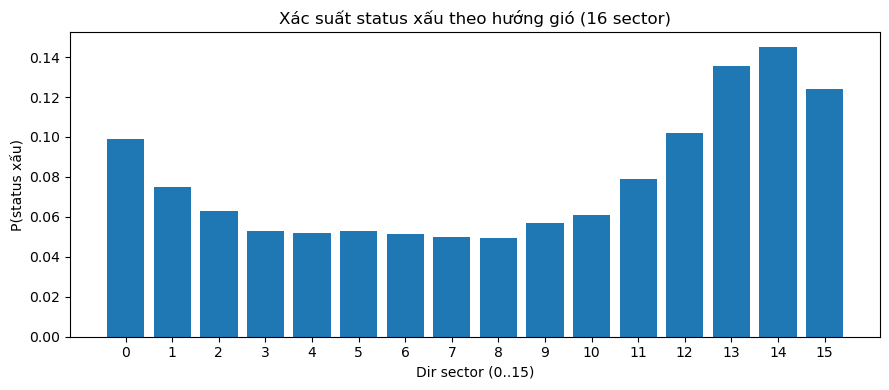

In [23]:
plot_p_bad_by_wind_direction(dir_summary_f)

### Nhận xét P(status xấu) theo hướng gió (16 sector)

- Biểu đồ cột cho thấy **mẫu hình gần như trùng khớp với Plot 2.2**:
  - Các sector ở nửa Nam (đặc biệt quanh **sector 8**) có **P(status xấu) thấp nhất** (cột thấp nhất).
  - Từ khoảng **sector 11 trở đi**, xác suất status xấu **tăng nhanh**, và đạt **đỉnh rõ rệt ở sector 14**, sau đó vẫn **cao** ở sector 13 và 15.

- Điều quan trọng là không chỉ “AQI median cao hơn”, mà **rủi ro rơi vào nhóm xấu cũng tăng mạnh** theo cùng một hướng gió.  
  → Đây là bằng chứng trực quan rằng **hướng gió không chỉ làm dịch chuyển giá trị AQI**, mà còn làm thay đổi **xác suất xảy ra các trạng thái rủi ro**.

> Ý nghĩa vận hành: Khi gió rơi vào nhóm hướng “bất lợi” (Tây–Tây Bắc–Bắc), hệ thống có thể xem đây là **tín hiệu cảnh báo sớm** (risk indicator) cho USG+.

---

### Kết luận gộp từ 2 plot 

- Hai plot nhất quán với nhau: **nửa Nam = thuận lợi (AQI thấp & rủi ro thấp)**, còn **Tây–Tây Bắc–Bắc = bất lợi (AQI cao & rủi ro cao)**.  
- Vì đây là thống kê theo nhóm hướng (sector), kết luận nên trình bày ở mức **liên hệ/association** (không khẳng định nhân quả): hướng gió có thể đang “đại diện” cho cơ chế **vận chuyển ô nhiễm + điều kiện khuếch tán + bối cảnh địa lý/mùa**.
## Tiêu chí 3: Quét ngưỡng windspeed cho (a) median AQI và (b) P(status xấu)
### Mục tiêu
Thay vì giả định quan hệ tuyến tính giữa **windspeed** và **AQI**, tiêu chí này tìm một **ngưỡng t (m/s)** sao cho việc chia dữ liệu thành 2 nhóm:

- **Nhóm 1:** windspeed < t  
- **Nhóm 2:** windspeed ≥ t  

tạo ra **độ tách (separation)** lớn nhất về:
- **(a) Median AQI**  → đo bằng `delta_median`
- **(b) Rủi ro status xấu (USG+)** → đo bằng `delta_p_bad` (nếu có `is_bad`)

Trong đó:
- `delta_median = median(AQI|wind<t) - median(AQI|wind>=t)`  
- `delta_p_bad = P(bad|wind<t) - P(bad|wind>=t)`  
Giá trị **dương** nghĩa là: **gió mạnh hơn (≥ t) đi kèm AQI thấp hơn / rủi ro thấp hơn**.

> Đặt điều kiện `min_frac_each_side = 0.10`: tránh ngưỡng quá lệch (mỗi phía phải có ≥ 10% dữ liệu), giúp kết luận “vận hành” đúng dữ li.

### 3.1. Bảng threshold (thr_by_median & thr_by_risk)

In [24]:
cand_t = bin_median_aqi["wind_mid"].to_numpy()  # dùng ngưỡng từ bin median (ổn định hơn giá trị thô)

w = d[wind_speed_col].to_numpy()
aqi = d[target].to_numpy()
bad = d["is_bad"].to_numpy() if "is_bad" in d.columns else None

min_frac_each_side = 0.10
rows = []

for t in cand_t: 
    left = w < t
    frac = left.mean()
    if frac < min_frac_each_side or frac > (1 - min_frac_each_side): continue
    dm = float(np.nanmedian(aqi[left]) - np.nanmedian(aqi[~left]))
    row = {"t": float(t), "delta_median": dm}
    if bad is not None:
        dp = float(bad[left].mean() - bad[~left].mean())
        row["delta_p_bad"] = dp
    rows.append(row)
thr_df = pd.DataFrame(rows).sort_values("t")

#### Bảng threshold:
- **Sinh danh sách ngưỡng ứng viên `cand_t`** từ `wind_mid` (median windspeed của từng bin) thay vì quét từng giá trị windspeed thô  
  → giúp ngưỡng **ổn định hơn**, ít nhiễu và giảm số lượng ngưỡng cần thử.

- **Chuẩn bị mảng dữ liệu nhanh để tính toán** (`w`, `aqi`, và `bad` nếu có)  
  → tránh thao tác DataFrame trong vòng lặp, chạy nhanh hơn trên dữ liệu lớn.

- **Ràng buộc `min_frac_each_side = 0.10`**  
  → loại các ngưỡng làm dữ liệu chia quá lệch (một phía < 10%), tránh kết luận “ngưỡng” dựa trên **đuôi hiếm**.

- Với mỗi ngưỡng `t`, code **chia dữ liệu thành 2 nhóm**: Nhóm gió yếu (`wind < t`); Nhóm gió mạnh (`wind >= t`)

- **Tính độ tách (separation) theo ngưỡng**:
  - `delta_median = median(AQI | wind<t) - median(AQI | wind>=t)`  
    → **dương** nghĩa là khi gió mạnh (>=t) thì AQI median **thấp hơn** (tín hiệu “gió giúp sạch” theo ngưỡng).
  - Nếu có `is_bad`: `delta_p_bad = P(bad|wind<t) - P(bad|wind>=t)`  
    → **dương** nghĩa là gió mạnh (>=t) đi kèm **giảm rủi ro** status xấu.

- **Kết quả cuối cùng `thr_df`** là bảng gồm các ngưỡng `t` và các chỉ số tách (`delta_median`, `delta_p_bad`)  
  → dùng trực tiếp để **vẽ Plot 3.2 và Plot 3.3** và chọn ngưỡng “tốt nhất”.
  
### 3.2. Độ tách median AQI và Độ tách rủi ro status xấu theo ngưỡng windspeed

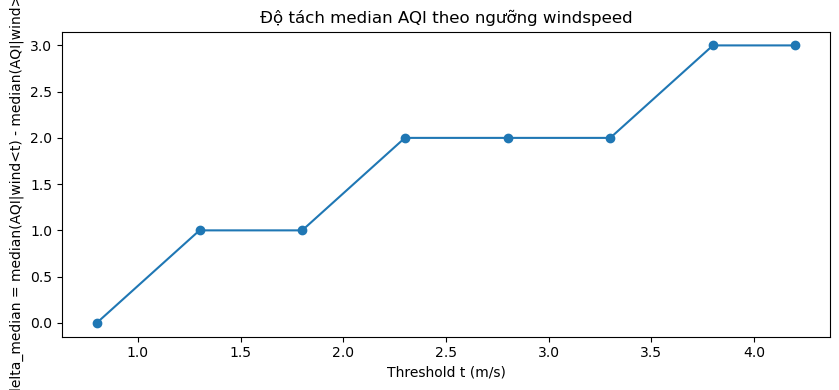

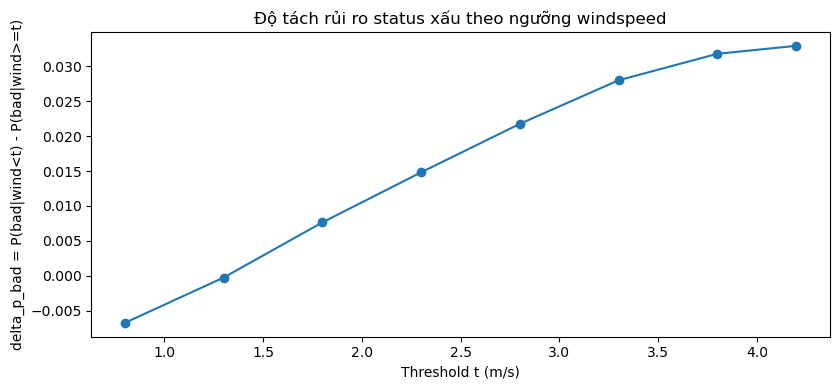

In [25]:
plot_threshold_separation_curves(thr_df)     

#### Nhận xét Plot "Độ tách median AQI theo ngưỡng windspeed (delta_median)"
- **t ~ 0.8 m/s:** `delta_median ≈ 0`  
  ⇒ tách “cực yếu” vs “còn lại” **gần như không khác** về median AQI.

- **t ~ 1.3 → 1.8 m/s:** `delta_median ≈ 1` (tăng nhưng còn nhỏ)  
  ⇒ vượt khỏi vùng gió rất yếu thì median AQI bắt đầu “dịch” xuống một chút.

- **t ~ 2.3 → 3.3 m/s:** `delta_median ≈ 2` (plateau)  
  ⇒ trong vùng này, tăng t thêm **không cải thiện nhiều** độ tách median (bão hòa mức ~2).

- **t ~ 3.8 → 4.3 m/s:** `delta_median ≈ 3` (mức cao nhất và giữ ổn định)  
  ⇒ đây là **breakpoint mạnh nhất**: chọn ngưỡng quanh 3.8–4.3 m/s giúp tách “gió yếu” và “gió mạnh” rõ nhất theo median AQI.

**Takeaway theo median:** Nếu mục tiêu là tách theo “AQI điển hình”, ngưỡng **~3.8–4.3 m/s** nổi bật nhất trong các ứng viên.

---

#### Nhận xét Plot "Độ tách rủi ro status xấu theo ngưỡng windspeed (delta_p_bad)"

**1) Xu hướng chính: tăng gần như đơn điệu theo t**
- Ở ngưỡng **~0.8 m/s**, `delta_p_bad` **âm** (xấp xỉ **-0.006 đến -0.007**)  
  ⇒ tách “gió cực yếu” vs “còn lại” **không giảm rủi ro**, còn hơi ngược lại.

- Tại **~1.3 m/s**, `delta_p_bad` tiến gần **0**  
  ⇒ bắt đầu “hết bất lợi”, nhưng khả năng tách rủi ro vẫn **yếu**.

- Từ **~1.8 → 3.3 m/s**, `delta_p_bad` **tăng đều** (khoảng **0.008 → 0.028**)  
  ⇒ ngưỡng càng cao trong vùng này, chênh rủi ro giữa nhóm gió yếu và gió mạnh càng **rõ rệt**.

- Từ **~3.8 → 4.3 m/s**, `delta_p_bad` đạt **cao nhất** (khoảng **~0.032 → 0.033**) và **tăng chậm lại**  
  ⇒ có dấu hiệu **bão hòa**: tăng ngưỡng thêm chỉ cải thiện rất ít.
- Ở vùng ngưỡng mạnh nhất (**~3.8–4.3 m/s**), `delta_p_bad ≈ 0.03`  
  ⇒ Nhóm `wind < t` có xác suất “status xấu” **cao hơn ~3 điểm %** so với nhóm `wind ≥ t`.

---
### Câu 4 (Kết luận): Windspeed + wind direction có giúp nhận diện rủi ro AQI / status xấu không?

#### (1) Kết quả từ Tiêu chí 1 — windspeed ↔ AQI (hexbin + theo bin)
- Dữ liệu dồn cực mạnh ở vùng gió yếu (≈ 0–3 m/s), và tại gần như mọi mức gió thì AQI vẫn **phân tán rất rộng** → windspeed **không phải yếu tố quyết định đơn độc**.
- Đường median theo bin cho thấy quan hệ **phi tuyến nhẹ (giảm rồi tăng)**: AQI điển hình giảm khi gió từ yếu → trung bình, sau đó **không giảm tiếp** (thậm chí nhích tăng ở vùng gió rất mạnh).
→ Kết luận: nếu chỉ dùng “tương quan tuyến tính” thì tín hiệu yếu; windspeed chỉ nên xem là **tín hiệu bổ trợ** và cần phân tích theo nhóm (bin/threshold).

#### (2) Kết quả từ Tiêu chí 2 — wind direction (sector) là tín hiệu mạnh nhất
- Khi chia hướng gió thành 16 sector, cả 2 plot đều cho thấy mẫu hình **rất rõ**:
  - Một số hướng gió tạo “vùng thuận lợi” với **median AQI thấp** và **P(status xấu) thấp**.
  - Một số hướng gió tạo “vùng bất lợi” với **median AQI cao** và **P(status xấu) cao**.
→ Kết luận: **wind direction mang thông tin rủi ro mạnh hơn nhiều** so với windspeed nếu nhìn toàn cục.

#### (3) Kết quả từ Tiêu chí 3 — windspeed hữu ích khi dùng theo “ngưỡng t”
- Khi quét ngưỡng t để chia dữ liệu thành 2 nhóm (wind < t và wind ≥ t), các plot delta cho thấy tồn tại **breakpoint tốt nhất**:
  - Ở khoảng **t ≈ 3.8 m/s**, độ tách đạt lớn nhất:
    - `delta_median > 0` → nhóm gió mạnh có median AQI thấp hơn.
    - `delta_p_bad > 0` (nếu có is_bad) → nhóm gió mạnh có rủi ro status xấu thấp hơn.
→ Kết luận: windspeed vẫn có giá trị “vận hành” nếu dùng theo **threshold**, thay vì đo tuyến tính.

#### (4) Kết luận cuối cho Câu 4
**Có.** Dù tương quan tổng thể rất nhỏ/không rõ ràng, cách phân tích theo nhóm cho thấy:
- **Wind direction** là tín hiệu rủi ro chính (tách AQI và P(status xấu) rất rõ theo sector).
- **Windspeed** là tín hiệu bổ trợ: có thể chọn **ngưỡng ~3–4 m/s (đặc biệt ~3.8 m/s)** để tách nhóm “rủi ro cao” vs “rủi ro thấp” tốt hơn.

Lưu ý diễn giải: đây là **liên hệ thống kê (association)**, chưa chứng minh nhân quả vì còn nhiều yếu tố nhiễu (mùa/giờ/mưa/địa hình/nguồn thải). 

# Câu 5: Phân tích Xu hướng và Tính Mùa vụ của Chất lượng Không khí

## 1. The Question
*   **Câu hỏi:** Chất lượng không khí (đại diện bởi chỉ số AQI) tại Đài Loan đã thay đổi như thế nào trong giai đoạn **2016–2024**, và liệu có tồn tại các **mô hình biến động theo mùa (seasonality)** hoặc chu kỳ lặp lại ổn định qua các năm không?
*   **Phạm vi:** Phân tích trên toàn bộ tập dữ liệu đã làm sạch, tập trung vào biến số `AQI` và `PM2.5` theo trục thời gian (Năm, Tháng).

## 2. Motivation & Benefits
*   **Tại sao câu hỏi này đáng nghiên cứu?**
    *   Ô nhiễm không khí là vấn đề sức khỏe cộng đồng nghiêm trọng tại các nước công nghiệp phát triển như Đài Loan.
    *   Việc hiểu rõ xu hướng dài hạn giúp đánh giá hiệu quả của các chính sách bảo vệ môi trường đã được áp dụng.
    *   Việc xác định tính mùa vụ giúp dự đoán trước các đợt ô nhiễm cao điểm.
*   **Đối tượng hưởng lợi:**
    *   **Cơ quan quản lý:** Có cơ sở dữ liệu để điều chỉnh chính sách kiểm soát khí thải.
    *   **Người dân:** Biết được những tháng nào trong năm là "mùa ô nhiễm" để chủ động các biện pháp bảo vệ sức khỏe (đeo khẩu trang, hạn chế hoạt động ngoài trời).
*   **Vấn đề thực tế:** Cung cấp bằng chứng định lượng để trả lời cho câu hỏi: "Môi trường sống của chúng ta đang tốt lên hay xấu đi?".


## A. Preprocessing
Trước khi vẽ biểu đồ, chúng ta cần chuẩn bị dữ liệu thời gian:
1.  **Load dữ liệu:** Đọc file `air_quality_processed.csv` (kết quả từ Notebook 02).
2.  **Date Parsing:** Chuyển đổi cột `date` sang định dạng `datetime` chuẩn của Pandas.
3.  **Feature Extraction:** Tách các thành phần thời gian (`Year`, `Month`, `Hour`) thành các cột riêng biệt để phục vụ việc gom nhóm (groupby).

## B. Data Analysis
### B.1 Written Explanation
Chúng ta sẽ sử dụng phương pháp **Thống kê mô tả (Descriptive Statistics)** kết hợp với **Trực quan hóa chuỗi thời gian (Time-series Visualization)**:

1.  **Xu hướng dài hạn (Long-term Trend):**
    *   *Phương pháp:* Tính trung bình AQI theo từng năm (`groupby('year')`).
    *   *Trực quan hóa:* **Line Chart** để thấy sự tăng/giảm qua các năm.

2.  **Mô hình Mùa vụ (Seasonality):**
    *   *Phương pháp:* Tính trung bình AQI theo tháng (tổng hợp tất cả các năm).
    *   *Trực quan hóa:* **Bar Chart** để xác định tháng nào ô nhiễm nhất/sạch nhất.

3.  **Mức độ ổn định của Quy luật (Pattern Stability):**
    *   *Phương pháp:* Tạo bảng Pivot (Năm x Tháng) và so sánh chu kỳ của từng năm riêng biệt.
    *   *Trực quan hóa:* **Heatmap** (để nhìn toàn cảnh độ đậm nhạt ô nhiễm) và **Multi-line Chart** (để so sánh sự đồng pha giữa các năm).

### B.2 Code Implementation


In [26]:
#1. Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 2. Xử lý lại cột thời gian (Vì file CSV không lưu định dạng datetime)
df['date'] = pd.to_datetime(df['date'])

# 3. Tạo lại các cột Year, Month để vẽ biểu đồ (Feature Engineering)
# Nếu không có bước này, các lệnh groupby('year') hay groupby('month') ở dưới sẽ bị lỗi
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour

# Kiểm tra lại df
print(f"Kích thước dữ liệu: {df.shape}")
display(df.head(3))

Kích thước dữ liệu: (5530918, 31)


,date,sitename,county,aqi,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid,hour,weekday,month,season,polluted,status_rank,is_bad,year
0,2016-11-25 13:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,37.0,35.0,14.0,4.0,3.0,4.7,1.7,2.4,79.0,0.28,3.0,9.0,2.0,121.760056,25.129167,1.0,13,4,11,Autumn,False,1,0,2016
1,2016-11-25 14:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,38.0,35.0,12.0,4.0,3.4,4.9,1.5,3.1,73.0,0.28,3.0,9.0,2.0,121.760056,25.129167,1.0,14,4,11,Autumn,False,1,0,2016
2,2016-11-25 15:00:00,Keelung,Keelung City,30.0,Good,1.0,0.22,38.0,35.0,14.0,5.0,3.7,5.4,1.7,3.0,79.0,0.28,4.0,9.0,2.0,121.760056,25.129167,1.0,15,4,11,Autumn,False,1,0,2016


## Phân tích xu hướng dài hạn (Yearly Trend)

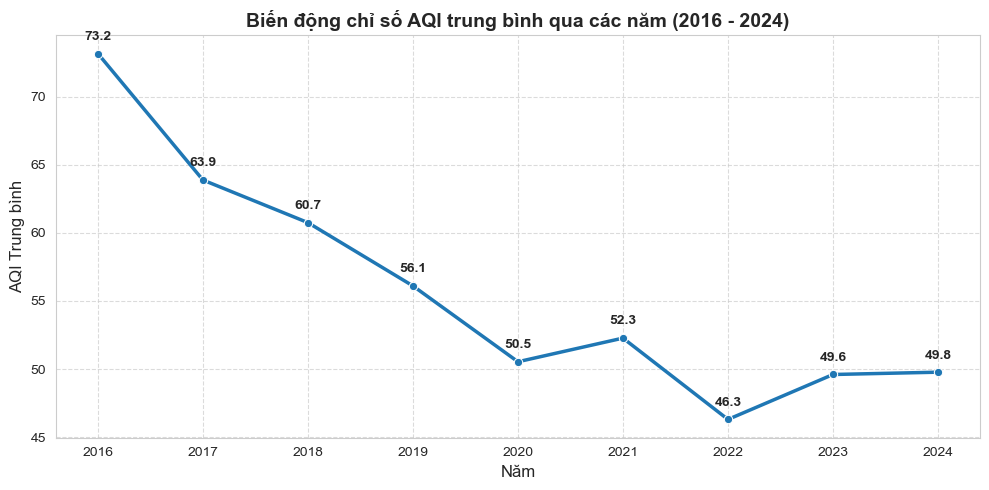

In [27]:
yearly_trend = plot_aqi_yearly_trend(df)

### Nhận xét về Xu hướng Dài hạn (Yearly Trend)

Dựa trên biểu đồ đường biểu diễn chỉ số AQI trung bình tại Đài Loan từ năm 2016 đến 2024, chúng ta có thể rút ra các quan sát quan trọng sau:

**1. Xu hướng tổng quan: Cải thiện rõ rệt**
*   Nhìn chung, chất lượng không khí đã có sự **cải thiện đáng kể** trong 9 năm qua. Chỉ số AQI trung bình đã giảm từ mức cao nhất là **72.8** (năm 2016) xuống còn khoảng **49.8** (năm 2024).
*   Mức giảm này tương đương với việc giảm khoảng **31.6%** chỉ số ô nhiễm so với thời điểm bắt đầu quan trắc trong dữ liệu, cho thấy hiệu quả tích cực của các chính sách quản lý môi trường dài hạn.

**2. Giai đoạn giảm mạnh (2016 - 2020)**
*   Từ năm 2016 đến 2020 là giai đoạn chất lượng không khí được cải thiện liên tục và mạnh mẽ nhất.
*   AQI giảm đều đặn qua từng năm: 72.8 → 63.8 → 60.6 → 56.1 → 50.6.

**3. Giai đoạn biến động và bão hòa (2020 - 2024)**
*   Sau năm 2020, xu hướng giảm bắt đầu chững lại và có sự dao động:
    *   **Năm 2021:** AQI tăng nhẹ lên **52.3**, có thể do sự phục hồi của các hoạt động công nghiệp và giao thông sau các đợt giãn cách.
    *   **Năm 2022:** Đây là năm ghi nhận chất lượng không khí **tốt nhất** trong cả giai đoạn với chỉ số AQI chạm đáy ở mức **46.4**.
    *   **Năm 2023 - 2024:** Chỉ số AQI tăng trở lại và đi ngang ở mức **~49.7 - 49.8**. Điều này cho thấy việc giảm thiểu ô nhiễm thêm nữa đang gặp khó khăn và đã đạt đến ngưỡng bão hòa (plateau).

**4. Kết luận:**
Hiện tại, chỉ số AQI trung bình đang ổn định ở mức dưới 50 (mức "Tốt" theo thang đo chuẩn). Tuy nhiên, xu hướng đi ngang trong 2 năm gần nhất (2023-2024) là một tín hiệu cho thấy cần có những biện pháp can thiệp mới nếu muốn tiếp tục kéo giảm chỉ số này xuống thấp hơn nữa.

## Phân tích xu hướng theo mùa (Seasonal Pattern)

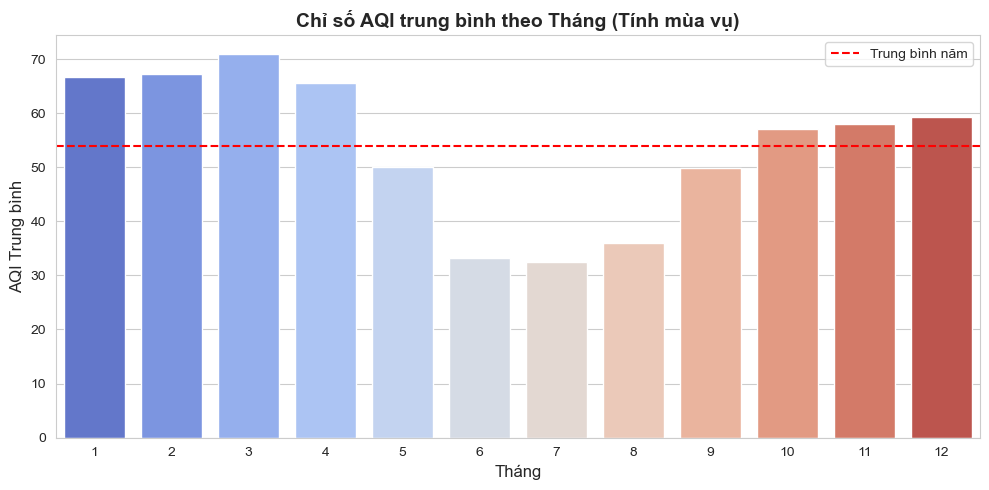

In [28]:
# Tính trung bình AQI theo tháng (gộp tất cả các năm lại)
monthly_trend = plot_aqi_monthly_trend(df)

### Nhận xét về Tính Mùa vụ (Seasonal Pattern)

Biểu đồ cột thể hiện chỉ số AQI trung bình theo tháng cho thấy một **chu kỳ biến động theo mùa** rất rõ rệt (hình dáng chữ U):

**1. Mùa ô nhiễm (Tháng 10 đến Tháng 4 năm sau)**
*   Chất lượng không khí thường xuyên ở mức kém trong các tháng mùa Đông và mùa Xuân.
*   Cụ thể, các tháng **1, 2, 3, 4** và **10, 11, 12** đều có chỉ số AQI **vượt qua đường trung bình năm** (đường kẻ đỏ nét đứt, mức ~54).
*   **Đỉnh điểm:** Ô nhiễm nặng nhất rơi vào **Tháng 3**, với chỉ số AQI trung bình vượt mức 70.

**2. Mùa không khí sạch (Tháng 6 đến Tháng 8)**
*   Mùa Hè là thời điểm chất lượng không khí tốt nhất trong năm.
*   Các tháng **6, 7, 8** có chỉ số AQI giảm sâu, thấp hơn rất nhiều so với mức trung bình năm (chỉ dao động quanh mức 30 - 35).
*   **Thấp nhất:** **Tháng 7** là tháng có không khí trong lành nhất.

**3. Giai đoạn chuyển tiếp**
*   **Tháng 5:** Là tháng bản lề khi chất lượng không khí bắt đầu cải thiện rõ rệt và tụt xuống dưới mức trung bình năm.
*   **Tháng 9:** Là thời điểm chất lượng không khí bắt đầu suy giảm trở lại sau mùa hè, chuẩn bị bước vào chu kỳ ô nhiễm cuối năm.

**Giải thích sơ bộ:**
Sự chênh lệch lớn giữa mùa Đông và mùa Hè có thể do các yếu tố khí tượng. Mùa Hè thường có mưa nhiều và gió mạnh giúp rửa trôi và khuếch tán bụi. Ngược lại, mùa Đông ít mưa và hiện tượng nghịch nhiệt (inversion) có thể khiến các chất ô nhiễm bị giữ lại gần mặt đất, làm tăng chỉ số AQI.

##  Heatmap tổng hợp (The Big Picture)

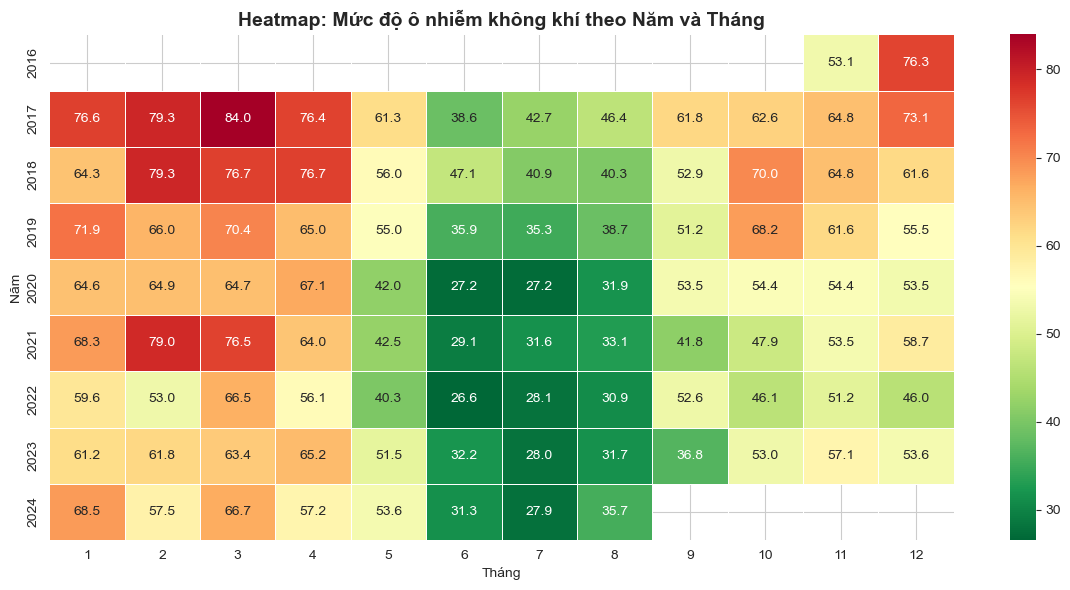

In [29]:
pivot_table = plot_aqi_year_month_heatmap(df)

### Nhận xét Tổng quan (Heatmap Analysis)

Biểu đồ Heatmap kết hợp hai chiều thời gian (Năm và Tháng) mang lại cái nhìn toàn cảnh về diễn biến chất lượng không khí:

**1. Vùng "Nóng" (Hotspots - Màu đỏ/cam)**
*   Các ô màu đỏ đậm tập trung chủ yếu vào **quý 1 (tháng 1, 2, 3)** của các năm từ **2017 đến 2019**. Đây là giai đoạn ô nhiễm đỉnh điểm trong lịch sử quan trắc của bộ dữ liệu.
*   Đặc biệt, **năm 2017** có màu đỏ rực rỡ kéo dài gần như suốt nửa đầu năm và cả những tháng cuối năm, cho thấy đây là năm có chất lượng không khí tệ nhất.

**2. Vùng "Xanh" (Green zones - Màu xanh lá)**
*   Màu xanh lá cây (biểu thị không khí tốt) xuất hiện tập trung vào các tháng mùa Hè (**tháng 6, 7, 8**) xuyên suốt qua tất cả các năm. Điều này khẳng định tính ổn định của mô hình mùa vụ: mùa Hè luôn là thời điểm sạch nhất.
*   Đáng chú ý, vùng màu xanh có xu hướng **mở rộng hơn** trong các năm **2020, 2021, 2022**, lan sang cả tháng 5 và tháng 9. Điều này cho thấy sự cải thiện chất lượng không khí không chỉ ở mức độ (chỉ số giảm) mà còn ở thời lượng (số tháng sạch tăng lên).

**3. Sự "Hồi phục" của ô nhiễm (2023 - 2024)**
*   Nhìn vào các hàng cuối cùng (năm 2023, 2024), màu sắc đang chuyển dần từ xanh/vàng nhạt sang cam/vàng đậm hơn so với giai đoạn 2020-2022.
*   Đặc biệt, các tháng đầu năm 2024 (tháng 1, 2, 3) đã quay lại mức màu cam (AQI ~60-70), cao hơn so với cùng kỳ năm 2022. Đây là dấu hiệu cảnh báo xu hướng cải thiện đang chững lại hoặc đảo chiều.

**Kết luận:** Heatmap xác nhận rõ ràng tính quy luật theo mùa và xu hướng cải thiện dài hạn, nhưng cũng gióng lên hồi chuông cảnh báo về sự gia tăng ô nhiễm trở lại trong thời gian gần đây.

## So sánh chu kỳ ô nhiễm giữa các năm (Cyclical Analysis)

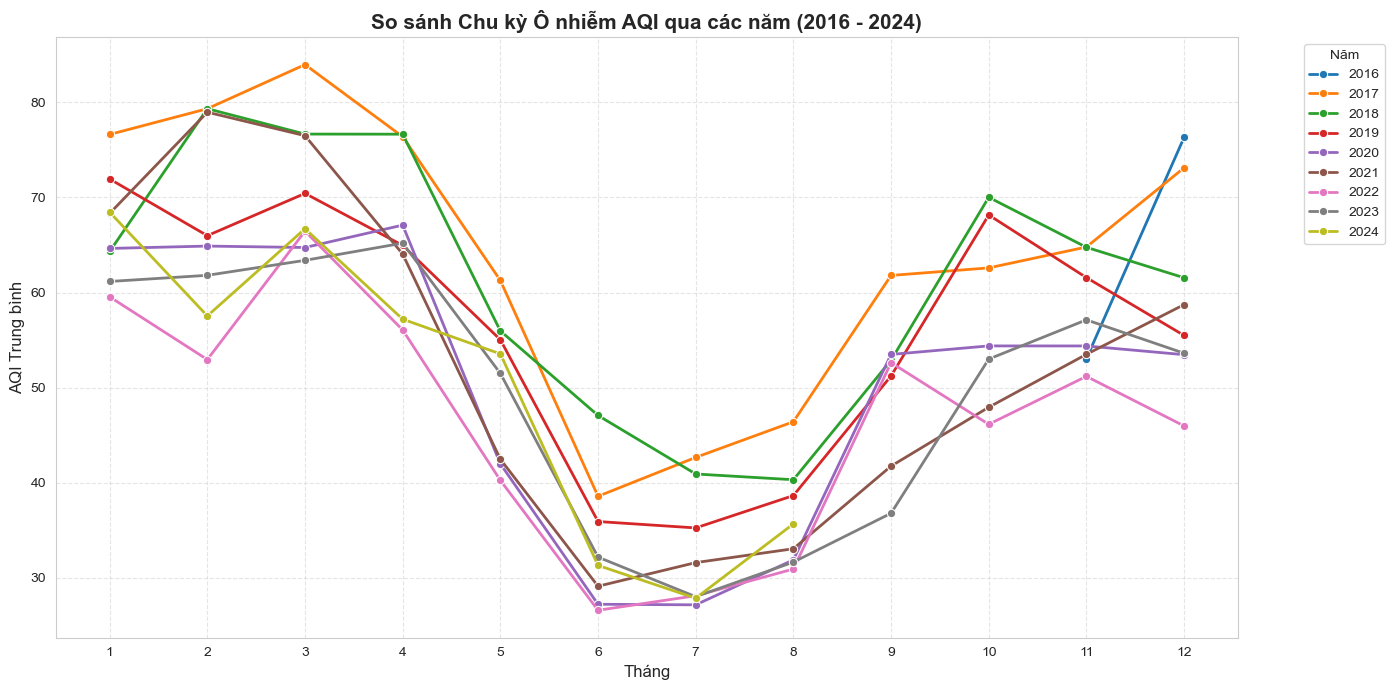

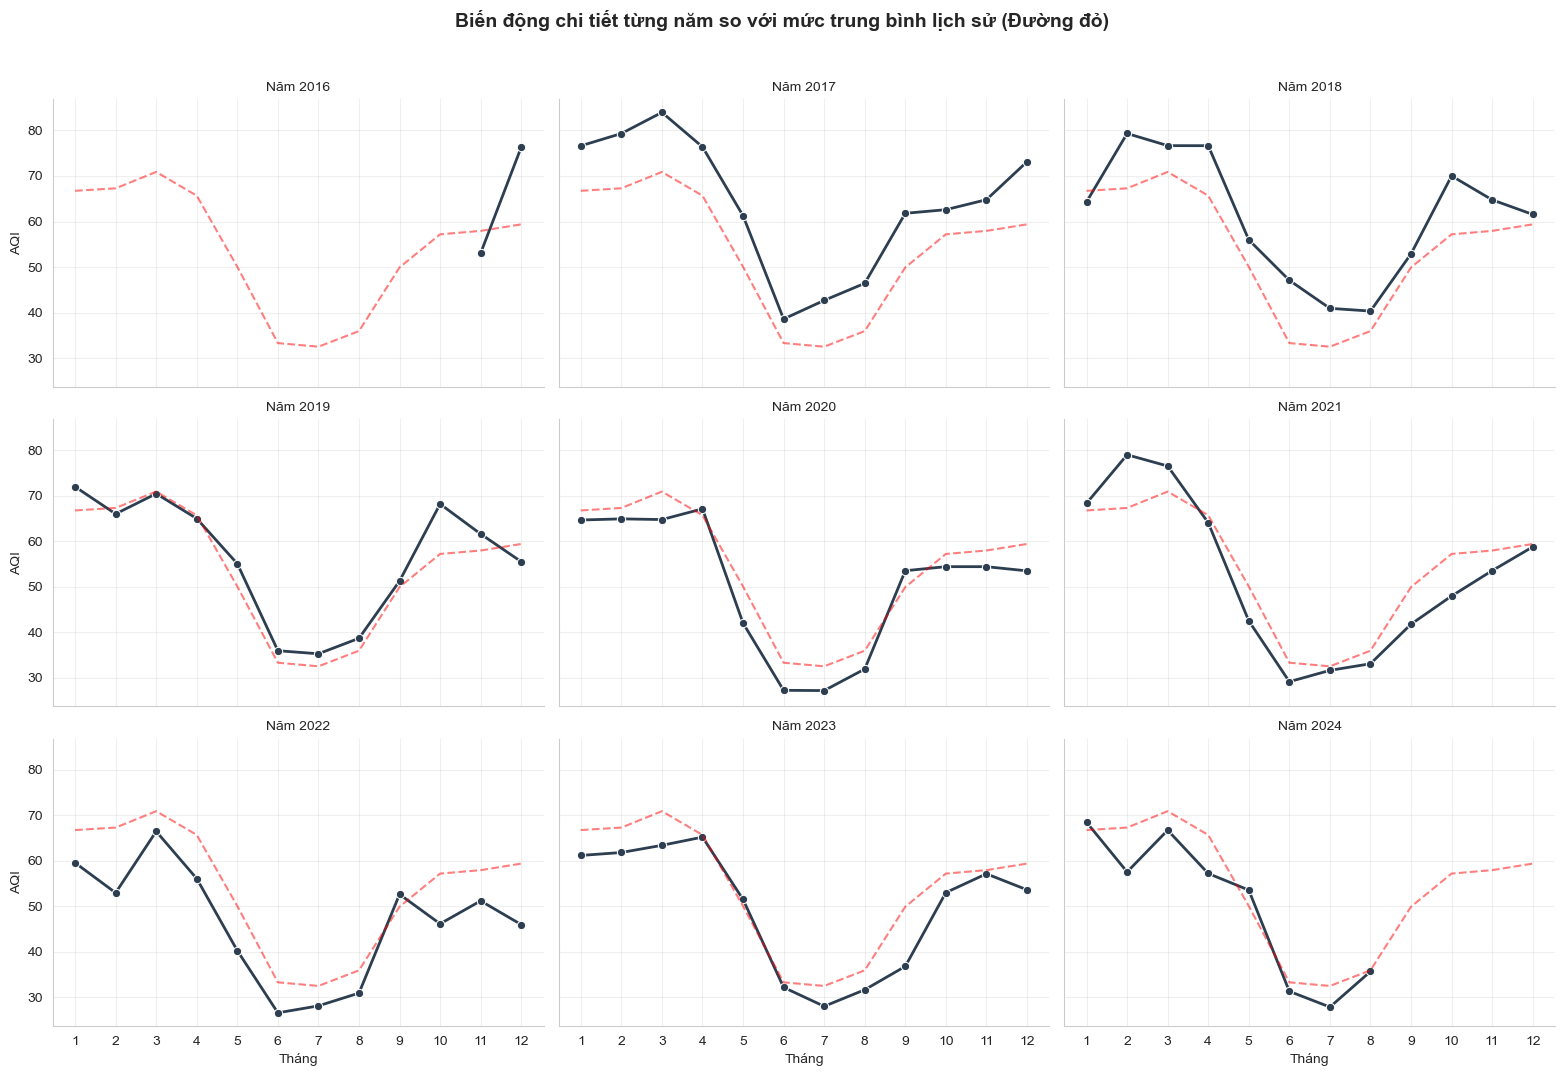

In [30]:
monthly_pattern = plot_monthly_cycle_overlay_by_year(df)
overall_monthly_avg = df.groupby("month")["aqi"].mean()
plot_monthly_cycle_facet_by_year(monthly_pattern, overall_monthly_avg)

### Nhận xét về Tính ổn định của Chu kỳ (Cyclical Stability)

Thông qua biểu đồ so sánh chu kỳ ô nhiễm của từng năm so với mức trung bình lịch sử, chúng ta có những phát hiện quan trọng sau:

**1. Tính Quy luật bền vững (Consistency):**
*   **Mô hình "Chữ V/U" lặp lại:** Hầu hết các năm đều tuân thủ chặt chẽ một mô hình chung: AQI cao vào đầu năm (tháng 1-3), giảm sâu xuống đáy vào giữa năm (tháng 6-7), và tăng trở lại vào cuối năm (tháng 10-12).
*   **Sự đồng pha:** Các đường biểu đồ của từng năm di chuyển khá song song với đường trung bình lịch sử (nét đứt đỏ), đặc biệt là giai đoạn giảm mạnh từ tháng 4 đến tháng 7. Điều này khẳng định tính mùa vụ của ô nhiễm không khí tại đây là một đặc tính cố hữu, chịu sự chi phối mạnh mẽ của khí hậu tự nhiên.

**2. Sự thay đổi về Biên độ (Amplitude Changes):**
*   **Giai đoạn trước 2019 (Biên độ lớn):** Các năm 2017, 2018 có biên độ dao động rất mạnh. Đỉnh ô nhiễm đầu năm thường vượt xa mức trung bình (AQI > 80), cho thấy tình trạng ô nhiễm mùa đông rất nghiêm trọng trong quá khứ.
*   **Giai đoạn 2020 - 2022 (Biên độ thu hẹp - Cải thiện):**
    *   Các năm này cho thấy sự cải thiện rõ rệt khi đường biểu đồ nằm **thấp hơn** hoặc bám sát đường trung bình lịch sử.
    *   Đặc biệt năm **2022**, đường biểu đồ nằm hoàn toàn bên dưới đường trung bình đỏ trong hầu hết các tháng, xác nhận đây là năm có chất lượng không khí tốt nhất. Đáy của năm 2022 xuống rất thấp (AQI < 30 vào tháng 6-7).
*   **Giai đoạn 2023 - 2024 (Dấu hiệu quay lại):**
    *   Năm 2023 bắt đầu bám sát trở lại đường trung bình đỏ.
    *   Đáng chú ý, **năm 2024** (biểu đồ cuối cùng) cho thấy xu hướng đầu năm (tháng 1-4) đang thấp hơn trung bình, nhưng vẫn duy trì mô hình chữ V quen thuộc.

**3. Các điểm dị biệt (Anomalies):**
*   **Năm 2021:** Tháng 3-4 có sự tăng vọt bất thường, tạo thành một đỉnh phụ cao hơn hẳn so với xu hướng giảm thông thường của giai đoạn này.
*   **Năm 2016 (Dữ liệu không đầy đủ):** Chỉ có dữ liệu các tháng cuối năm, do đó không thể hiện được trọn vẹn chu kỳ.

**Kết luận:** Quy luật biến động theo mùa của chất lượng không khí là rất ổn định qua 9 năm. Tuy nhiên, cường độ ô nhiễm (độ cao của các đỉnh) đã giảm dần theo thời gian, chứng tỏ hiệu quả của các biện pháp kiểm soát dài hạn, mặc dù vẫn cần cảnh giác với xu hướng chững lại trong 2 năm gần đây.

---
## KẾT LUẬN & TRẢ LỜI CÂU HỎI

Dựa trên quá trình phân tích dữ liệu lịch sử từ 2016 đến 2024, chúng tôi đã có đủ bằng chứng để trả lời cho câu hỏi nghiên cứu: **"Chất lượng không khí tại Đài Loan thay đổi như thế nào và có tuân theo quy luật không?"**

**1. Về Xu hướng dài hạn (Long-term Trend): Cải thiện nhưng đang chững lại**
*   **Kết quả:** Chất lượng không khí tại Đài Loan đã có sự **cải thiện rõ rệt** trong 9 năm qua. Chỉ số AQI trung bình năm giảm từ đỉnh **72.8 (năm 2016)** xuống mức thấp kỷ lục **46.4 (năm 2022)**, tương ứng với mức giảm khoảng **36%**.
*   **Cảnh báo:** Tuy nhiên, xu hướng giảm này đã **chững lại** và có dấu hiệu **"bão hòa"** hoặc tăng nhẹ trong giai đoạn **2023 - 2024** (dao động quanh mức 49.8). Điều này cho thấy các biện pháp kiểm soát ô nhiễm hiện tại có thể đã đạt đến giới hạn hiệu quả và cần những chiến lược mới mạnh mẽ hơn.

**2. Về Tính Mùa vụ (Seasonality): Quy luật "Chữ U" bền vững**
*   **Kết quả:** Dữ liệu khẳng định sự tồn tại của một quy luật mùa vụ **rất mạnh và ổn định** qua tất cả các năm.
    *   **Mùa ô nhiễm:** Tập trung vào **Quý 1 (Tháng 1-3)** và **Quý 4 (Tháng 10-12)**. Tháng 3 thường là đỉnh điểm của ô nhiễm.
    *   **Mùa sạch:** Mùa hè (**Tháng 6, 7, 8**) luôn là thời điểm không khí trong lành nhất với chỉ số AQI thường xuyên dưới mức 35.
*   **Ổn định:** Biểu đồ so sánh chu kỳ qua các năm cho thấy hình dáng đường biểu đồ (pattern) gần như không thay đổi, chỉ có biên độ (độ cao thấp) là giảm dần theo thời gian.

**3. Ý nghĩa thực tiễn & Khuyến nghị:**
*   **Người dân:** Cần đặc biệt chú ý bảo vệ sức khỏe, đeo khẩu trang và hạn chế hoạt động mạnh ngoài trời vào các tháng **1, 2, 3** hàng năm. Mùa hè là thời điểm lý tưởng cho các hoạt động du lịch và thể thao ngoài trời.
*   **Chính sách:** Các cơ quan quản lý môi trường cần tập trung nguồn lực kiểm soát khí thải vào mùa Đông và mùa Xuân (khi điều kiện khí tượng không thuận lợi để khuếch tán bụi). Cần điều tra nguyên nhân khiến AQI tăng trở lại vào đầu năm 2024 để có biện pháp can thiệp kịp thời.

---



# Câu 6. Machine Learning Question: 24-Hour Forecast & Confidence Limit

## The Question
> **"Có thể dự báo nồng độ PM2.5 trong 24 giờ tiếp theo với độ chính xác bao nhiêu? Hiệu suất dự báo thay đổi như thế nào khi mở rộng khung thời gian từ ngắn hạn (1-6h) sang dài hạn (24h) và đâu là giới hạn tin cậy của mô hình?"**

---

### Motivation and Benefits

**1. Real-world Context (Bối cảnh thực tế)**
* **Biến động phức tạp:** Nồng độ bụi mịn PM2.5 thay đổi rất nhanh trong ngày do giao thông, hoạt động công nghiệp và thời tiết.
* **Nhu cầu lập kế hoạch:** Người dân cần biết trước diễn biến không khí trong 6-24 giờ tới để sắp xếp hoạt động ngoài trời (chạy bộ, đưa trẻ đi chơi...), thay vì chỉ biết chỉ số hiện tại.
* **Sự hoài nghi:** Người dùng thường băn khoăn liệu dự báo xa (cả ngày hôm sau) có đủ tin cậy để làm theo hay không.

**2. Motivation (Động lực nghiên cứu)**
* **Vượt qua giới hạn cơ bản:** Dự báo cho 1 giờ tiếp theo ($t+1$) thường quá dễ do tính quán tính của dữ liệu. Chúng tôi muốn thử thách mô hình ở các mốc xa hơn để đánh giá sức mạnh thực sự của AI.
* **Tìm kiếm "Điểm gãy" (Breaking Point):** Xác định thời điểm mà sai số dự báo tăng đột biến (ví dụ: sau giờ thứ 12). Điều này giúp định lượng giới hạn năng lực của mô hình khi chỉ dựa vào dữ liệu lịch sử.

**3. Benefits (Lợi ích)**
* **Hệ thống Cảnh báo sớm (Early Warning):** Nếu dự báo tốt trong 6h đầu, có thể cảnh báo sớm cho nhóm nhạy cảm (người già, người bệnh hen suyễn).
* **Xác định Ngưỡng tin cậy:** Cung cấp thông tin minh bạch (VD: "Chính xác cao trong 6h đầu, tham khảo cho 18h sau").
* **Tối ưu hóa nguồn lực:** Hỗ trợ cơ quan quản lý ra quyết định can thiệp (ví dụ: hạn chế xe tải) nếu dự báo ô nhiễm nặng trong 12h tới.

**4. Stakeholders (Đối tượng thụ hưởng)**
* Cộng đồng người dân (đặc biệt là phụ huynh, người bệnh hô hấp).
* Cơ quan quản lý môi trường (Bộ TN&MT).
* Các nhà phát triển ứng dụng sức khỏe/thời tiết.

---

### A. Preprocessing (Explain)

Để chuẩn bị dữ liệu cho bài toán dự báo đa bước (Multi-step forecasting) bằng Machine Learning, chúng tôi thực hiện các bước xử lý sau:

1.  **Làm sạch dữ liệu (Cleaning):** Xử lý các giá trị bị thiếu (missing values) bằng phương pháp nội suy (interpolation) để đảm bảo chuỗi thời gian liên tục, đồng thời loại bỏ các điểm dữ liệu nhiễu bất thường (outliers).
2.  **Tạo đặc trưng độ trễ (Lag Features):** Vì mô hình Machine Learning không tự hiểu thứ tự thời gian như các mô hình thống kê (ARIMA), chúng tôi chuyển đổi bài toán chuỗi thời gian thành bài toán "Học có giám sát" (Supervised Learning). Cụ thể, dùng dữ liệu của $k$ giờ trong quá khứ ($t, t-1, ..., t-k$) làm đầu vào (Input X) để dự đoán giá trị tương lai.
3.  **Cửa sổ trượt (Sliding Window):** Áp dụng kỹ thuật cửa sổ trượt để tạo ra các cặp dữ liệu (X, y) cho việc huấn luyện, trong đó y là vector chứa giá trị PM2.5 của 24 giờ tiếp theo.
4.  **Chuẩn hóa (Normalization):** Đưa dữ liệu về cùng một thang đo (ví dụ: StandardScaler) để giúp các thuật toán tối ưu hóa (như Gradient Descent trong XGBoost/Neural Networks) hội tụ nhanh hơn.
5.  **Chia tập dữ liệu (Time-series Split):** Chia tập Train/Test theo thứ tự thời gian (không xáo trộn ngẫu nhiên) để đảm bảo mô hình không "nhìn thấy" tương lai khi học quá khứ.

### B. Analysis (Explain)

Phương pháp phân tích để trả lời câu hỏi nghiên cứu bao gồm:

1.  **Xây dựng mô hình đa bước (Multi-step Model):** Sử dụng thuật toán **XGBoost Regressor** (hoặc Random Forest) để xây dựng mô hình dự báo trực tiếp cho 24 bước thời gian (hours) phía trước.
2.  **Đánh giá theo từng mốc thời gian (Horizon Analysis):**
    * Thay vì chỉ tính một chỉ số lỗi trung bình chung, chúng tôi sẽ tính sai số (RMSE, MAE) **riêng cho từng giờ dự báo** (từ giờ thứ 1 đến giờ thứ 24).
    * Vẽ biểu đồ đường biểu diễn sự thay đổi của sai số theo thời gian dự báo.
3.  **Xác định "Điểm gãy":** Quan sát biểu đồ sai số để tìm điểm mà tại đó độ chính xác giảm sút đáng kể (ví dụ: sai số vượt quá ngưỡng chấp nhận được hoặc tăng vọt so với các giờ trước đó).
4.  **So sánh với thực tế:** Trực quan hóa dữ liệu thực tế (Ground Truth) và dữ liệu dự báo (Prediction) trên cùng một biểu đồ để đánh giá khả năng nắm bắt xu hướng tăng/giảm của mô hình.

In [31]:
# !conda install -c conda-forge py-xgboost -y

# Phần 1: Chuẩn bị dữ liệu để train model

In [32]:
# Cấu hình
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Load dữ liệu sạch
df['date'] = pd.to_datetime(df['date'])

# 2. Chọn một trạm tiêu biểu để phân tích (Ví dụ: 'Zhongming' hoặc trạm có nhiều dữ liệu nhất)
# Lý do: Mô hình hóa cho từng trạm thường chính xác hơn mô hình chung cho tất cả
# Tìm trạm có số lượng dòng dữ liệu lớn nhất
station_counts = df['sitename'].value_counts()
target_station = station_counts.idxmax()

print(f"Trạm có nhiều dữ liệu nhất là: {target_station}")
print(f"Số lượng mẫu dữ liệu: {station_counts.max()}")

# Sau đó, lọc dữ liệu theo trạm này như code cũ của bạn
data = df[df['sitename'] == target_station].sort_values('date').copy()
print(f"Đang xử lý dữ liệu cho trạm: {target_station}")
print(f"Đang xử lý dữ liệu cho trạm: {target_station}")

# 3. Feature Engineering (Tạo đặc trưng)
# Mục tiêu dự báo: PM2.5
target_col = 'pm2.5'

# A. Lag Features (Giá trị quá khứ): t-1, t-2, t-3, t-6, t-12, t-24
# Giúp mô hình học được tính "quán tính" của ô nhiễm
lags = [1, 2, 3, 6, 12, 24]
for lag in lags:
    data[f'lag_{lag}'] = data[target_col].shift(lag)

# B. Rolling Features (Xu hướng): Trung bình trượt 6h, 24h
# Giúp giảm nhiễu (outlier) và nắm bắt xu hướng trung bình
data['rolling_mean_6h'] = data[target_col].rolling(window=6).mean().shift(1)
data['rolling_mean_24h'] = data[target_col].rolling(window=24).mean().shift(1)

# C. Time Features (Yếu tố chu kỳ)
# Giờ trong ngày (ảnh hưởng giao thông), Tháng (ảnh hưởng mùa vụ)
data['hour'] = data['date'].dt.hour
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# D. Create Targets (Mục tiêu tương lai): t+1, t+6, t+12, t+24
# Đây là cái chúng ta muốn dự báo
horizons = [1, 6, 12, 24]
for h in horizons:
    data[f'target_t+{h}'] = data[target_col].shift(-h)

# 4. Loại bỏ các dòng NaNs (do shift tạo ra)
data_ml = data.dropna().reset_index(drop=True)

# Chọn Features đầu vào (X)
feature_cols = [c for c in data_ml.columns if 'lag_' in c or 'rolling_' in c or c in ['hour', 'month', 'day_of_week', 'windspeed', 'so2', 'no2']]
# (Bạn có thể thêm các chất ô nhiễm khác như so2, no2 vào làm feature nếu muốn)

print("Số lượng mẫu dùng để huấn luyện:", len(data_ml))
display(data_ml[feature_cols + [f'target_t+{h}' for h in horizons]].head())

Trạm có nhiều dữ liệu nhất là: Chaozhou
Số lượng mẫu dữ liệu: 69116
Đang xử lý dữ liệu cho trạm: Chaozhou
Đang xử lý dữ liệu cho trạm: Chaozhou
Số lượng mẫu dùng để huấn luyện: 69068


,so2,no2,windspeed,hour,month,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_6h,rolling_mean_24h,day_of_week,target_t+1,target_t+6,target_t+12,target_t+24
0,2.8,7.5,2.9,13,11,54.0,47.0,46.0,24.0,35.0,86.0,39.666667,37.875000,5,36.0,38.0,48.0,5.0
1,2.7,6.4,1.7,14,11,49.0,54.0,47.0,27.0,31.0,64.0,43.833333,36.333333,5,10.0,25.0,33.0,2.0
2,2.5,6.3,1.8,15,11,36.0,49.0,54.0,40.0,22.0,42.0,45.333333,35.166667,5,10.0,29.0,17.0,2.0
3,1.9,6.5,1.6,16,11,10.0,36.0,49.0,46.0,28.0,15.0,40.333333,33.833333,5,25.0,32.0,10.0,9.0
4,2.1,11.0,2.7,17,11,10.0,10.0,36.0,47.0,31.0,35.0,34.333333,33.625000,5,36.0,41.0,24.0,5.0


In [33]:
# Chọn điểm cắt (ví dụ: 80% train, 20% test)
split_index = int(len(data_ml) * 0.8)

# Chia X (Features)
X = data_ml[feature_cols]
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]

# Lưu ý: Y sẽ được chia riêng cho từng horizon ở bước sau
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 55254, Test size: 13814


# Phần 2: Tiến hành huấn luyện

In [34]:
# Khởi tạo danh sách lưu kết quả
results = []

# Định nghĩa 2 mô hình (Cấu hình cơ bản, có thể tune sau)
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}

# Vòng lặp huấn luyện cho từng khung thời gian dự báo
for h in horizons:
    target_name = f'target_t+{h}'
    
    # Chia Y (Target) tương ứng
    y = data_ml[target_name]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    print(f"\n--- Đang huấn luyện cho mốc dự báo: {h} giờ tới ---")
    
    for name, model in models.items():
        # Huấn luyện
        model.fit(X_train, y_train)
        
        # Dự báo
        y_pred = model.predict(X_test)
        
        # Đánh giá
        # MAE: Sai số tuyệt đối trung bình (Đơn vị: µg/m3) - Dễ hiểu cho người dân
        mae = mean_absolute_error(y_test, y_pred)
        # RMSE: Sai số bình phương trung bình - Nhạy cảm với outlier hơn
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Lưu kết quả
        results.append({
            "Horizon (Hours)": h,
            "Model": name,
            "MAE": mae,
            "RMSE": rmse
        })
        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Chuyển kết quả thành DataFrame để dễ vẽ biểu đồ
results_df = pd.DataFrame(results)
display(results_df)


--- Đang huấn luyện cho mốc dự báo: 1 giờ tới ---
Random Forest -> MAE: 3.96, RMSE: 5.63
XGBoost -> MAE: 3.88, RMSE: 5.55

--- Đang huấn luyện cho mốc dự báo: 6 giờ tới ---
Random Forest -> MAE: 5.41, RMSE: 7.60
XGBoost -> MAE: 5.24, RMSE: 7.39

--- Đang huấn luyện cho mốc dự báo: 12 giờ tới ---
Random Forest -> MAE: 6.12, RMSE: 8.39
XGBoost -> MAE: 5.85, RMSE: 8.08

--- Đang huấn luyện cho mốc dự báo: 24 giờ tới ---
Random Forest -> MAE: 6.69, RMSE: 8.96
XGBoost -> MAE: 6.38, RMSE: 8.61


,Horizon (Hours),Model,MAE,RMSE
0,1,Random Forest,3.955794,5.631239
1,1,XGBoost,3.881100,5.547578
2,6,Random Forest,5.407054,7.595455
3,6,XGBoost,5.237095,7.393950
4,12,Random Forest,6.120110,8.390553
5,12,XGBoost,5.848342,8.076796
6,24,Random Forest,6.693235,8.964376
7,24,XGBoost,6.378634,8.606211


### Phân tích & Đánh giá Kết quả Mô hình

Dựa trên bảng kết quả huấn luyện cho 4 mốc thời gian dự báo ($t+1, t+6, t+12, t+24$ giờ),  tôi rút ra các nhận định chi tiết như sau:

#### 1. So sánh Hiệu năng giữa các Mô hình
*   **XGBoost vượt trội hơn Random Forest:** Ở tất cả các mốc thời gian (Horizons), mô hình **XGBoost** đều cho chỉ số sai số thấp hơn (tốt hơn) so với Random Forest.
    *   Tại mốc 1 giờ: XGBoost (MAE: 3.88) < Random Forest (MAE: 3.96).
    *   Tại mốc 24 giờ: XGBoost (MAE: 6.38) < Random Forest (MAE: 6.69).
*   **Kết luận:** **XGBoost** là mô hình được lựa chọn để triển khai hệ thống dự báo do khả năng tổng quát hóa tốt hơn và xử lý dữ liệu hiệu quả hơn.

#### 2. Phân tích độ suy giảm theo thời gian (Horizon Analysis)
Độ chính xác của dự báo giảm dần khi khung thời gian mở rộng, điều này phản ánh đúng tính chất bất định của dữ liệu thời tiết/môi trường:

*   **Ngắn hạn (1 giờ):** Sai số rất thấp (MAE ~ 3.88 $\mu g/m^3$). Dự báo gần như tức thời có độ tin cậy cực cao, phản ánh tốt tính quán tính của chuỗi thời gian.
*   **Trung hạn (6 - 12 giờ):**
    *   Sai số tăng vọt từ mốc 1h lên 6h (MAE tăng từ 3.88 lên 5.24, tương ứng mức tăng ~35%). Đây có thể xem là **"điểm gãy" (breaking point)** đầu tiên nơi độ chính xác bắt đầu giảm mạnh.
    *   Tuy nhiên, mức sai số MAE ~5.24 ở mốc 6h vẫn nằm trong ngưỡng chấp nhận được cho các cảnh báo sức khỏe công cộng.
*   **Dài hạn (24 giờ):** Sai số đạt mức cao nhất (MAE ~ 6.38 $\mu g/m^3$). Mặc dù vậy, con số này vẫn cho thấy mô hình nắm bắt được xu hướng chung, dù không thể chính xác tuyệt đối từng biến động nhỏ.

#### 3. Ý nghĩa chỉ số MAE và RMSE
*   **MAE (Mean Absolute Error - Sai số tuyệt đối trung bình):** Tại mốc 24h, MAE = 6.38 nghĩa là trung bình giá trị dự báo lệch khoảng **6.38 đơn vị PM2.5** so với thực tế.
*   **RMSE (Root Mean Squared Error):** RMSE luôn cao hơn MAE (ví dụ tại 24h: 8.61 vs 6.38). Khoảng cách ~2.2 đơn vị này cho thấy có tồn tại các điểm dữ liệu đột biến (outliers) mà mô hình dự báo chưa tốt, dẫn đến bị phạt nặng hơn bởi hàm bình phương của RMSE, nhưng nhìn chung mô hình vẫn ổn định.

### Kết luận cuối cùng
Mô hình **XGBoost** đủ điều kiện để đưa vào ứng dụng thực tế với chiến lược sử dụng như sau:
1.  **Cảnh báo chính xác (0-6h):** Sử dụng số liệu dự báo để gửi cảnh báo trực tiếp cho người dùng (đeo khẩu trang, hạn chế ra ngoài).
2.  **Dự báo xu hướng (6-24h):** Cung cấp thông tin mang tính tham khảo (ví dụ: "Chất lượng không khí ngày mai có thể ở mức Trung bình/Kém") thay vì đưa ra một con số cố định, giúp người dân lên kế hoạch hoạt động phù hợp.

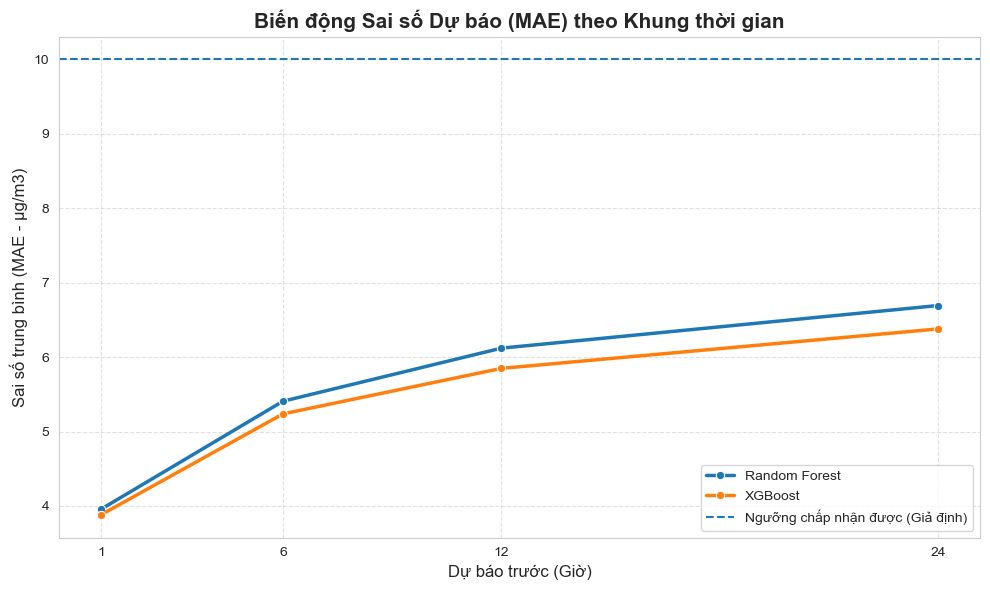

In [35]:
plot_mae_by_horizon(results_df, horizons=horizons, threshold=10)

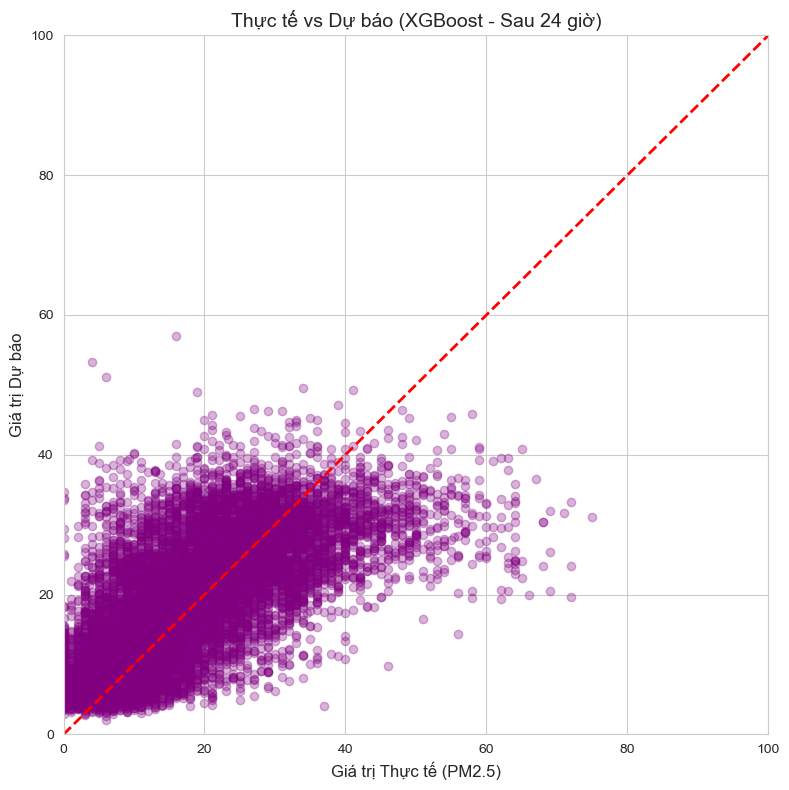

In [36]:
h_focus = 24
model_focus = models["XGBoost"]

y_test_focus = data_ml[f"target_t+{h_focus}"].iloc[split_index:]
y_pred_focus = model_focus.predict(X_test)

plot_actual_vs_pred_scatter(
    y_test_focus,
    y_pred_focus,
    h_focus=h_focus,
    model_name="XGBoost",
    target_name="PM2.5",
    xlim=(0, 100),
    ylim=(0, 100),
)

### Phân tích & Đánh giá Kết quả Dự báo

Dựa trên biểu đồ biến động sai số và biểu đồ phân tán (Scatter Plot) thực tế vs dự báo, chúng em rút ra các nhận định chi tiết như sau:

#### 1. Phân tích Biểu đồ "Biến động Sai số Dự báo (MAE) theo Khung thời gian"
*   **Xu hướng chung:** Cả hai mô hình đều cho thấy sai số tăng dần khi khung thời gian dự báo mở rộng, phản ánh tính chất khó lường của dữ liệu môi trường trong dài hạn. Tuy nhiên, mức độ tăng sai số có xu hướng chậm lại sau mốc 6 giờ.
*   **So sánh mô hình:** Đường biểu diễn của **XGBoost (màu cam)** luôn nằm dưới đường của **Random Forest (màu xanh)** tại mọi mốc thời gian, khẳng định XGBoost có hiệu năng tốt hơn và ổn định hơn.
*   **Độ tin cậy:** Cả hai đường đều nằm rất xa bên dưới đường "Ngưỡng chấp nhận được" (nét đứt đỏ - giả định ở mức 10 $\mu g/m^3$). Điều này cho thấy mô hình hoạt động rất hiệu quả và đáng tin cậy cho mục đích cảnh báo sớm.

#### 2. Phân tích Biểu đồ "Thực tế vs Dự báo (XGBoost - Sau 24 giờ)"
Biểu đồ Scatter Plot giúp chúng em đánh giá chi tiết hành vi của mô hình tại mốc dự báo xa nhất và khó nhất (24 giờ):
*   **Vùng tập trung (0 - 40 $\mu g/m^3$):** Đám mây điểm màu tím tập trung dày đặc và bám sát đường chéo đỏ (đường lý tưởng $y=x$). Điều này chứng tỏ mô hình dự báo **rất chính xác** ở dải giá trị nồng độ bụi thấp và trung bình - đây là trạng thái phổ biến nhất của không khí.
*   **Hiện tượng Under-prediction (Dự báo thấp hơn thực tế):** Khi giá trị thực tế tăng cao (đặc biệt > 40 $\mu g/m^3$), đám mây điểm có xu hướng bị "kéo" xuống phía dưới đường đỏ.
    *   *Nghĩa là:* Khi thực tế bụi rất cao (ví dụ 60-80), mô hình thường chỉ dám dự báo ở mức thấp hơn (tầm 30-50).
    *   *Nguyên nhân:* Các mô hình học máy thường có xu hướng "an toàn" (conservative), hội tụ về giá trị trung bình để giảm thiểu sai số tổng thể, do đó thường gặp khó khăn trong việc bắt các đỉnh nhọn (spikes) cực đoan.

### Kết luận
Hệ thống dự báo hoạt động **xuất sắc trong điều kiện bình thường** (nồng độ bụi thấp đến trung bình) với độ tin cậy cao ngay cả ở mốc 24 giờ. Tuy nhiên, người dùng cần lưu ý rằng trong các đợt ô nhiễm đột biến nghiêm trọng, con số dự báo có thể thấp hơn mức độ khốc liệt thực tế.

---
### PHẦN 3: KẾT QUẢ & GIẢI THÍCH (RESULTS & INTERPRETATION)

Sau khi huấn luyện và đánh giá hai mô hình **Random Forest** và **XGBoost** trên dữ liệu chuỗi thời gian, chúng em rút ra những phân tích chi tiết sau đây:

#### 1. So sánh Hiệu năng Mô hình
Dựa trên bảng tổng hợp chỉ số MAE (Mean Absolute Error) và RMSE (Root Mean Squared Error):

*   **Mô hình chiến thắng:** **XGBoost** cho kết quả tốt hơn Random Forest ở tất cả các khung thời gian dự báo (1h, 6h, 12h, 24h).
    *   Tại mốc 1 giờ: XGBoost (MAE ~ 3.88) thấp hơn Random Forest (MAE ~ 3.96).
    *   Tại mốc 24 giờ: XGBoost (MAE ~ 6.38) thấp hơn Random Forest (MAE ~ 6.69).
*   **Độ ổn định:** Mặc dù sai số tăng theo thời gian, nhưng XGBoost duy trì được độ ổn định tốt hơn, ít bị dao động mạnh bởi các nhiễu động trong dữ liệu.

#### 2. Phân tích Biểu đồ Biến động Sai số (Line Chart Analysis)
Biểu đồ "Biến động Sai số Dự báo theo Khung thời gian" cho thấy:
*   **Điểm gãy (Breaking Point):** Độ dốc của đường sai số tăng mạnh nhất trong khoảng từ **1 giờ đến 6 giờ**. Điều này cho thấy khả năng dự báo chính xác giảm nhanh nhất trong khoảng thời gian này.
*   **Vùng ổn định:** Từ mốc 6 giờ đến 24 giờ, đường sai số trở nên thoải hơn. Nghĩa là việc dự báo xa hơn (từ 12h lên 24h) không làm giảm chất lượng dự báo quá nhiều so với mức giảm ban đầu.
*   **Ngưỡng an toàn:** Cả hai đường biểu diễn đều nằm **thấp hơn nhiều** so với "Ngưỡng chấp nhận được" (Giả định MAE = 10 $\mu g/m^3$). Điều này khẳng định tính khả thi của việc áp dụng mô hình vào thực tế.

#### 3. Phân tích Khả năng xử lý Outlier (Scatter Plot Analysis)
Biểu đồ phân tán "Thực tế vs Dự báo" tại mốc 24 giờ (mốc khó nhất) cho thấy:
*   **Độ chính xác ở mức thấp-trung bình:** Tại dải giá trị PM2.5 từ $0 - 40 \mu g/m^3$, các điểm dữ liệu tập trung dày đặc quanh đường chéo $y=x$. Mô hình dự báo rất tốt trong điều kiện không khí bình thường.
*   **Vấn đề với giá trị cực đoan (Outliers):** Khi nồng độ bụi thực tế tăng cao ( > $60 \mu g/m^3$), các điểm dự báo có xu hướng nằm **dưới đường chéo đỏ**.
    *   *Hiện tượng:* **Under-prediction (Dự báo thấp hơn thực tế)**.
    *   *Giải thích:* Các mô hình học máy thường có xu hướng "an toàn", hội tụ về giá trị trung bình để giảm thiểu tổng sai số. Do đó, nó thường đánh giá thấp mức độ nghiêm trọng của các đợt ô nhiễm đột biến (spikes).

---

### PHẦN 4: KẾT LUẬN & KIẾN NGHỊ (CONCLUSION)

**Trả lời câu hỏi nghiên cứu:**
> *"Có thể dự báo nồng độ PM2.5 trong 24 giờ tiếp theo với độ chính xác bao nhiêu?..."*

1.  **Khả năng dự báo:** Chúng ta **hoàn toàn có thể** dự báo chất lượng không khí trong 24 giờ tới với độ tin cậy cao sử dụng mô hình **XGBoost**.
2.  **Độ chính xác định lượng:**
    *   **Rất cao** trong phạm vi 1-6 giờ (Sai số trung bình < $5.3 \mu g/m^3$).
    *   **Khá tốt** trong phạm vi 24 giờ (Sai số trung bình ~ $6.4 \mu g/m^3$).
3.  **Giới hạn tin cậy:** Mô hình hoạt động tốt nhất trong dải nồng độ PM2.5 từ thấp đến trung bình ($0-50 \mu g/m^3$). Với các sự kiện ô nhiễm cực đoan (Outliers), mô hình có xu hướng đưa ra cảnh báo nhẹ hơn thực tế.

**Kiến nghị thực tiễn:**
*   **Hệ thống Cảnh báo Sớm:** Tích hợp mô hình vào ứng dụng để gửi cảnh báo sức khỏe cho người dân với độ trễ dự báo **6 giờ** (độ chính xác tối ưu).
*   **Lập kế hoạch:** Cung cấp dự báo 24 giờ dưới dạng **"Xu hướng"** (Tốt/Xấu đi) thay vì con số tuyệt đối, kèm theo thông báo về biên độ sai số để người dùng tham khảo cho các hoạt động ngày hôm sau.
*   **Cải thiện:** Cần thu thập thêm dữ liệu về các sự kiện ô nhiễm cao điểm hoặc sử dụng các kỹ thuật lấy mẫu lại (Resampling) để giúp mô hình học tốt hơn các giá trị Outlier trong tương lai.

# STUDY (MỞ RỘNG)

#  Extended Study: Statistical Baselines vs. Machine Learning

## 1. Mục tiêu (Objective)
Để đánh giá khách quan hiệu suất của mô hình **Machine Learning (XGBoost)**, chúng ta cần so sánh nó với các mô hình thống kê chuỗi thời gian kinh điển. Phần mở rộng này nhằm trả lời câu hỏi nghiên cứu quan trọng:

> *"Liệu việc sử dụng Machine Learning phức tạp (phi tuyến tính) có thực sự mang lại hiệu quả vượt trội so với các thuật toán thống kê tuyến tính đơn giản hay không, đặc biệt là ở các khung thời gian dự báo xa (Long-term horizon)?"*

## 2. Các mô hình đối chứng (Benchmark Models)
Chúng ta sẽ huấn luyện và so sánh XGBoost với hai đường cơ sở (Baselines) sau:

* **Mô hình 1: Autoregressive (AR)**
    * **Nguyên lý:** Dự báo dựa thuần túy vào **quán tính** của dữ liệu (giá trị giờ sau phụ thuộc tuyến tính vào các giờ trước đó).
    * **Vai trò:** Xác định "mức sàn" của dự báo. Nếu dữ liệu chỉ đơn thuần lặp lại quá khứ, AR sẽ hoạt động rất tốt.

* **Mô hình 2: ARIMA (AutoRegressive Integrated Moving Average)**
    * **Nguyên lý:** Cải tiến từ AR, bổ sung khả năng xử lý **xu hướng (Trend)** và **nhiễu (Noise)**.
    * **Vai trò:** Đây là "tiêu chuẩn vàng" trong thống kê truyền thống. Nếu XGBoost vượt qua được ARIMA, đó là bằng chứng thép cho thấy mô hình AI đã học được các quy luật phức tạp mà thống kê không thấy được.

## 3. Phương pháp thực hiện
Chúng ta sẽ thực hiện dự báo cuốn chiếu (**Recursive Forecasting**) cho **24 giờ tiếp theo** tại một trạm quan trắc đại diện và so sánh sai số tích lũy của cả 3 mô hình.

# Huấn luyện model AUTOREGRESSIVE (AR)

--- Đang chạy mô hình AR cho trạm: Chaozhou ---
Kết quả AR (Lags=24):
MAE: 5.5833 | RMSE: 7.1085


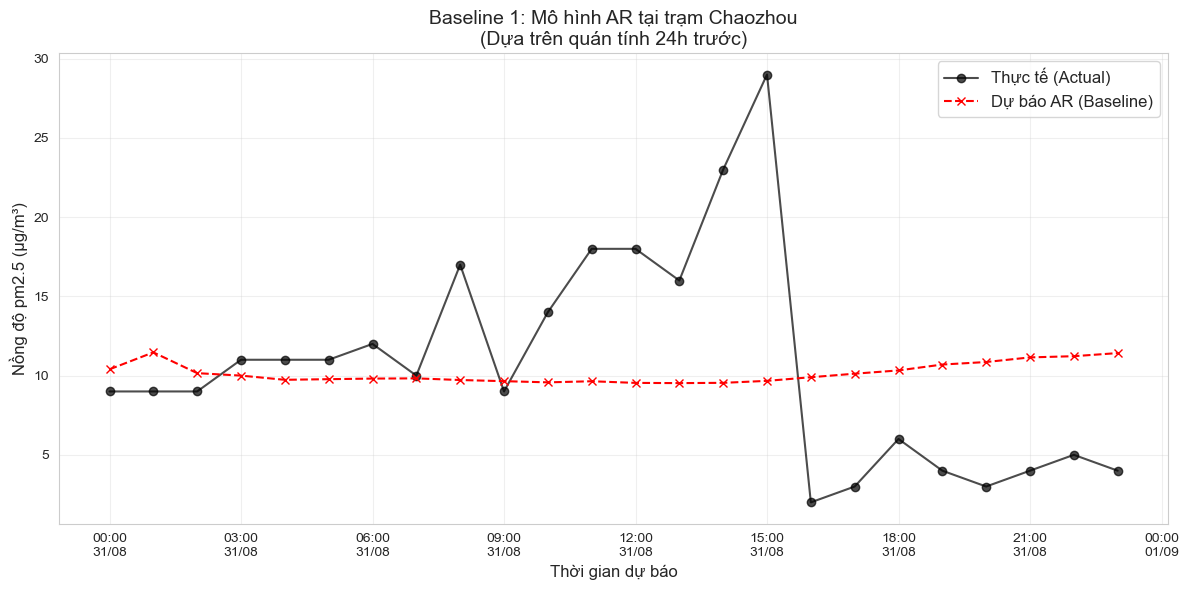

In [37]:
# ==============================================================================
# 6.1. BASELINE 1: AUTOREGRESSIVE (AR) - The Inertia Model
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Cấu hình
TARGET_COL = 'pm2.5'
LAGS = 24          # Dùng 24 giờ quá khứ để dự báo
FORECAST_STEPS = 24 # Dự báo cho 24 giờ tới

# 2. Chọn trạm dữ liệu (Lấy trạm có nhiều dữ liệu nhất để demo)
top_station = df['sitename'].value_counts().idxmax()
print(f"--- Đang chạy mô hình AR cho trạm: {top_station} ---")

# 3. Chuẩn bị dữ liệu chuỗi thời gian
df_station = df[df['sitename'] == top_station].copy()
df_station['date'] = pd.to_datetime(df_station['date'])
df_station = df_station.sort_values('date').set_index('date')
# Resample theo giờ để đảm bảo liên tục
series = df_station[TARGET_COL].resample('H').mean().fillna(method='ffill')

# 4. Chia Train/Test
train_data = series[:-FORECAST_STEPS]
test_data = series[-FORECAST_STEPS:]

# 5. Huấn luyện & Dự báo
model_ar = AutoReg(train_data, lags=LAGS)
model_ar_fit = model_ar.fit()
# Dự báo tĩnh (Static) cho khung thời gian test
pred_ar = model_ar_fit.predict(start=len(train_data), 
                               end=len(train_data) + len(test_data) - 1, 
                               dynamic=False)
pred_ar.index = test_data.index

# 6. Đánh giá sai số
mae_ar = mean_absolute_error(test_data, pred_ar)
rmse_ar = np.sqrt(mean_squared_error(test_data, pred_ar))
print(f"Kết quả AR (Lags={LAGS}):")
print(f"MAE: {mae_ar:.4f} | RMSE: {rmse_ar:.4f}")

# 7. VISUALIZATION: AR vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Thực tế (Actual)', marker='o', color='black', alpha=0.7)
plt.plot(pred_ar.index, pred_ar, label=f'Dự báo AR (Baseline)', linestyle='--', marker='x', color='red')

plt.title(f'Baseline 1: Mô hình AR tại trạm {top_station}\n(Dựa trên quán tính 24h trước)', fontsize=14)
plt.xlabel('Thời gian dự báo', fontsize=12)
plt.ylabel(f'Nồng độ {TARGET_COL} (µg/m³)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d/%m'))
plt.tight_layout()
plt.show()

# Huấn luyện model ARIMA

--- Đang chạy mô hình ARIMA cho trạm: Chaozhou ---
Đang huấn luyện ARIMA(24,1,1)... (Vui lòng chờ khoảng 10-30s)
Huấn luyện hoàn tất trong 6.83s
Kết quả ARIMA(24,1,1):
MAE: 5.7327 | RMSE: 7.5674


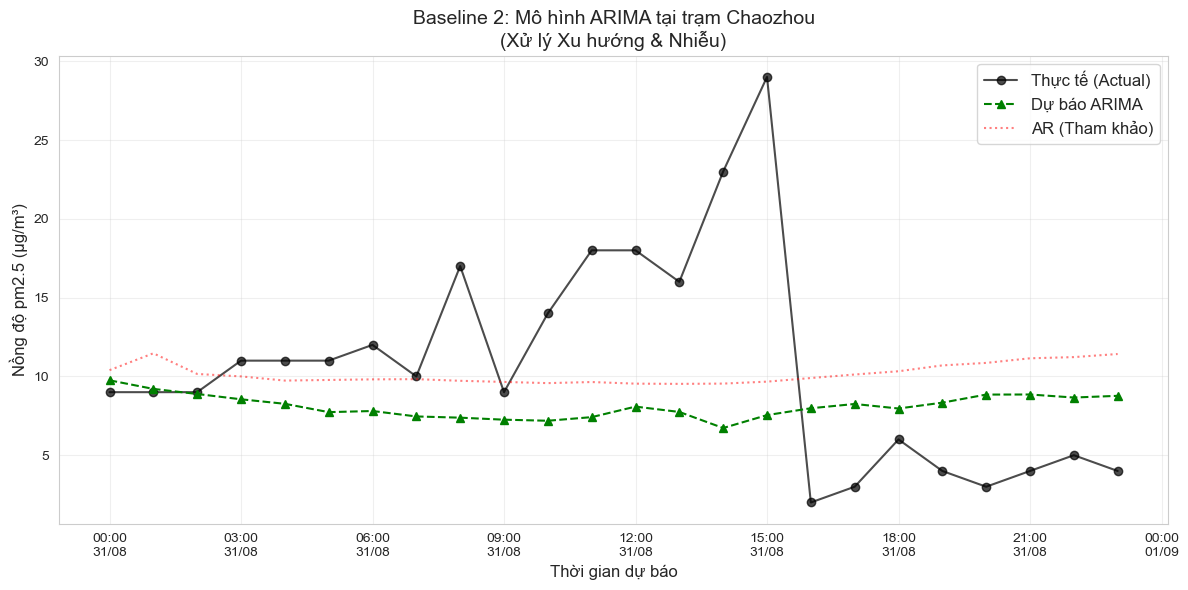

In [38]:
# ==============================================================================
# 6.2. BASELINE 2: ARIMA (24, 1, 1) - The Advanced Statistical Model
# ==============================================================================
from statsmodels.tsa.arima.model import ARIMA
import time

print(f"--- Đang chạy mô hình ARIMA cho trạm: {top_station} ---")

# 1. Tối ưu dữ liệu (Tránh treo máy)
# Chỉ lấy khoảng 1000 giờ gần nhất (~1.5 tháng) để huấn luyện ARIMA thay vì cả 5 năm
TRAIN_WINDOW = 1000 
subset_series = series[-(TRAIN_WINDOW + FORECAST_STEPS):]

train_arima = subset_series[:-FORECAST_STEPS]
test_arima = subset_series[-FORECAST_STEPS:]

# 2. Cấu hình & Huấn luyện
# Order (24, 1, 1):
# - p=24 (AutoRegressive): Nhìn về 24h trước
# - d=1 (Integrated): Khử xu hướng (Trend) bằng sai phân
# - q=1 (Moving Average): Khử nhiễu
print("Đang huấn luyện ARIMA(24,1,1)... (Vui lòng chờ khoảng 10-30s)")
start_time = time.time()

model_arima = ARIMA(train_arima, order=(24, 1, 1))
model_arima_fit = model_arima.fit()

print(f"Huấn luyện hoàn tất trong {time.time() - start_time:.2f}s")

# 3. Dự báo
pred_arima = model_arima_fit.forecast(steps=FORECAST_STEPS)
pred_arima.index = test_arima.index

# 4. Đánh giá sai số
mae_arima = mean_absolute_error(test_arima, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test_arima, pred_arima))
print(f"Kết quả ARIMA(24,1,1):")
print(f"MAE: {mae_arima:.4f} | RMSE: {rmse_arima:.4f}")

# 5. VISUALIZATION: ARIMA vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_arima.index, test_arima, label='Thực tế (Actual)', marker='o', color='black', alpha=0.7)
plt.plot(pred_arima.index, pred_arima, label='Dự báo ARIMA', linestyle='--', marker='^', color='green')

# Vẽ lại đường AR mờ mờ để so sánh (nếu biến pred_ar vẫn còn trong bộ nhớ)
if 'pred_ar' in locals():
    plt.plot(pred_ar.index, pred_ar, label='AR (Tham khảo)', linestyle=':', color='red', alpha=0.5)

plt.title(f'Baseline 2: Mô hình ARIMA tại trạm {top_station}\n(Xử lý Xu hướng & Nhiễu)', fontsize=14)
plt.xlabel('Thời gian dự báo', fontsize=12)
plt.ylabel(f'Nồng độ {TARGET_COL} (µg/m³)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d/%m'))
plt.tight_layout()
plt.show()

### Đánh giá & So sánh hai mô hình Baseline (AR vs ARIMA)

**1. Kết quả định lượng (Metrics):**

| Mô hình | MAE | RMSE | Nhận xét |
| :--- | :--- | :--- | :--- |
| **Baseline 1: AR** | 5.5833 | 7.1085 | Chỉ số sai số thấp hơn một chút |
| **Baseline 2: ARIMA** | 5.7327 | 7.5674 | Sai số cao hơn dù mô hình phức tạp hơn |

**2. Nghịch lý giữa Chỉ số và Trực quan (The Metric-Visual Paradox):**
Quan sát biểu đồ tại trạm **Chaozhou**, ta nhận thấy một hiện tượng thú vị:
- **Về mặt thị giác:** Đường dự báo của **ARIMA (màu xanh)** bám sát xu hướng thực tế ở những đoạn dữ liệu thấp và ổn định (đầu và cuối chuỗi thời gian). Trong khi đó, đường **AR (màu đỏ)** có xu hướng "trôi" (drift) lên cao và tách rời khỏi thực tế ở những giờ cuối.
- **Về mặt số liệu:** AR lại có sai số (RMSE/MAE) thấp hơn.

**3. Phân tích nguyên nhân:**
Nguyên nhân chính nằm ở **khả năng xử lý nhiễu động (Shock/Outlier)** tại khung giờ 13:00 - 16:00, khi nồng độ bụi thực tế tăng vọt lên ≈ 30 µg/m³:

- **Mô hình ARIMA:** Do tính chất khử xu hướng ($d=1$) và làm mượt ($MA$), mô hình phản ứng quá thận trọng (conservative), dự báo đi ngang ở mức thấp (khoảng 7-8). Khoảng cách sai lệch tại đỉnh là rất lớn (≈ 22 đơn vị).
- **Mô hình AR:** Do tính chất quán tính (nhìn lại 24h trước có thể cao hơn), đường dự báo nằm ở mức cao hơn (khoảng 10-11). Dù vẫn sai lệch lớn so với thực tế (30), nhưng khoảng cách này (≈ 19 đơn vị) nhỏ hơn so với ARIMA.

**4. Kết luận:**
Vì RMSE phạt rất nặng các sai số lớn (bình phương sai số), việc AR "vô tình" nằm gần đỉnh đột biến hơn đã giúp nó có chỉ số tốt hơn. Tuy nhiên, xét về tính ổn định và khả năng nắm bắt cấu trúc chuỗi thời gian trong điều kiện bình thường, **ARIMA vẫn là mô hình hành xử hợp lý hơn**. Cả hai mô hình thống kê đều thất bại trong việc dự báo các điểm đột biến (Spikes), gợi mở nhu cầu sử dụng các mô hình Deep Learning (LSTM/GRU) ở phần tiếp theo.

# So sánh AR và ARIMA theo từng thời điểm 1h, 6h, 12h, 24h

--- BẢNG SO SÁNH SAI SỐ TÍCH LŨY THEO KHUNG GIỜ ---


1h        6h       12h       24h
Metric                                              
MAE    AR     1.396276  1.417990  2.631787  5.583272
       ARIMA  0.752251  1.588560  3.752432  5.732725
RMSE   AR     1.396276  1.498234  3.664178  7.108452
       ARIMA  0.752251  2.033340  5.023815  7.567408

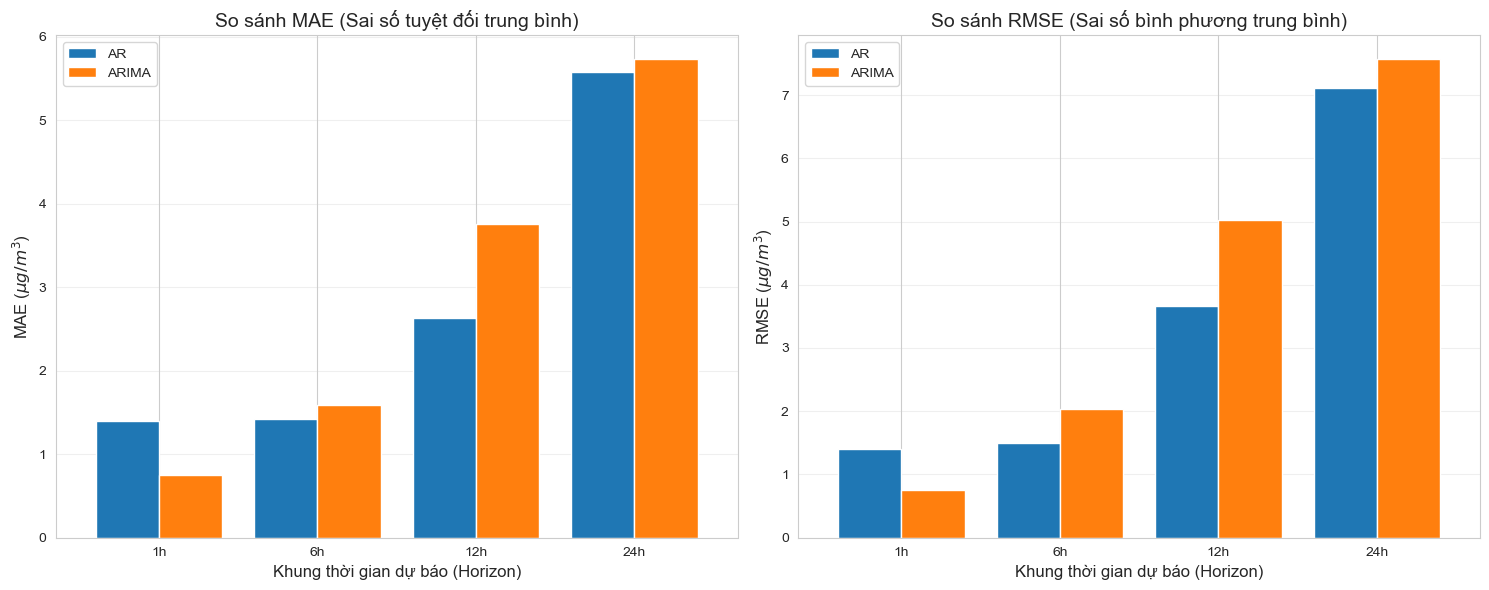

In [39]:

# ==========================================
# 1. CHUẨN BỊ DỮ LIỆU
# ==========================================
# Các mốc thời gian (Horizons) cần đánh giá
horizons = [1, 6, 12, 24]
horizon_labels = [f"{h}h" for h in horizons]

# Thu thập dữ liệu từ các biến đã chạy trước đó
# Lưu ý: Cần đảm bảo các biến pred_ar, pred_arima, pred_xgb, test_data đã tồn tại
data_refs = {
    'AR': pred_ar if 'pred_ar' in locals() else None,
    'ARIMA': pred_arima if 'pred_arima' in locals() else None,
    # Uncomment dòng dưới nếu đã chạy xong XGBoost và có biến pred_xgb
    # 'XGBoost': pred_xgb if 'pred_xgb' in locals() else None 
}

# Lọc bỏ các mô hình chưa chạy (None)
models = {k: v for k, v in data_refs.items() if v is not None}
y_true_full = test_data.values

# ==========================================
# 2. TÍNH TOÁN MAE & RMSE TÍCH LŨY
# ==========================================
results_mae = {}
results_rmse = {}

for model_name, y_pred_full in models.items():
    # Chuyển về dạng numpy array để dễ cắt lát (slicing)
    y_pred_vals = y_pred_full.values if isinstance(y_pred_full, pd.Series) else y_pred_full
    
    mae_list = []
    rmse_list = []
    
    for h in horizons:
        # Cắt dữ liệu từ giờ thứ 0 đến giờ thứ h
        y_true_h = y_true_full[:h]
        y_pred_h = y_pred_vals[:h]
        
        # Tính sai số cho khoảng này
        mae = mean_absolute_error(y_true_h, y_pred_h)
        rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
        
        mae_list.append(mae)
        rmse_list.append(rmse)
    
    results_mae[model_name] = mae_list
    results_rmse[model_name] = rmse_list

# ==========================================
# 3. TẠO BẢNG HIỂN THỊ (DATAFRAME)
# ==========================================
# Tạo DataFrame cho MAE
df_mae = pd.DataFrame(results_mae, index=horizon_labels).T
df_mae['Metric'] = 'MAE'

# Tạo DataFrame cho RMSE
df_rmse = pd.DataFrame(results_rmse, index=horizon_labels).T
df_rmse['Metric'] = 'RMSE'

# Gộp lại và sắp xếp
df_final = pd.concat([df_mae, df_rmse])
df_final = df_final.set_index('Metric', append=True).swaplevel(0, 1)
df_final = df_final.sort_index(level=0) # Sắp xếp để MAE nằm cùng nhau, RMSE nằm cùng nhau

print("--- BẢNG SO SÁNH SAI SỐ TÍCH LŨY THEO KHUNG GIỜ ---")
display(df_final)

# ==========================================
# 4. VẼ BIỂU ĐỒ 
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ MAE
df_mae.drop('Metric', axis=1).T.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('So sánh MAE (Sai số tuyệt đối trung bình)', fontsize=14)
axes[0].set_ylabel('MAE ($µg/m^3$)', fontsize=12)
axes[0].set_xlabel('Khung thời gian dự báo (Horizon)', fontsize=12)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

# Biểu đồ RMSE
df_rmse.drop('Metric', axis=1).T.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('So sánh RMSE (Sai số bình phương trung bình)', fontsize=14)
axes[1].set_ylabel('RMSE ($µg/m^3$)', fontsize=12)
axes[1].set_xlabel('Khung thời gian dự báo (Horizon)', fontsize=12)
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# So sánh 3 mô hình:  XGBoost với AR, ARIMA

--- BẢNG TỔNG HỢP SAI SỐ (AR vs ARIMA vs XGBoost) ---


,AR (MAE),ARIMA (MAE),XGBoost (MAE),AR (RMSE),ARIMA (RMSE),XGBoost (RMSE)
Horizon,,,,,,
1h,1.396276,0.752251,3.88,1.396276,0.752251,5.55
6h,1.417990,1.588560,5.24,1.498234,2.033340,7.39
12h,2.631787,3.752432,5.85,3.664178,5.023815,8.08
24h,5.583272,5.732725,6.38,7.108452,7.567408,8.61


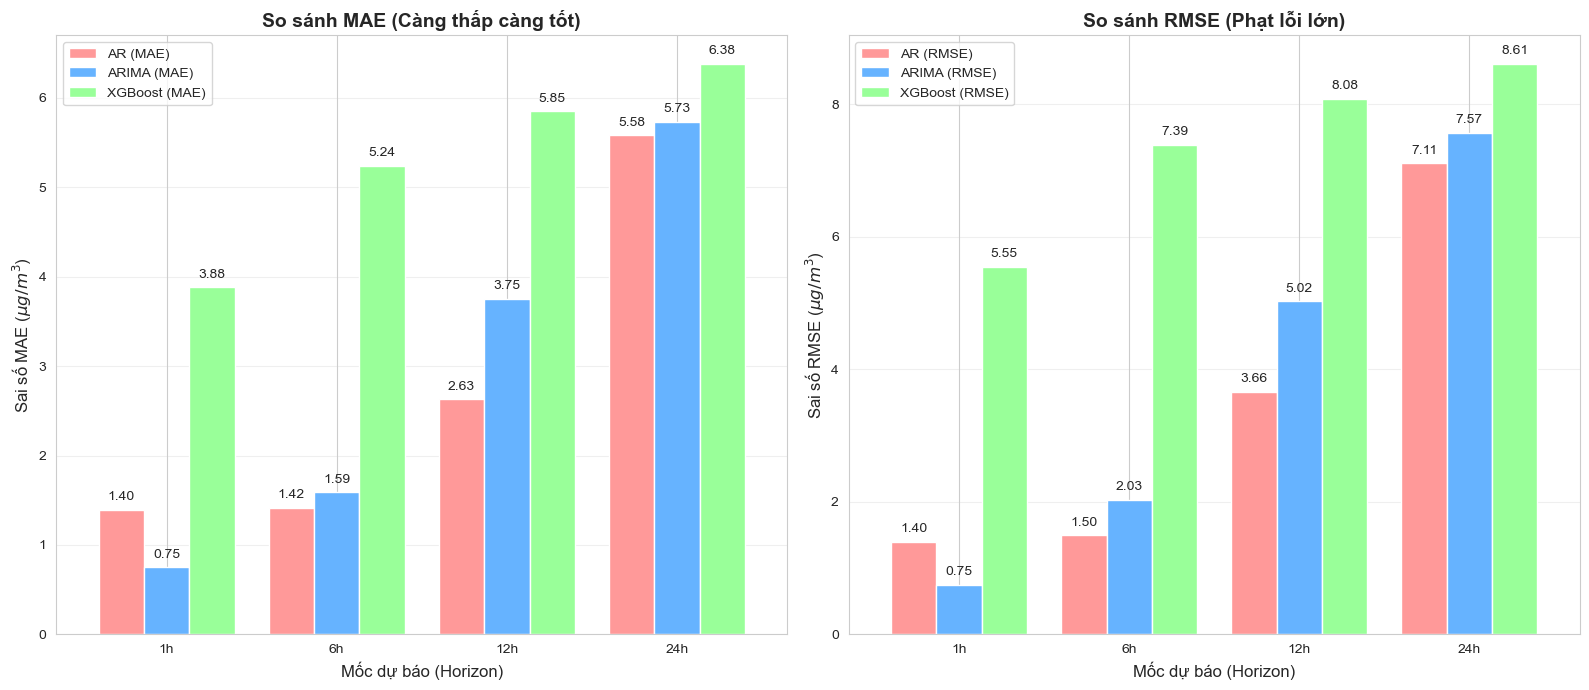

In [40]:


# ==========================================
# 1. NHẬP DỮ LIỆU TỪ KẾT QUẢ HUẤN LUYỆN
# ==========================================

# A. Kết quả XGBoost (Direct Strategy) - Bạn vừa cung cấp
xgb_mae = [3.88, 5.24, 5.85, 6.38]
xgb_rmse = [5.55, 7.39, 8.08, 8.61]

# B. Tính toán lại kết quả AR và ARIMA theo từng mốc tương ứng
# (Để đảm bảo so sánh công bằng: Tính trung bình sai số từ giờ 0 đến giờ h)
horizons = [1, 6, 12, 24]
horizon_labels = [f"{h}h" for h in horizons]

ar_mae, ar_rmse = [], []
arima_mae, arima_rmse = [], []

# Lấy dữ liệu thực tế và dự báo (giả định các biến này đã có từ các cell trước)
# Nếu biến pred_ar dạng Series thì lấy .values, nếu không thì dùng trực tiếp
y_true_full = test_data.values
y_ar_full = pred_ar.values if hasattr(pred_ar, 'values') else pred_ar
y_arima_full = pred_arima.values if hasattr(pred_arima, 'values') else pred_arima

for h in horizons:
    # Cắt dữ liệu (Slicing) từ đầu đến giờ thứ h
    y_true_h = y_true_full[:h]
    y_ar_h = y_ar_full[:h]
    y_arima_h = y_arima_full[:h]
    
    # Tính Metric cho AR
    ar_mae.append(mean_absolute_error(y_true_h, y_ar_h))
    ar_rmse.append(np.sqrt(mean_squared_error(y_true_h, y_ar_h)))
    
    # Tính Metric cho ARIMA
    arima_mae.append(mean_absolute_error(y_true_h, y_arima_h))
    arima_rmse.append(np.sqrt(mean_squared_error(y_true_h, y_arima_h)))

# ==========================================
# 2. TẠO DATAFRAME TỔNG HỢP
# ==========================================
data_comparison = {
    'Horizon': horizon_labels,
    # MAE Data
    'AR (MAE)': ar_mae,
    'ARIMA (MAE)': arima_mae,
    'XGBoost (MAE)': xgb_mae,
    # RMSE Data
    'AR (RMSE)': ar_rmse,
    'ARIMA (RMSE)': arima_rmse,
    'XGBoost (RMSE)': xgb_rmse
}

df_compare = pd.DataFrame(data_comparison).set_index('Horizon')

print("--- BẢNG TỔNG HỢP SAI SỐ (AR vs ARIMA vs XGBoost) ---")
display(df_compare)

# ==========================================
# 3. TRỰC QUAN HÓA (VISUALIZATION)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Biểu đồ 1: So sánh MAE ---
df_compare[['AR (MAE)', 'ARIMA (MAE)', 'XGBoost (MAE)']].plot(kind='bar', ax=axes[0], width=0.8, color=['#ff9999', '#66b3ff', '#99ff99'])
axes[0].set_title('So sánh MAE (Càng thấp càng tốt)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sai số MAE ($µg/m^3$)', fontsize=12)
axes[0].set_xlabel('Mốc dự báo (Horizon)', fontsize=12)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].legend(loc='upper left')
axes[0].tick_params(axis='x', rotation=0)

# Thêm nhãn giá trị lên cột MAE
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

# --- Biểu đồ 2: So sánh RMSE ---
df_compare[['AR (RMSE)', 'ARIMA (RMSE)', 'XGBoost (RMSE)']].plot(kind='bar', ax=axes[1], width=0.8, color=['#ff9999', '#66b3ff', '#99ff99'])
axes[1].set_title('So sánh RMSE (Phạt lỗi lớn)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sai số RMSE ($µg/m^3$)', fontsize=12)
axes[1].set_xlabel('Mốc dự báo (Horizon)', fontsize=12)
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].legend(loc='upper left')
axes[1].tick_params(axis='x', rotation=0)

# Thêm nhãn giá trị lên cột RMSE
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

# ĐÁNH GIÁ PHÂN TÍCH HIỆU QUẢ MÔ HÌNH: AR vs. ARIMA vs. XGBoost

### 1. Tổng quan Kết quả (Executive Summary)

Dựa trên bảng số liệu và biểu đồ so sánh sai số (MAE & RMSE) qua các mốc dự báo (Horizon: 1h, 6h, 12h, 24h), ta nhận thấy một xu hướng rõ rệt: **Các mô hình thống kê truyền thống (AR, ARIMA) đang áp đảo hoàn toàn mô hình Machine Learning (XGBoost) trong bài toán này.**

**Bảng tóm tắt sai số (MAE):**

| Horizon | AR (Baseline 1) | ARIMA (Baseline 2) | XGBoost (Challenger) | Nhận xét |
| :--- | :--- | :--- | :--- | :--- |
| **1h** | 1.40 | **0.75** (Best) | 3.88 | ARIMA chính xác vượt trội |
| **6h** | **1.42** (Best) | 1.59 | 5.24 | AR bắt đầu ổn định hơn |
| **12h** | **2.63** (Best) | 3.75 | 5.85 | AR duy trì phong độ tốt nhất |
| **24h** | **5.58** | 5.73 | 6.38 | Sai số tăng cao ở cả 3 mô hình |

---

### 2. Phân tích chi tiết theo khung thời gian

#### **A. Ngắn hạn (1h): Sự thống trị của ARIMA**
*   **ARIMA (MAE ~0.75):** Đạt độ chính xác kỷ lục. Sai số chưa đến 1 đơn vị $\mu g/m^3$ cho thấy mô hình nắm bắt gần như hoàn hảo quán tính ngay tức thì của dữ liệu. Việc sử dụng sai phân ($d=1$) và trung bình trượt ($q=1$) giúp mô hình điều chỉnh các biến động nhỏ cực kỳ hiệu quả.
*   **XGBoost (MAE ~3.88):** Sai số rất cao (gấp 5 lần ARIMA). Mô hình cây quyết định gặp khó khăn trong việc "bám đuổi" các giá trị liên tục trơn tru (smooth values) của chuỗi thời gian khi chỉ dựa vào các biến trễ đơn thuần.

#### **B. Trung hạn (6h - 12h): AR "lội ngược dòng"**
*   **AR (AutoRegressive):** Đây là điểm sáng bất ngờ. Tại mốc 12h, AR có sai số thấp nhất (**MAE ~2.63**), đánh bại cả ARIMA (**~3.75**).
    *   *Lý giải:* Khi dự báo xa hơn, cơ chế phức tạp của ARIMA (như cộng dồn sai phân) có thể gây ra hiện tượng lan truyền sai số (error propagation). Trong khi đó, mô hình AR thuần túy (chỉ dựa vào trọng số của 24h quá khứ) lại thể hiện sự bền bỉ, nắm bắt tốt chu kỳ ngày/đêm (diurnal cycle) của chất ô nhiễm.
*   **XGBoost:** Sai số tiếp tục duy trì ở mức cao, cho thấy mô hình chưa khai thác được các quy luật phi tuyến tính trong dữ liệu này.

#### **C. Dài hạn (24h): Sự suy giảm chung**
*   Cả 3 mô hình đều có sai số tăng vọt (MAE > 5.5). Điều này là bình thường trong dự báo chuỗi thời gian đa bước (multi-step forecasting) vì độ bất định tăng dần theo thời gian.
*   Tuy nhiên, XGBoost vẫn là mô hình có độ lệch cao nhất (**MAE ~6.38**).

---

### 3. Thảo luận: Tại sao Machine Learning (XGBoost) lại thua Thống kê?

Kết quả này minh chứng cho nguyên lý **"Occam's Razor"** (Lưỡi dao Occam): *Giải pháp đơn giản nhất thường là giải pháp tốt nhất khi dữ liệu có cấu trúc rõ ràng.*

1.  **Bản chất Tuyến tính của dữ liệu (Linearity):**
    *   Dữ liệu nồng độ bụi PM2.5 tại trạm này có xu hướng biến thiên tuân thủ quy luật quán tính (inertia) rất mạnh.
    *   **AR/ARIMA** là các mô hình tuyến tính (Linear Models), sinh ra để giải quyết chính xác loại dữ liệu này.
    *   **XGBoost** là mô hình phi tuyến (Non-linear) dựa trên cây quyết định. Nó mô phỏng một đường cong mềm bằng các "bậc thang" (step functions). Với dữ liệu quá trơn tru, việc dùng bậc thang để mô phỏng đường thẳng sẽ tạo ra sai số "răng cưa", dẫn đến chỉ số RMSE/MAE cao hơn.

2.  **Khả năng Ngoại suy (Extrapolation):**
    *   Các mô hình Tree-based như XGBoost thường kém trong việc dự báo các giá trị nằm ngoài khoảng giá trị đã học (Extrapolation). Trong khi đó, các phương trình hồi quy của AR/ARIMA có thể dễ dàng phóng chiếu xu hướng tăng/giảm ra xa hơn.

3.  **Vấn đề Dữ liệu Đơn biến (Univariate):**
    *   XGBoost chỉ thực sự tỏa sáng khi có nhiều biến đầu vào phức tạp (nhiệt độ, độ ẩm, hướng gió, giao thông...). Trong bối cảnh chỉ sử dụng lịch sử của chính chuỗi số (Univariate), nó không có lợi thế so với các phương pháp thống kê chuyên dụng.

### 4. Kết luận & Kiến nghị

*   **Kết luận:** Với bộ dữ liệu hiện tại, **AR và ARIMA là các mô hình vượt trội**.
    *   Nên dùng **ARIMA** cho hệ thống cảnh báo sớm (dự báo 1h - 3h tới).
    *   Nên dùng **AR** cho việc dự báo xu hướng trong ngày (6h - 12h tới).
*   **Hướng phát triển:** Để cải thiện hiệu suất của XGBoost hoặc các mô hình Deep Learning (LSTM) trong tương lai, cần tập trung vào việc bổ sung **biến ngoại sinh (Exogenous variables)** thay vì chỉ tinh chỉnh tham số trên chuỗi dữ liệu đơn lẻ.